In [1]:
###### import
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns
from scipy import signal
from importlib import reload

import winsound as sd
import pickle
import sys
import os

from Tools.tools import *
from Plasticity.plasticity import *
from Neuron.neuron import *
from Model.model import *
from Analysis.analysis import *
import Operate_model

In [13]:
# Load
cd = os.getcwd()
path = os.path.dirname(cd)

with open(path+'//Data_final16_v2.pkl', 'rb') as file:
    # Patterns in input layer
    Data = pickle.load(file)   
    # The number of data
    Datalen = pickle.load(file)    
    # Patterns of granule cells
    Data_DG = pickle.load(file)
    
    # Lengths of each patterns of granule cells
    Data_DG_len = pickle.load(file)
    Data_idx = pickle.load(file) # indices of patterns having proper lengths.
    DataX_idx = pickle.load(file) # indices of patterns having proper lengths.
    
    # 각 pair에 대한 input/output overlap값과 index
    OverI = pickle.load(file)
    OverO = pickle.load(file)
    Pair_idx = pickle.load(file)
    
    # 길이로 분류한 pair에 대한 input/output overlap값과 index
    OverI_v2 = pickle.load(file)
    OverO_v2 = pickle.load(file)
    Pair_idx_v2 = pickle.load(file)
    
with open(path+'//Data_final16_v2-CA3.pkl', 'rb') as file:
    # Filtered by proper length
    Filt_idata = pickle.load(file) # patterns in input layer
    Filt_gdata = pickle.load(file) # patterns of granule cells
    Filt_glen = pickle.load(file) # lengths of each patterns of granule cells
    F_DataLen = pickle.load(file) # the number of data
    
    # Index of CA3 patterns
    Af_py = pickle.load(file) # Pyramidal neurons
    Af_in = pickle.load(file) # Inhibitory neurons
    
    # 뭐였더라
    In_py_list = pickle.load(file)
    In_in_list = pickle.load(file)

In [ ]:
# Load
cd = os.getcwd()
path = os.path.dirname(cd)
    
with open(path+'//Data_final16_v2-CA3.pkl', 'rb') as file:
    # Filtered by proper length
    Filt_idata = pickle.load(file) # patterns in input layer
    Filt_gdata = pickle.load(file) # patterns of granule cells
    Filt_glen = pickle.load(file) # lengths of each patterns of granule cells
    F_DataLen = pickle.load(file) # the number of data
    
    # Index of CA3 patterns
    Af_py = pickle.load(file) # Pyramidal neurons
    Af_in = pickle.load(file) # Inhibitory neurons
    
    # 뭐였더라
    In_py_list = pickle.load(file)
    In_in_list = pickle.load(file)

In [5]:
class config:
    def __init__(self, pc):
        # The number of neurons
        self.N_I = 16
        self.N_O = self.N_I

        self.N_DG = 800
        self.N_DGH = self.N_I
        self.N_DGM = 100 
        self.N_DGB = 400 

        self.N_CA3 = pc[3] 
        self.N_CA1 = 200
        self.N_CA3i = pc[4] 
        
        # Weights of each connection
        # From EC
        self.w_EI = 3
        self.w_ppDG = 2 
        self.w_ppCA3 = 1 
        self.w_ppCA1 = 0.5 

        # DG
        self.w_IH = 3 
        self.w_IB = 4 
        self.w_IM = 3 
        self.w_HM = 4 
        self.w_MB = 4 
        self.w_BDG = 3 

        # CA3
        self.w_mf = 2 
        self.w_mfi = 2 
        self.w_Rc = 1

        self.w_CA33i = 1
        self.w_3iCA3 = 2 
        self.w_3i3i = 0.5 
        self.w_NoCA3 = 0.5

        # CA1
        self.w_Sc = 0.15
        self.w_CA1O = 2 

        # The number of connections 
        # From EC
        self.c_ppDG = 1
        self.c_ppCA3 = 8
        self.c_ppCA1 = 3

        # DG
        self.c_IH = 1
        self.c_IB = self.N_I
        self.c_IM = self.N_I*2//3
        self.c_HM = 1
        self.c_MB = self.N_I
        self.c_BDG = 1

        # CA3
        self.c_mf = pc[0]
        self.c_mfi = pc[1]
        self.c_Rc = self.N_CA3//4

        self.c_CA33i = self.N_CA3i//4
        self.c_3iCA3 = pc[2]
        self.c_3i3i = pc[5]
        self.c_NoCA3 = self.N_CA3
        self.c_Sc =  self.N_CA3//2

        # Parameters for delay
        self.d_I = 10
        self.d_O = 15
        self.d_DG = 3
        self.d_CA3 = 5
        self.d_CA3i = 1

In [6]:
# init
pc = [30,3,600,2400,120,20]
already_learned = False
learned_weights = [0,0,0,0]
params = config(pc)

In [14]:
# Neuron indices want to see the specific values
WTS_I = []
WTS_DGH = []
WTS_DGM = []
WTS_DGB = []
WTS_DG = []
WTS_CA3 = []
WTS_CA3i = []
WTS_CA1 = []
WTS = [WTS_I, WTS_DGH, WTS_DGM, WTS_DGB, WTS_DG, WTS_CA3, WTS_CA3i, WTS_CA1]

In [15]:
# Arbitrary 10 inputs
Target_Data = [249, 423, 80, 422, 228, 219, 517, 111, 346, 509]

In [ ]:
# Learning
for Tar in range(1):
    # initiation
    En_win = 120
    Re_win = 120
    Phase_num = len(Target_Data)
    only_DG = False
    only_CA3 = False

    selective_inhibition = True
    already_learned = False
    Direct_pp = True
    learned_weights = [0,0,0,0]

    Num_tar = len(Target_Data)
    Num_cue = 1
    Repeat = 1

    Target = Target_Data
    Cue = np.zeros(16)

    network, Fail, If_fail, Success, Winfin, Voltage, FT = Operate_model.run_model(
        En_win, Re_win, 
        only_DG, only_CA3, 
        Num_tar, Num_cue, Repeat, Target, Cue, 
        WTS, params, 
        already_learned, learned_weights, Direct_pp,
        Filt_idata, Filt_gdata, Af_py, Af_in)

    if not already_learned:
        with open('Learned weights-A10.pkl' , 'wb') as file:
            pickle.dump(network.q_ppCA3, file)
            pickle.dump(network.q_Rc, file)
            pickle.dump(network.q_CA33i, file)
            pickle.dump(network.q_Sc, file)
            
with open('Spikes_encoding.pkl', 'wb') as file:
    pickle.dump(network, file)
    pickle.dump(FT, file)
    pickle.dump(Voltage, file)

0 74 [885]


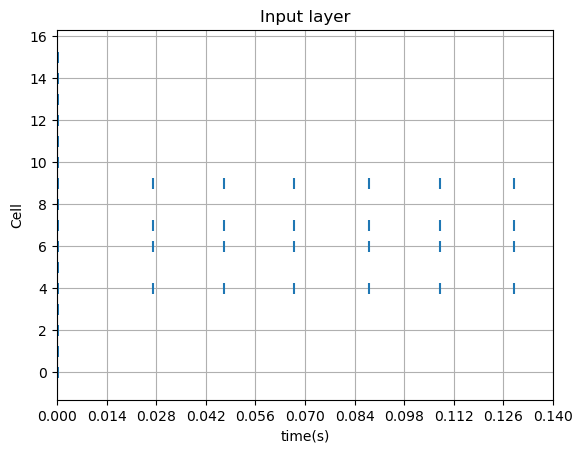

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


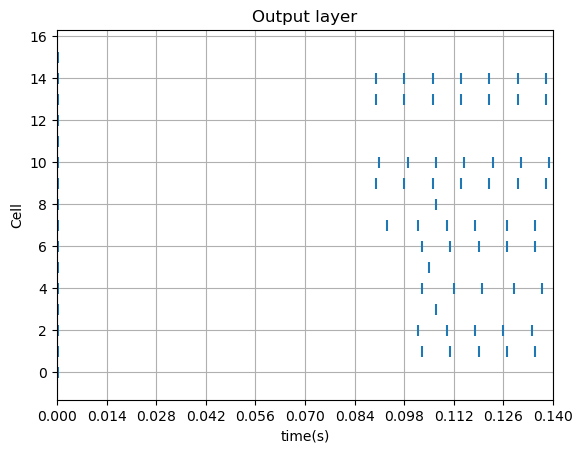

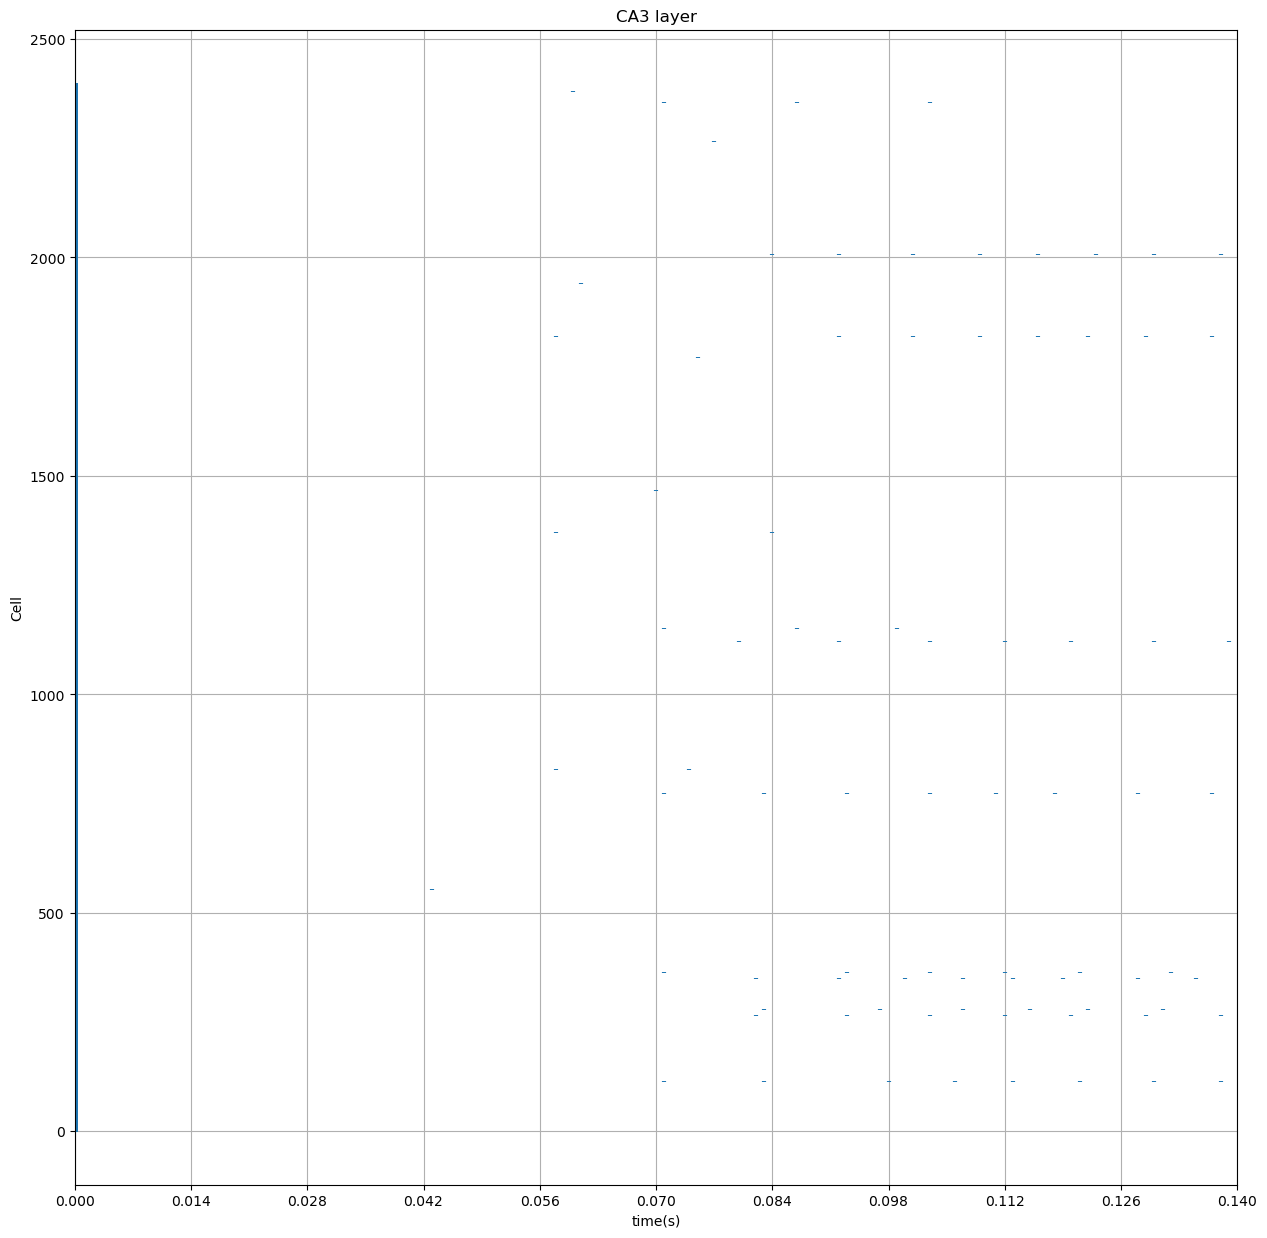

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


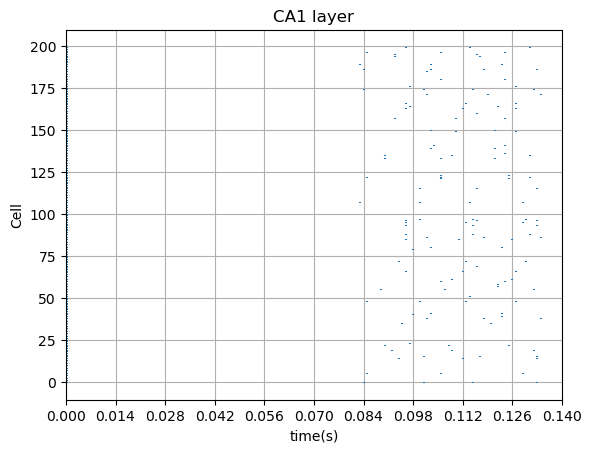

Ret1 :  {554}
Ret2 :  {2380, 557, 1371, 1940, 1819, 828}
Ret3 :  {1819, 1374, 1122, 773, 265, 364, 557, 1772, 114, 2355, 1467, 278, 2007, 2266, 1371, 828, 349, 1150}
Rc :  {1122, 773, 265, 364, 557, 114, 2355, 278, 2007, 1819, 349, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------


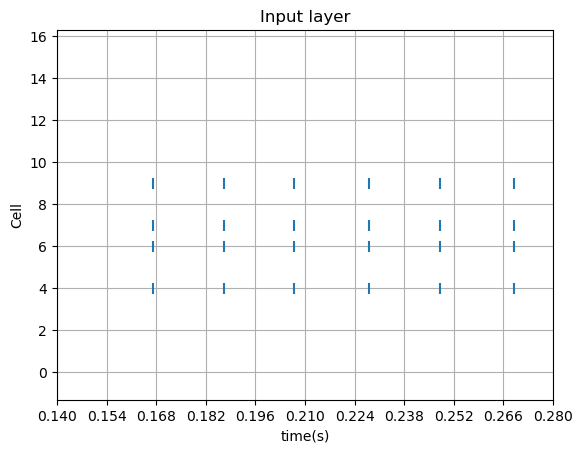

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


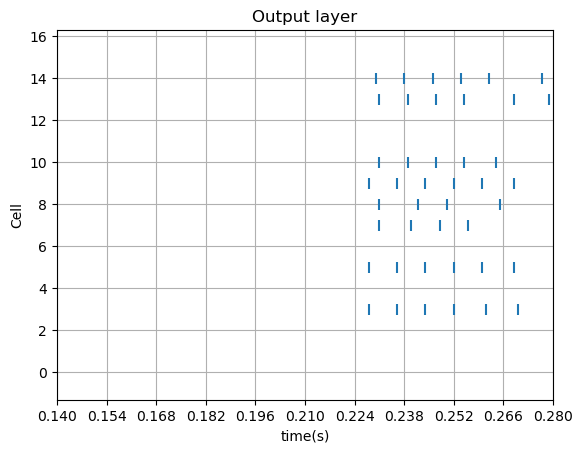

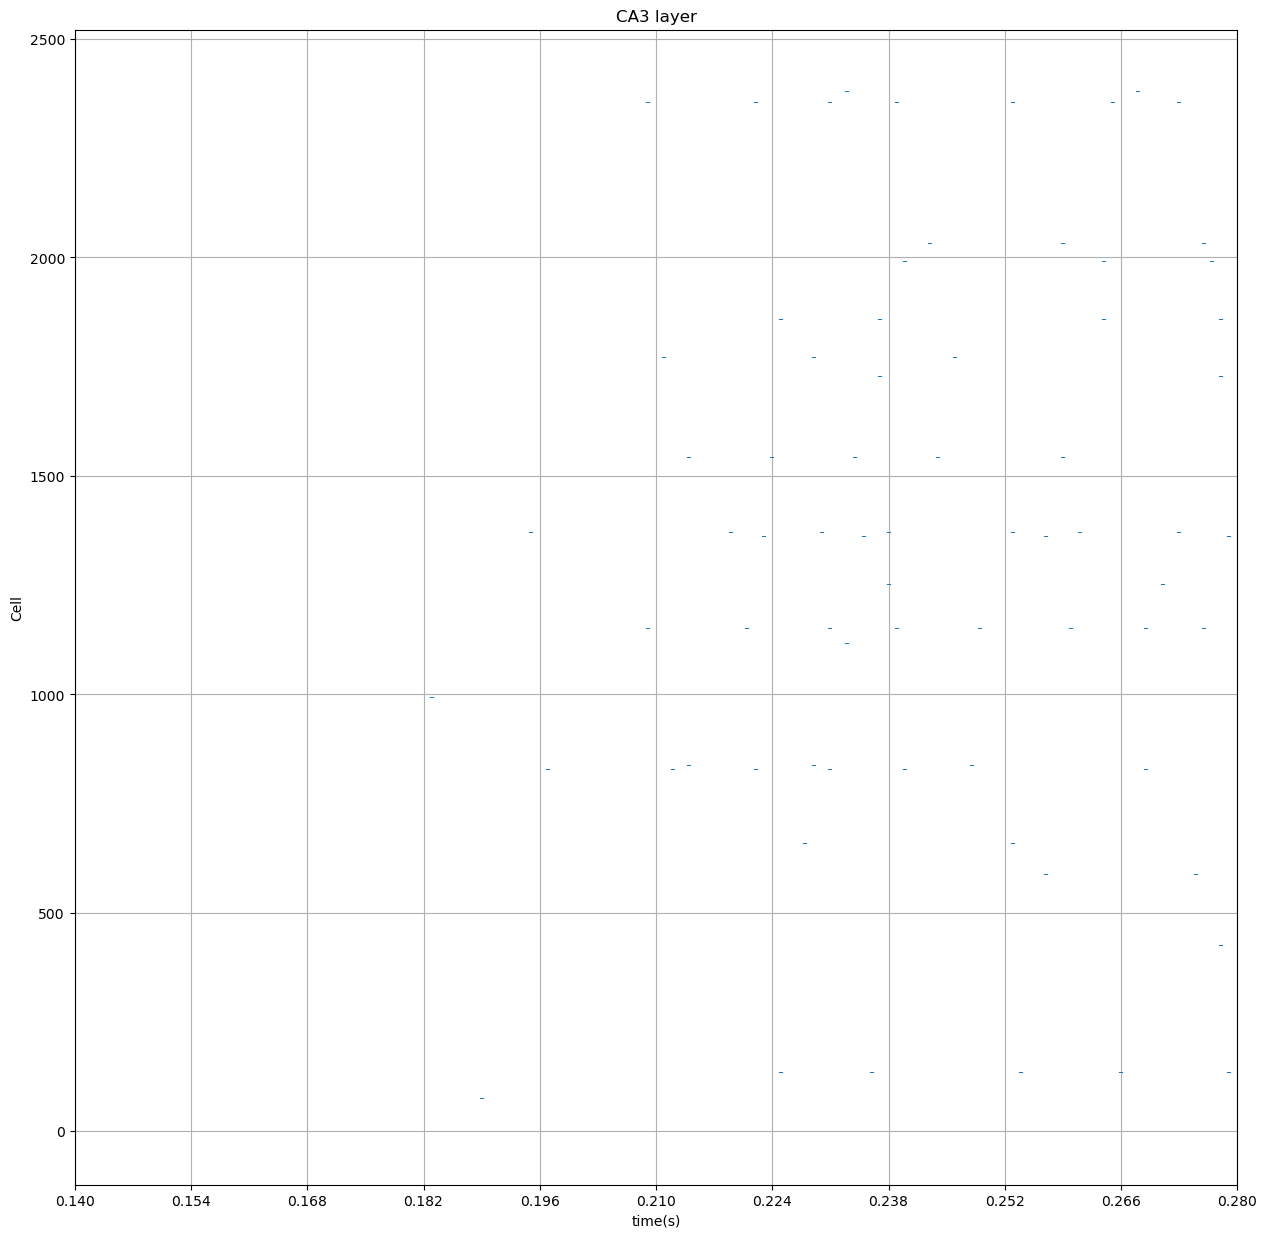

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


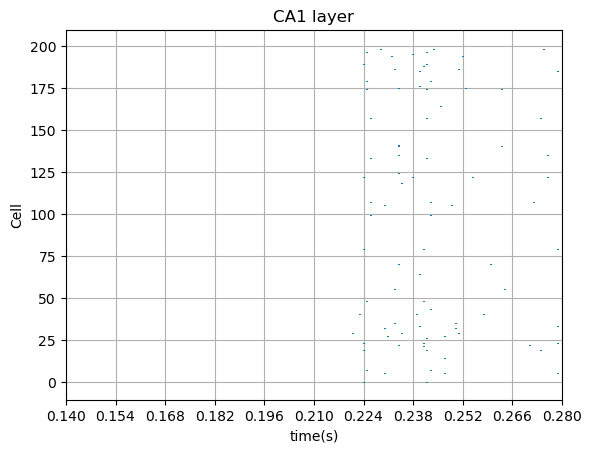

Ret1 :  {993, 1946, 557}
Ret2 :  {75, 557, 2355, 1371, 828, 1150}
Ret3 :  {1857, 837, 134, 1542, 1770, 1772, 557, 2380, 1116, 1969, 658, 1362, 2355, 1371, 828, 1150}
Rc :  {134, 1542, 658, 425, 557, 1969, 2355, 828, 1727, 1857, 837, 1991, 588, 2380, 1362, 1882, 1371, 1374, 1251, 1770, 1772, 2031, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 303 [1094]
0 317 [2051]
0 360 [2051]
0 361 [402]
0 372 [237]
0 382 [1921]


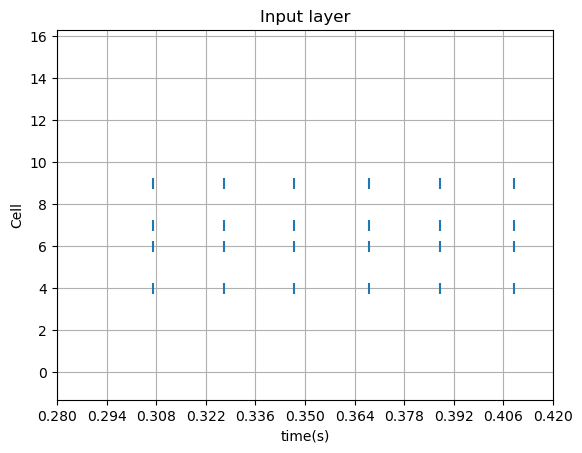

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


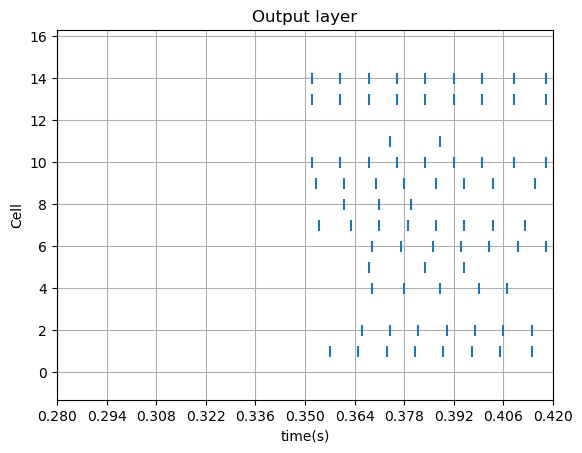

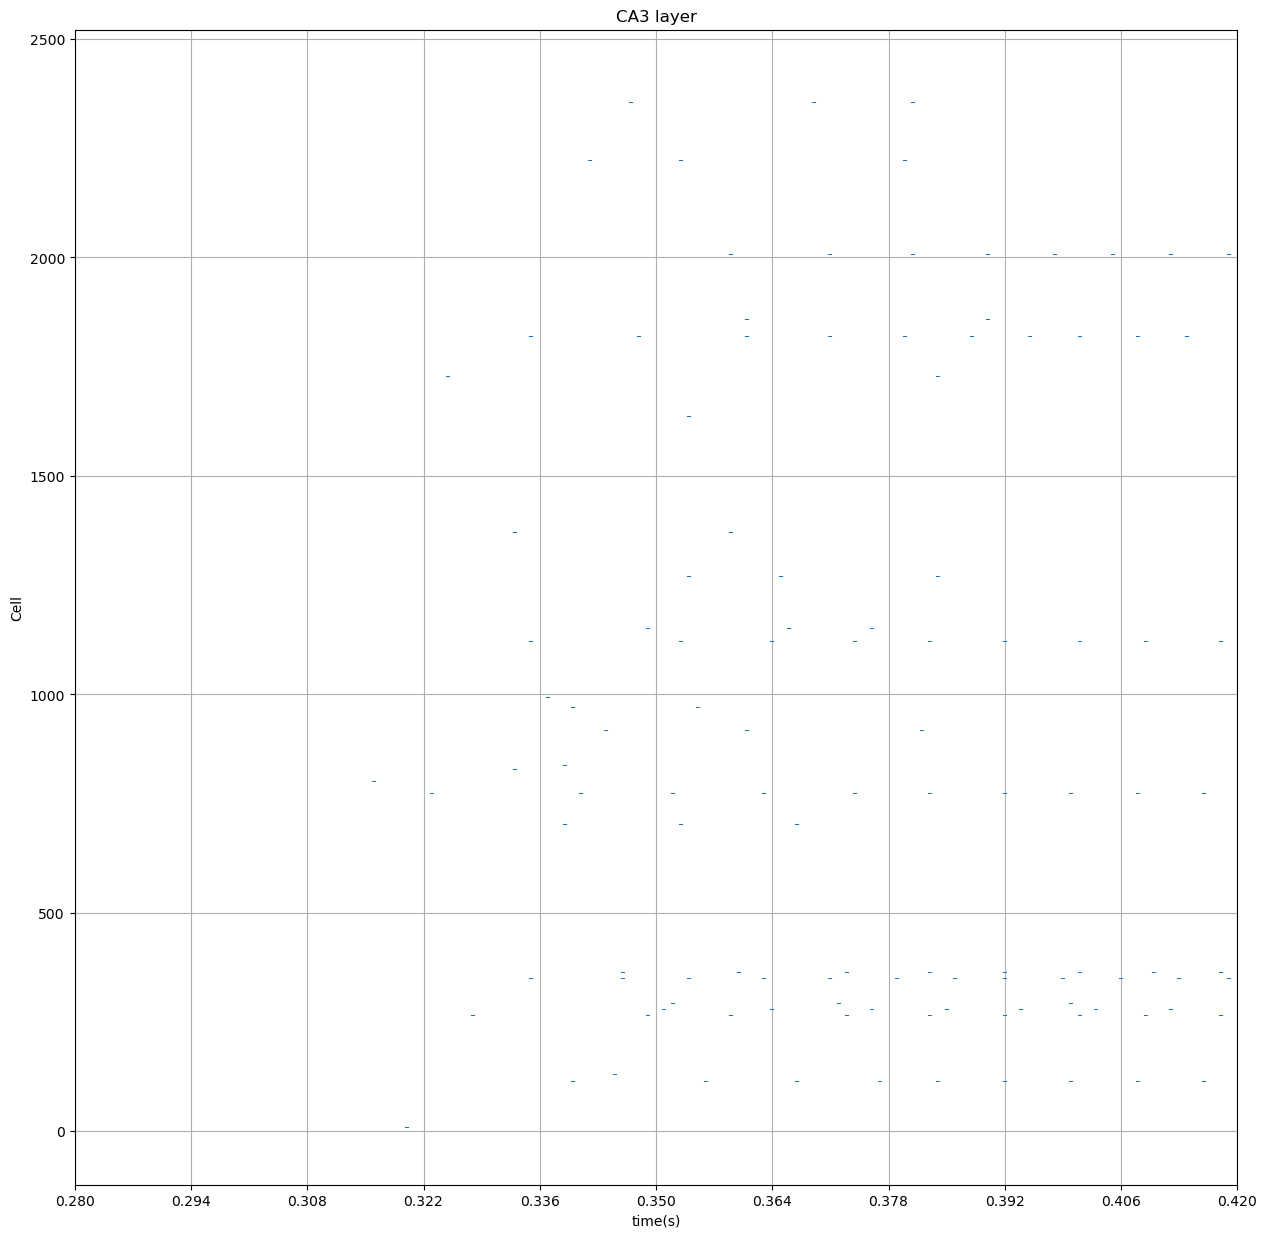

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


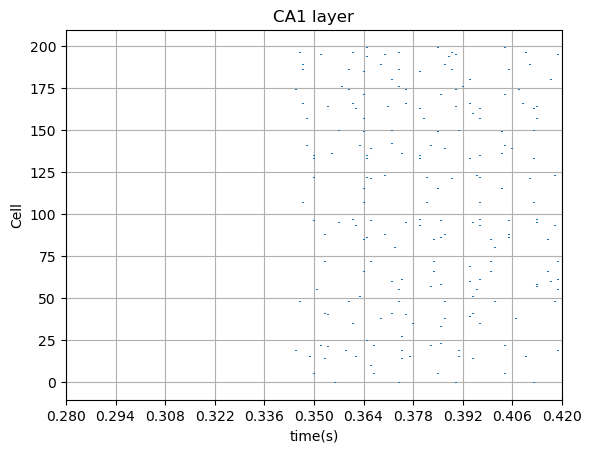

Ret1 :  {8, 801, 773, 557}
Ret2 :  {131, 773, 265, 918, 1819, 557, 2221, 2355, 828, 1727, 703, 837, 971, 1882, 1371, 349, 993, 1122, 364, 114, 1150}
Ret3 :  {773, 265, 278, 918, 1819, 292, 557, 2221, 1969, 2355, 703, 1857, 971, 2007, 1371, 349, 1122, 1635, 1637, 364, 114, 1270, 1150}
Rc :  {1857, 1122, 292, 773, 265, 1770, 364, 2221, 114, 2007, 2355, 278, 918, 1270, 1819, 349, 1150, 1727}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 497 [402]
0 548 [1921]


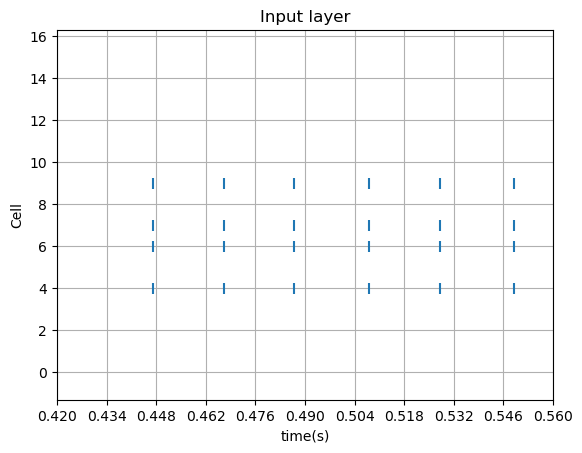

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


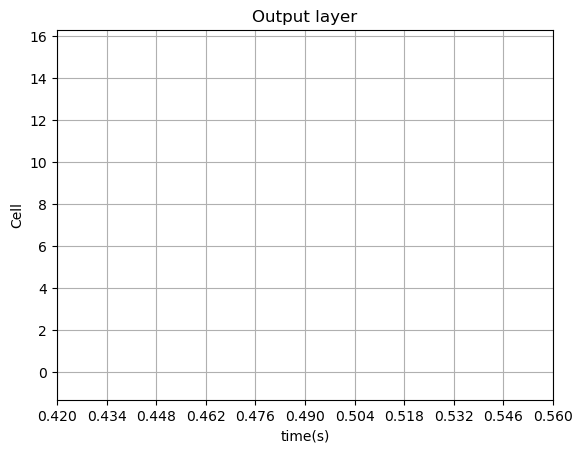

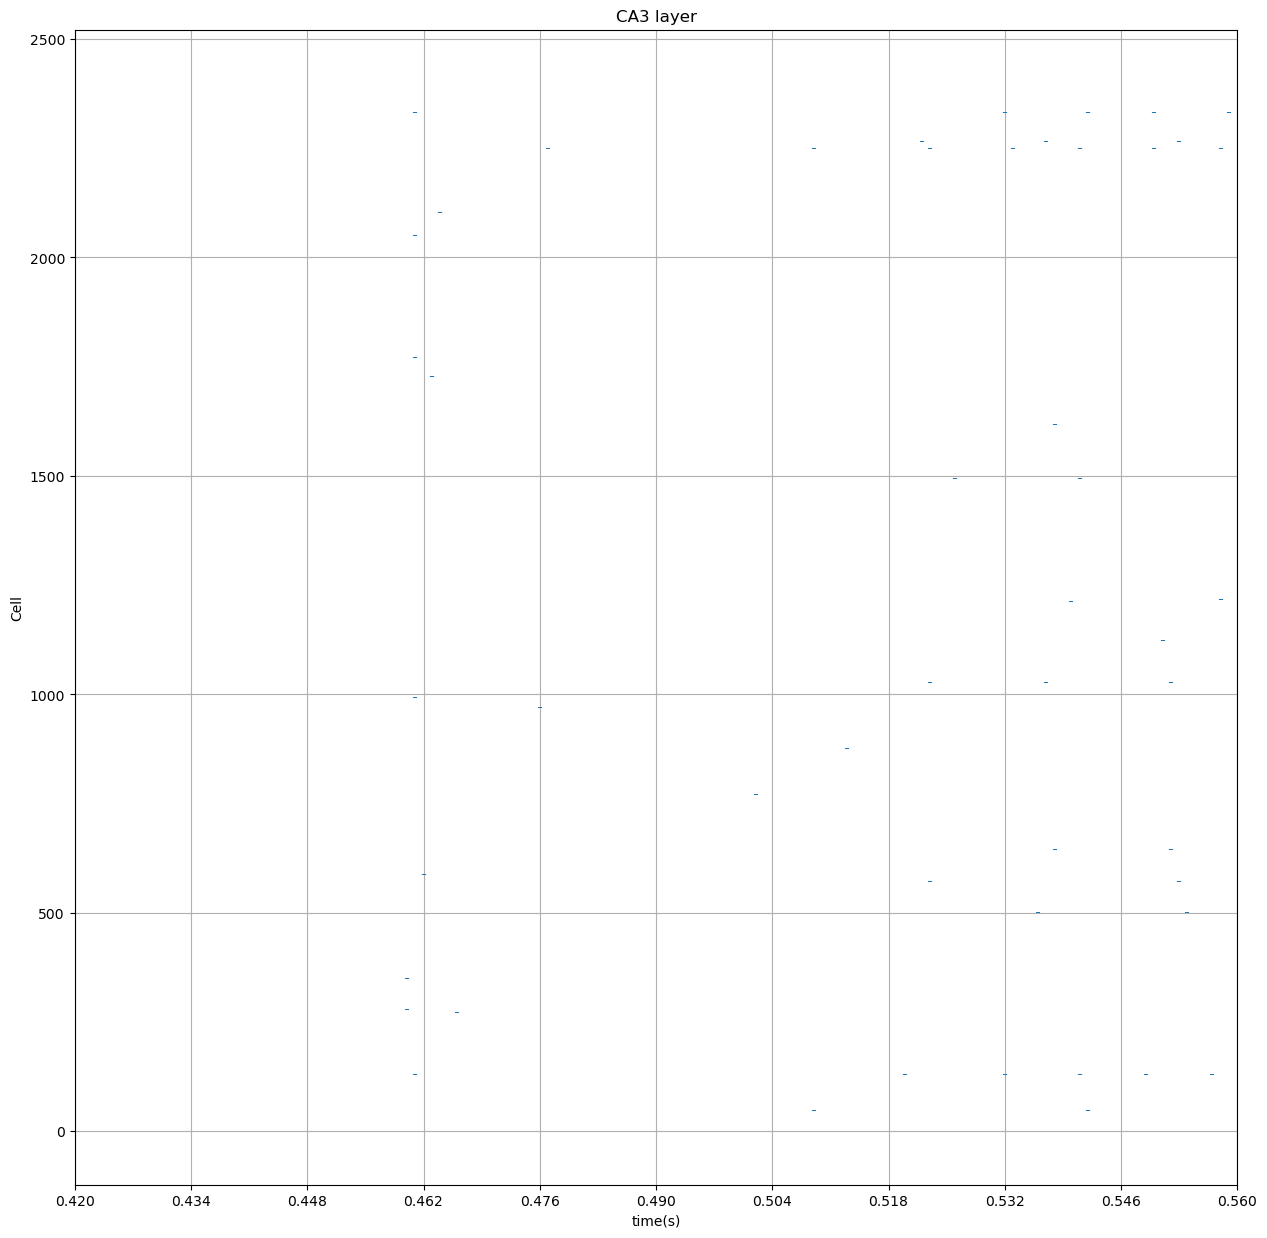

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


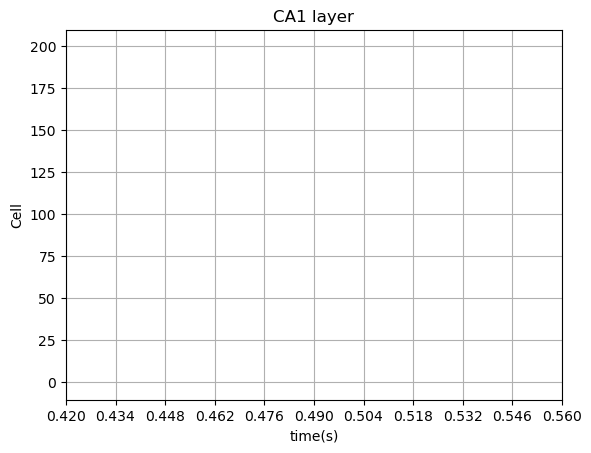

Ret1 :  {225, 993, 131, 2051, 1223, 588, 1772, 278, 2102, 2332, 349, 1727}
Ret2 :  {272, 2249, 971}
Ret3 :  {770, 1637, 2249, 876, 48}
Rc :  {827, 1218, 131, 1028, 645, 1124, 1637, 2249, 48, 1617, 501, 1494, 1271, 2332, 2265, 571, 1212}
intersection with 5 :  {2051}
---------------------------------------------------------------------------------
0 615 [344]
0 633 [402]


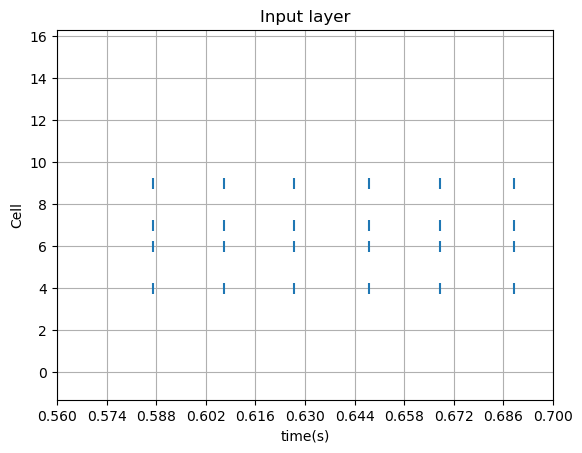

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


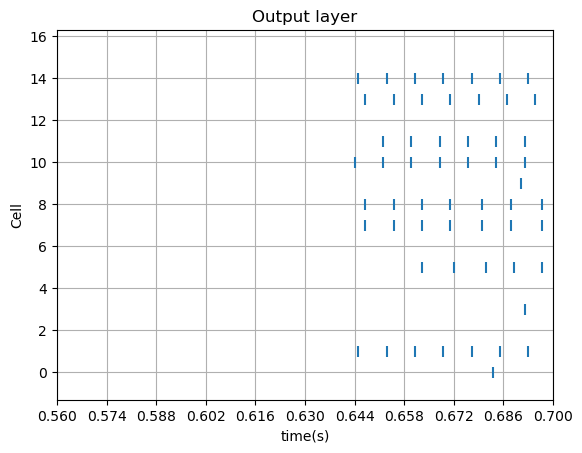

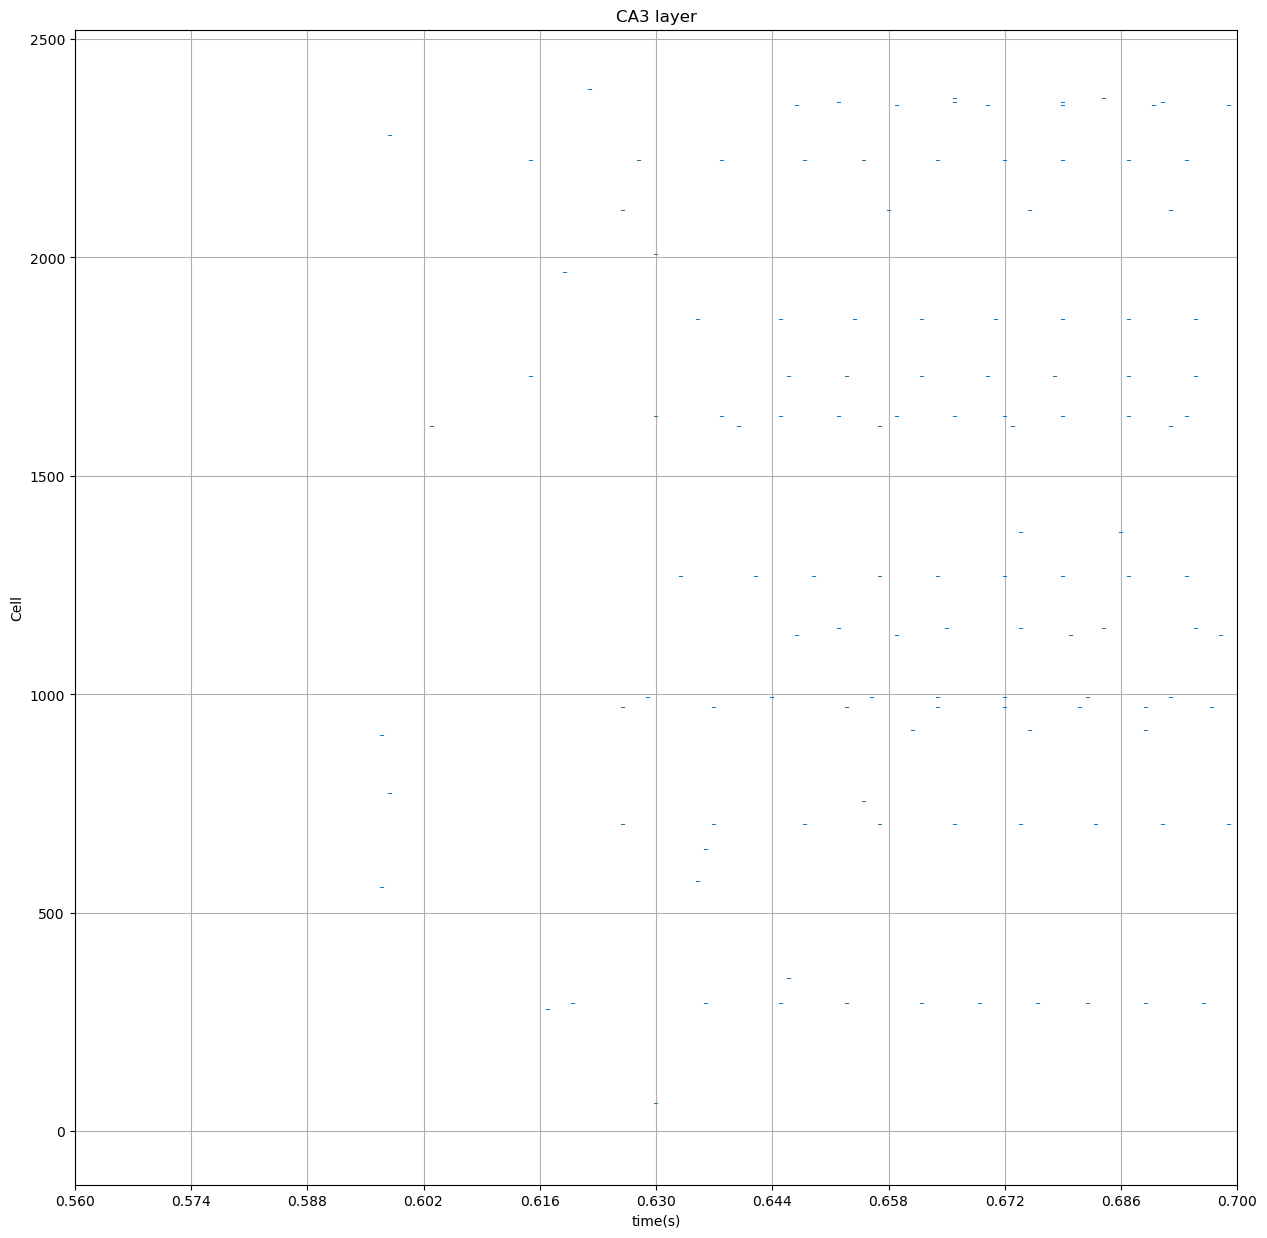

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


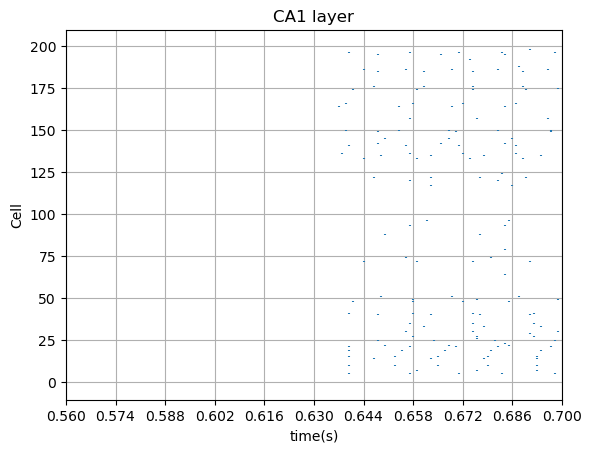

Ret1 :  {773, 2279, 906, 1614, 558}
Ret2 :  {993, 292, 971, 2221, 1966, 1727, 2385, 278, 2108, 733, 703}
Ret3 :  {645, 292, 2347, 2221, 2355, 571, 703, 1727, 1857, 63, 1605, 971, 1614, 2007, 349, 993, 1635, 1134, 1270, 1150}
Rc :  {918, 292, 2347, 557, 2221, 2355, 2108, 2364, 1727, 703, 1857, 1605, 971, 1614, 1371, 993, 1635, 1134, 754, 1270, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 728 [885]
0 782 [1930]
0 799 [237]


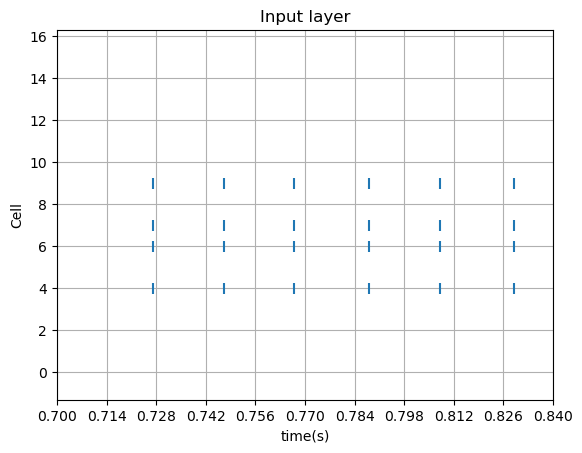

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


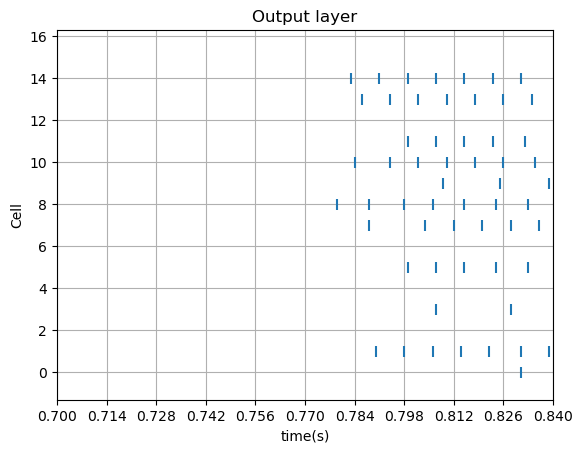

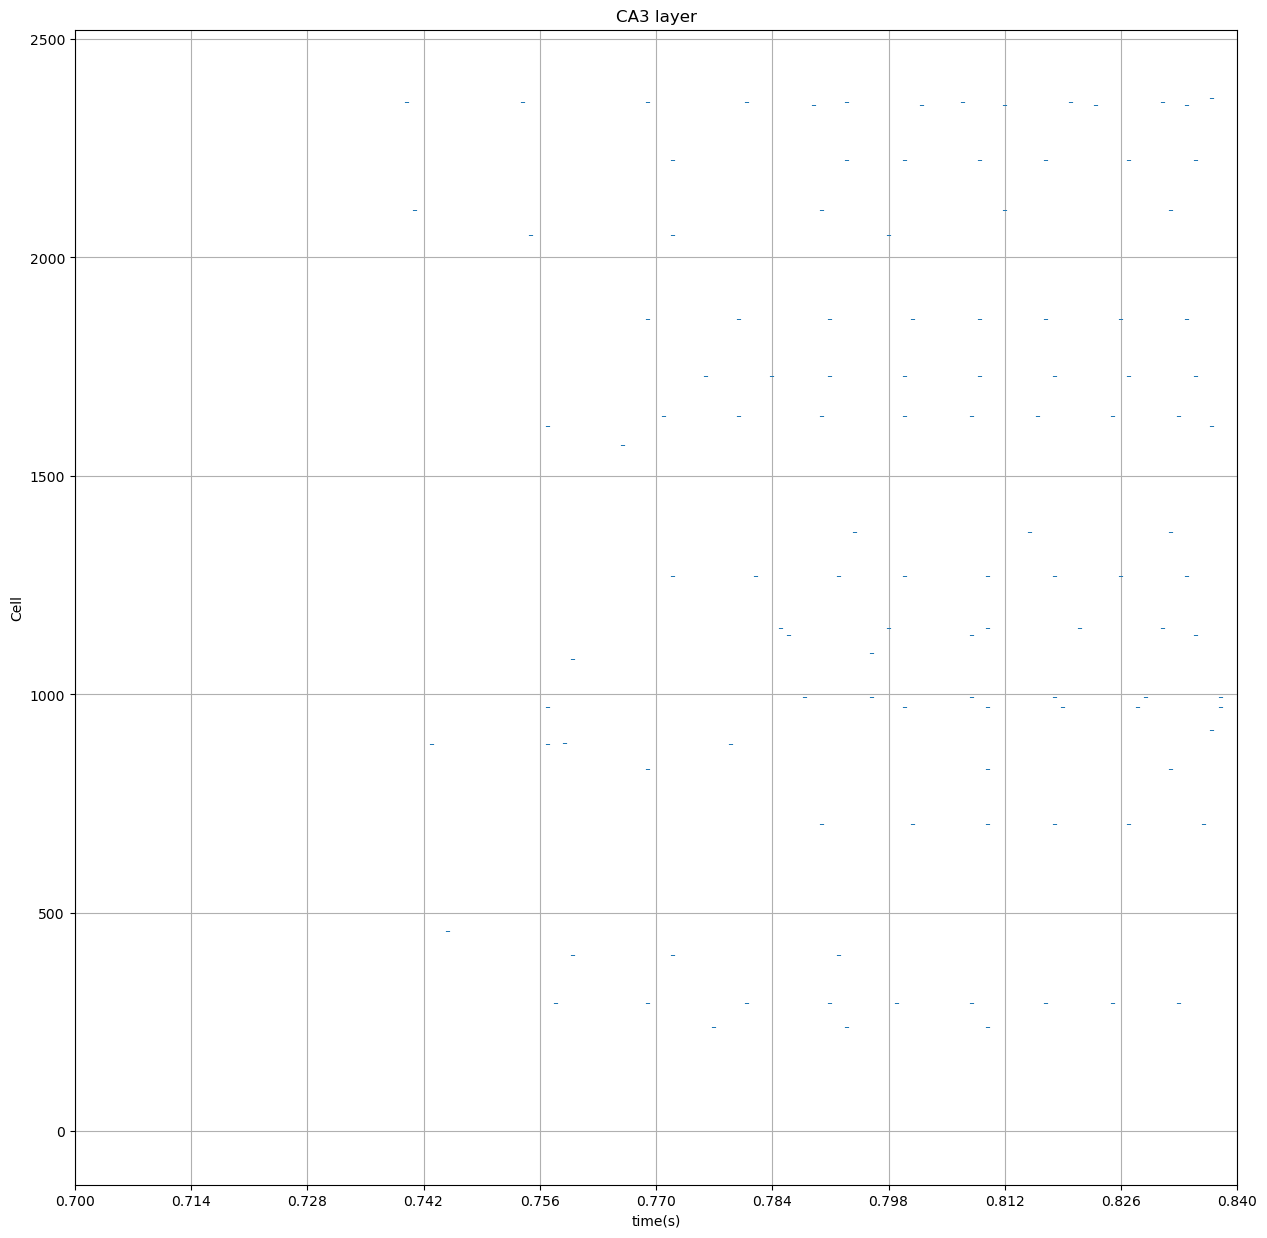

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


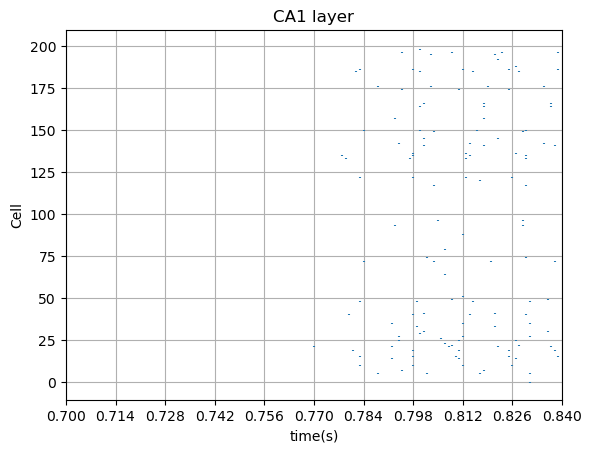

Ret1 :  {2355, 2108, 885}
Ret2 :  {1857, 1570, 2051, 292, 457, 971, 557, 1614, 402, 2355, 885, 888, 1080, 828}
Ret3 :  {2051, 402, 292, 2347, 557, 2221, 2355, 2108, 1727, 703, 1857, 1605, 1371, 993, 1635, 237, 1134, 885, 1270, 1150}
Rc :  {2051, 918, 292, 2347, 557, 2221, 2355, 828, 2108, 2364, 1727, 703, 1857, 1605, 1094, 971, 1614, 1371, 993, 1635, 1770, 237, 1134, 1270, 1150}
intersection with 5 :  {2051, 1094, 237, 402, 885, 1080}
---------------------------------------------------------------------------------
0 897 [1930]
0 902 [344]
0 919 [237]


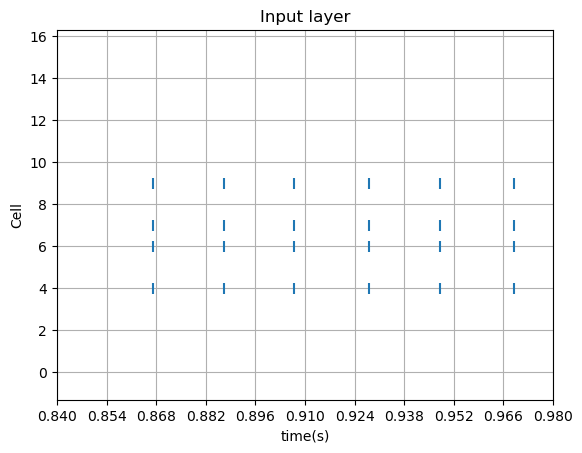

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


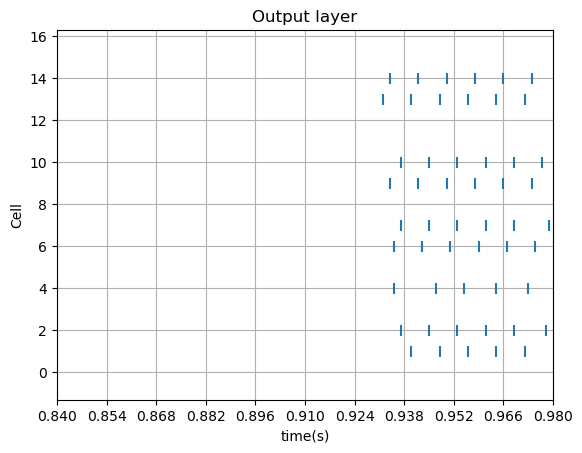

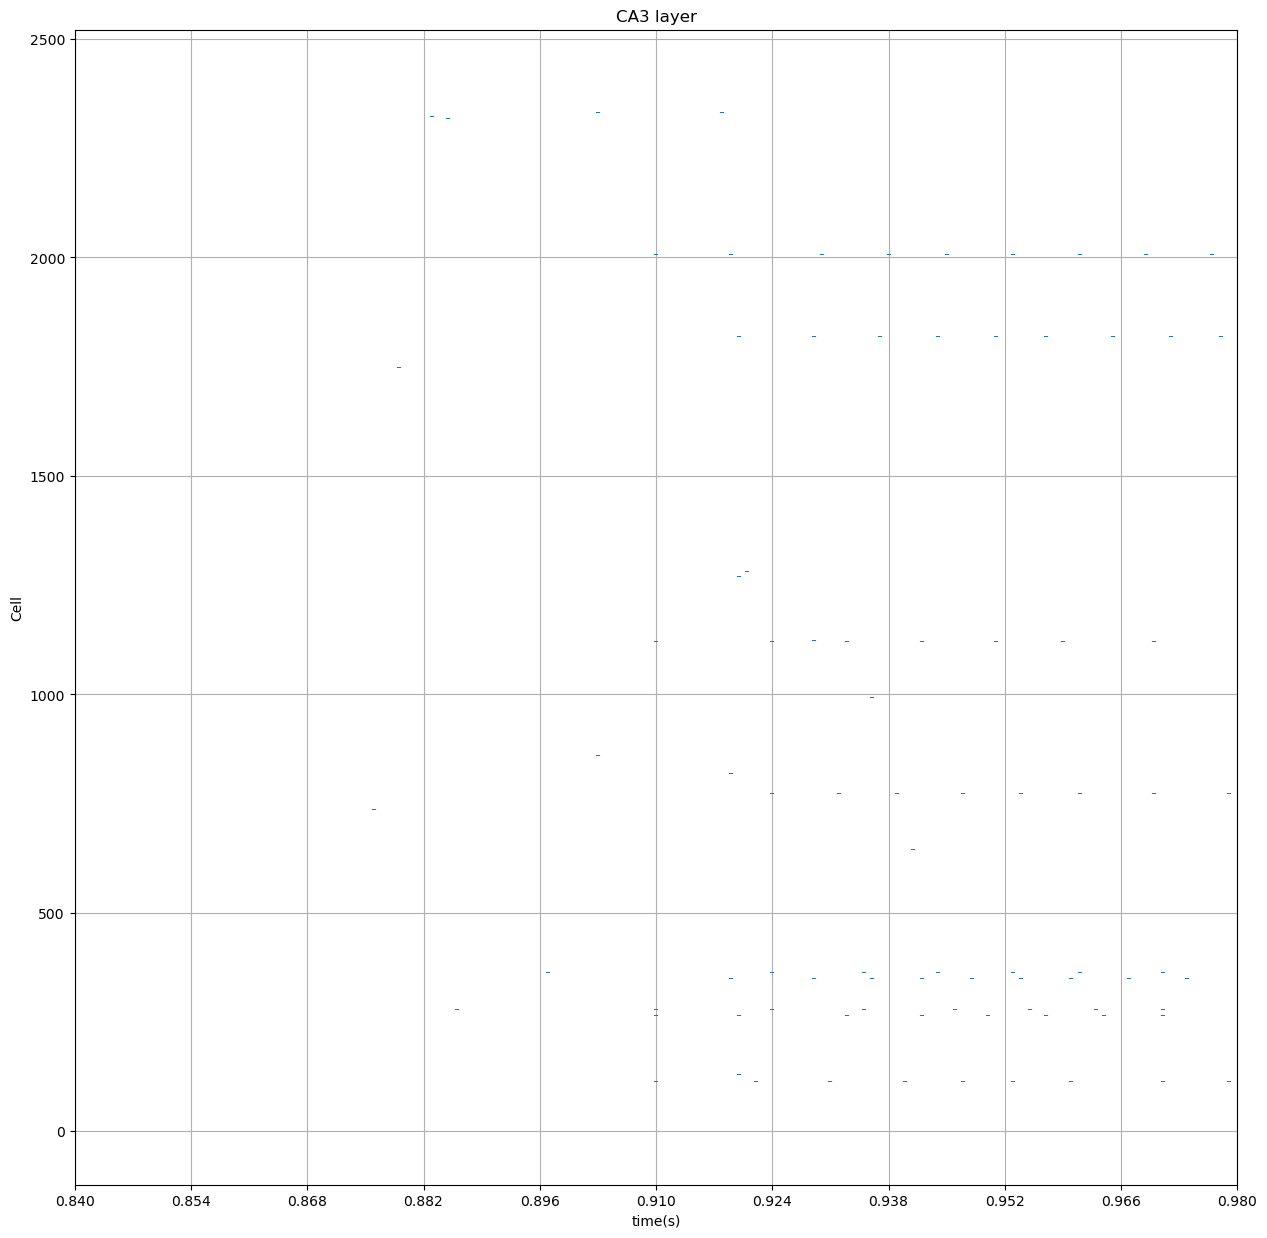

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


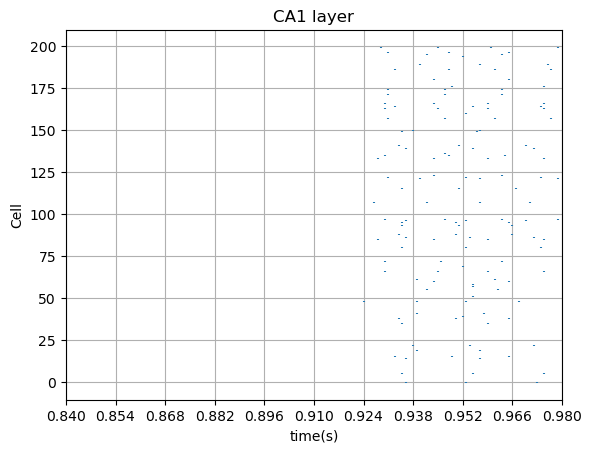

Ret1 :  {736, 2322, 1749}
Ret2 :  {364, 2317, 279, 2332, 861}
Ret3 :  {1819, 1281, 1122, 131, 1124, 773, 265, 364, 114, 818, 2007, 278, 1270, 1271, 2332, 349}
Rc :  {993, 1122, 645, 773, 265, 364, 114, 278, 2007, 1819, 349}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 1012 [2051]
0 1020 [1094]


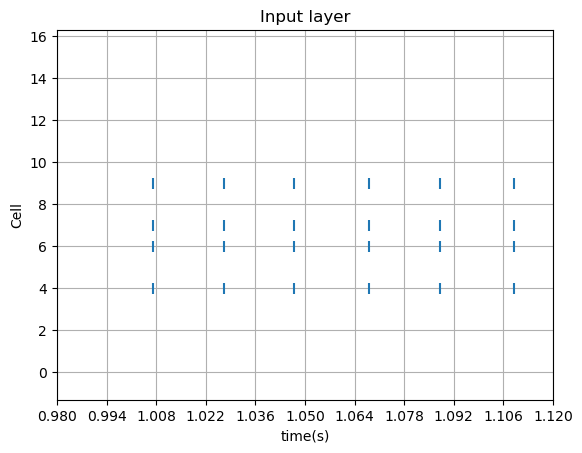

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


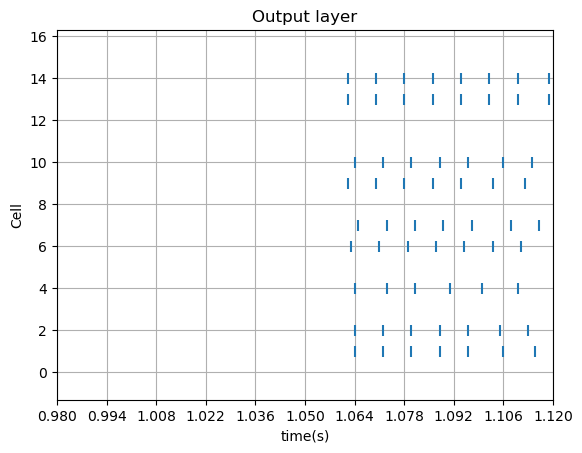

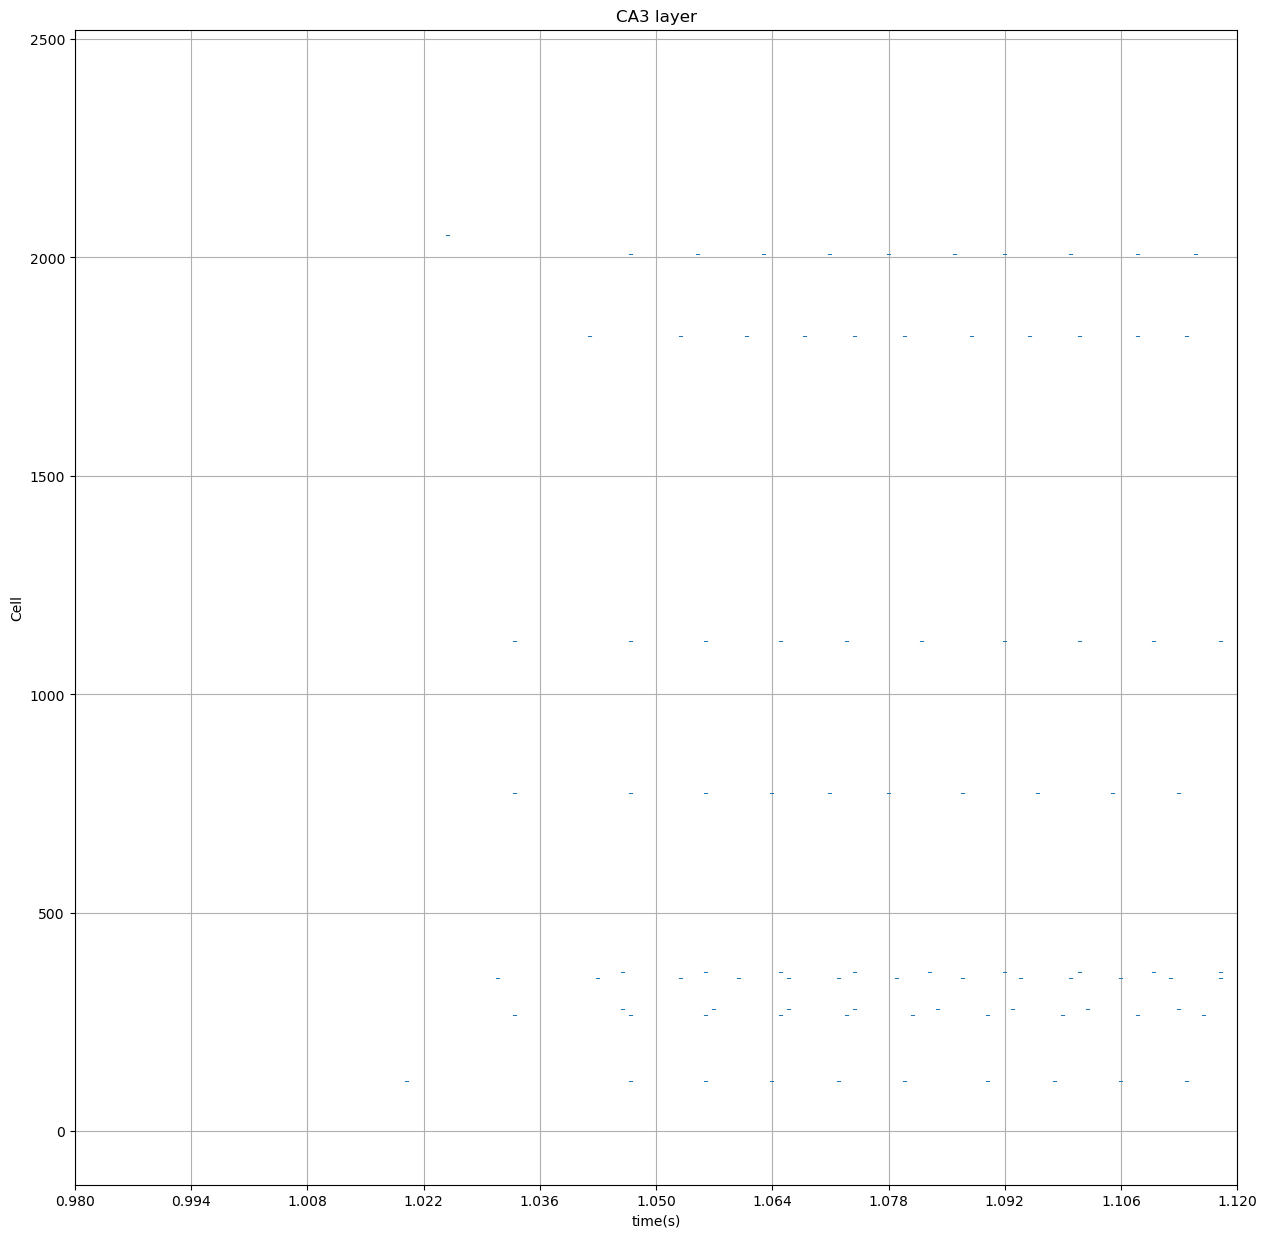

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


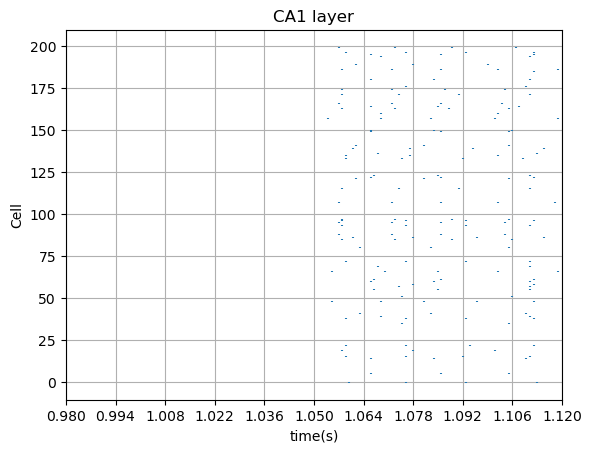

Ret1 :  {114}
Ret2 :  {1122, 2051, 773, 265, 364, 114, 278, 2007, 1819, 349}
Ret3 :  {1122, 773, 265, 364, 114, 278, 2007, 1819, 349}
Rc :  {1122, 773, 265, 364, 114, 278, 2007, 1819, 349}
intersection with 5 :  {2051}
---------------------------------------------------------------------------------
0 1206 [344]
0 1213 [2051]
0 1218 [1921]
0 1244 [1921]


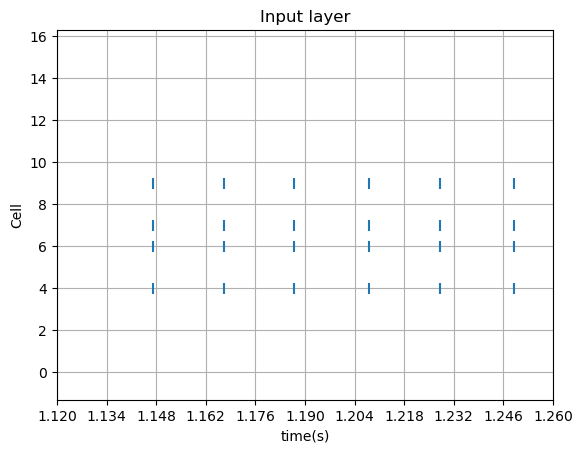

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


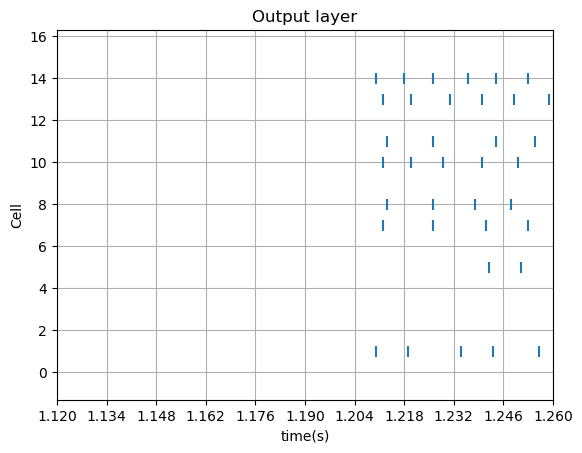

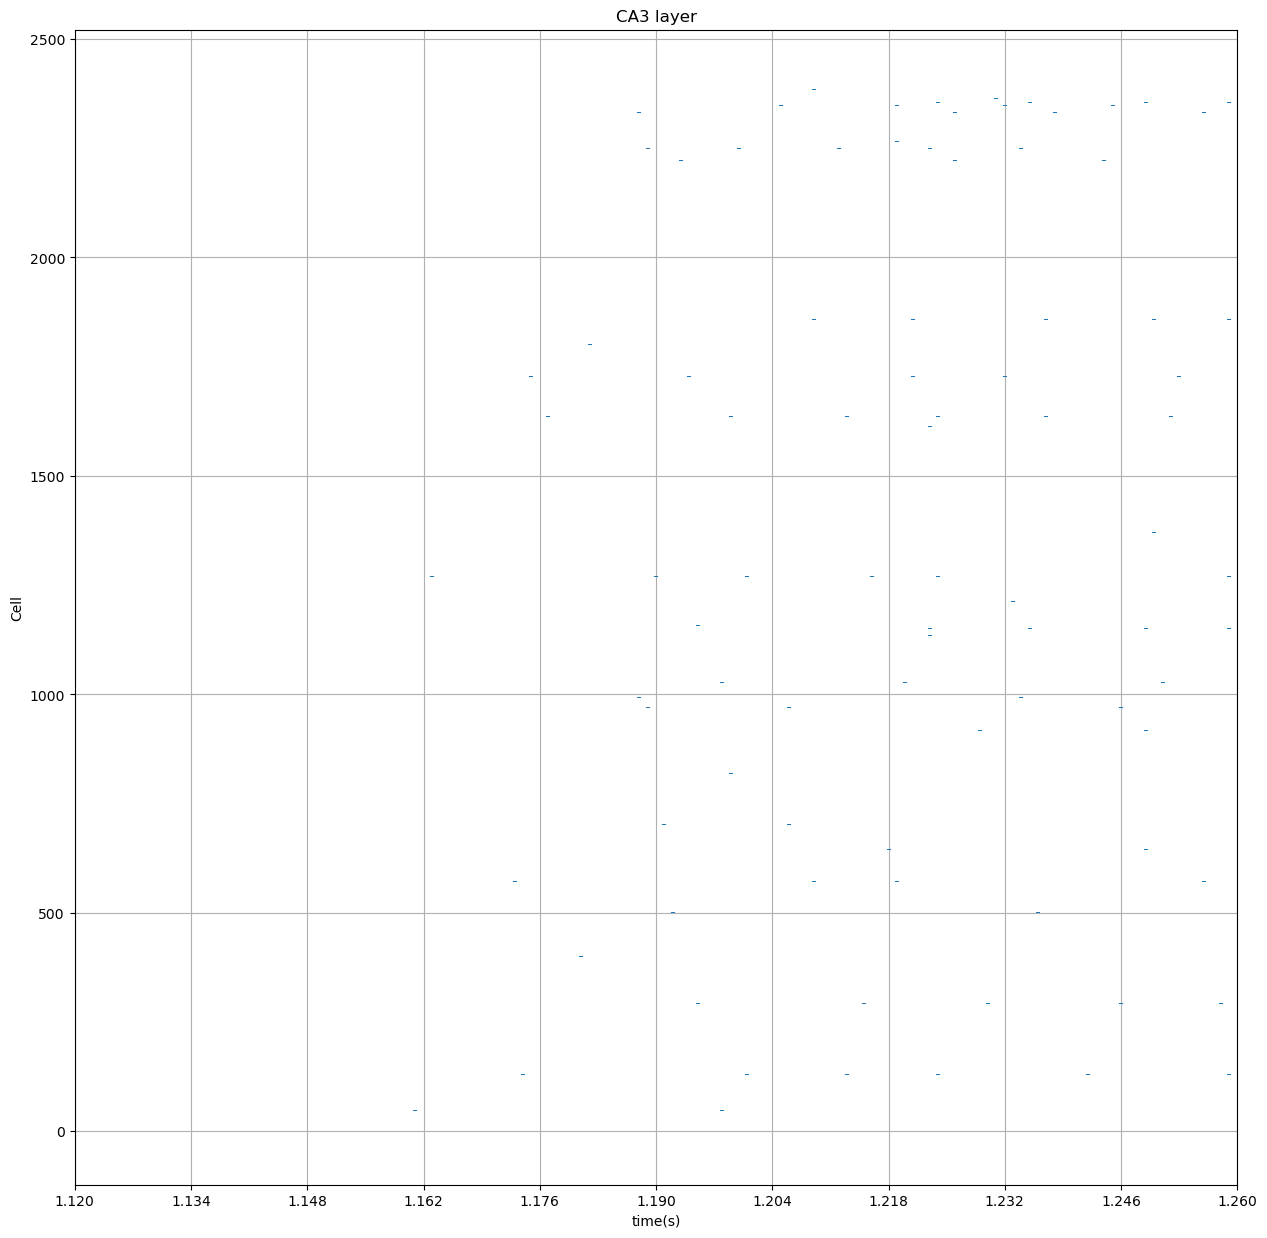

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


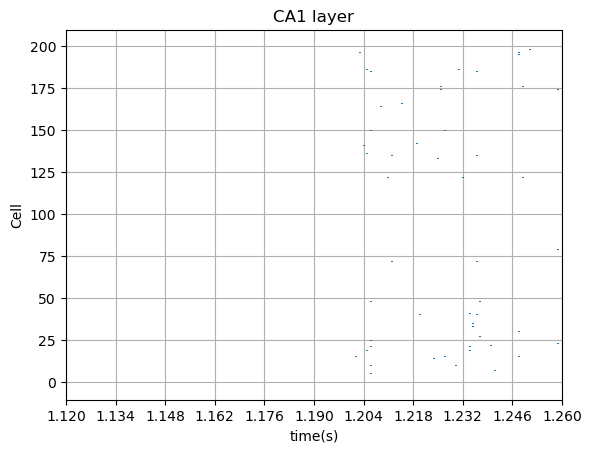

Ret1 :  {48, 1270}
Ret2 :  {993, 131, 1635, 1605, 1637, 1801, 2249, 971, 621, 401, 571, 2332, 1727}
Ret3 :  {131, 1028, 1158, 292, 2347, 2221, 48, 818, 827, 571, 1727, 703, 1857, 1605, 2249, 971, 2385, 1635, 501, 1270, 1271}
Rc :  {131, 1028, 645, 918, 2332, 292, 2347, 557, 2221, 2355, 827, 571, 1212, 2364, 1727, 1857, 1605, 2249, 971, 1614, 2265, 1371, 993, 1635, 1637, 1134, 501, 1270, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 1323 [885]
0 1332 [344]
0 1351 [2051]
0 1367 [1930]
0 1399 [1921]


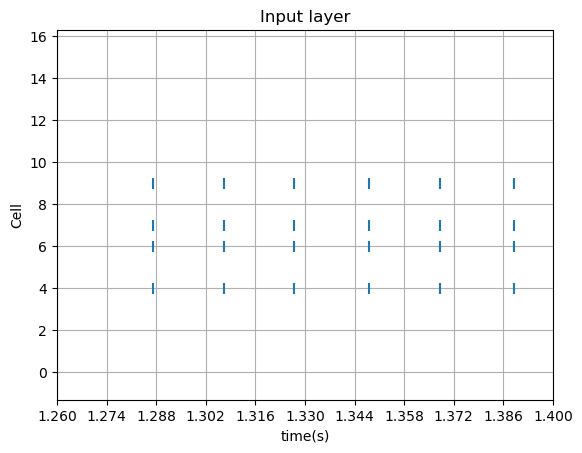

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


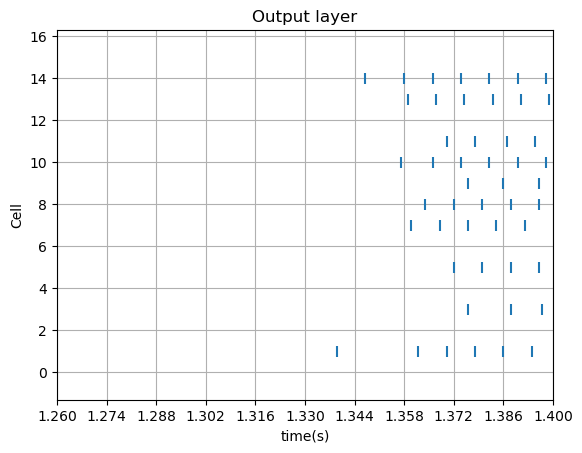

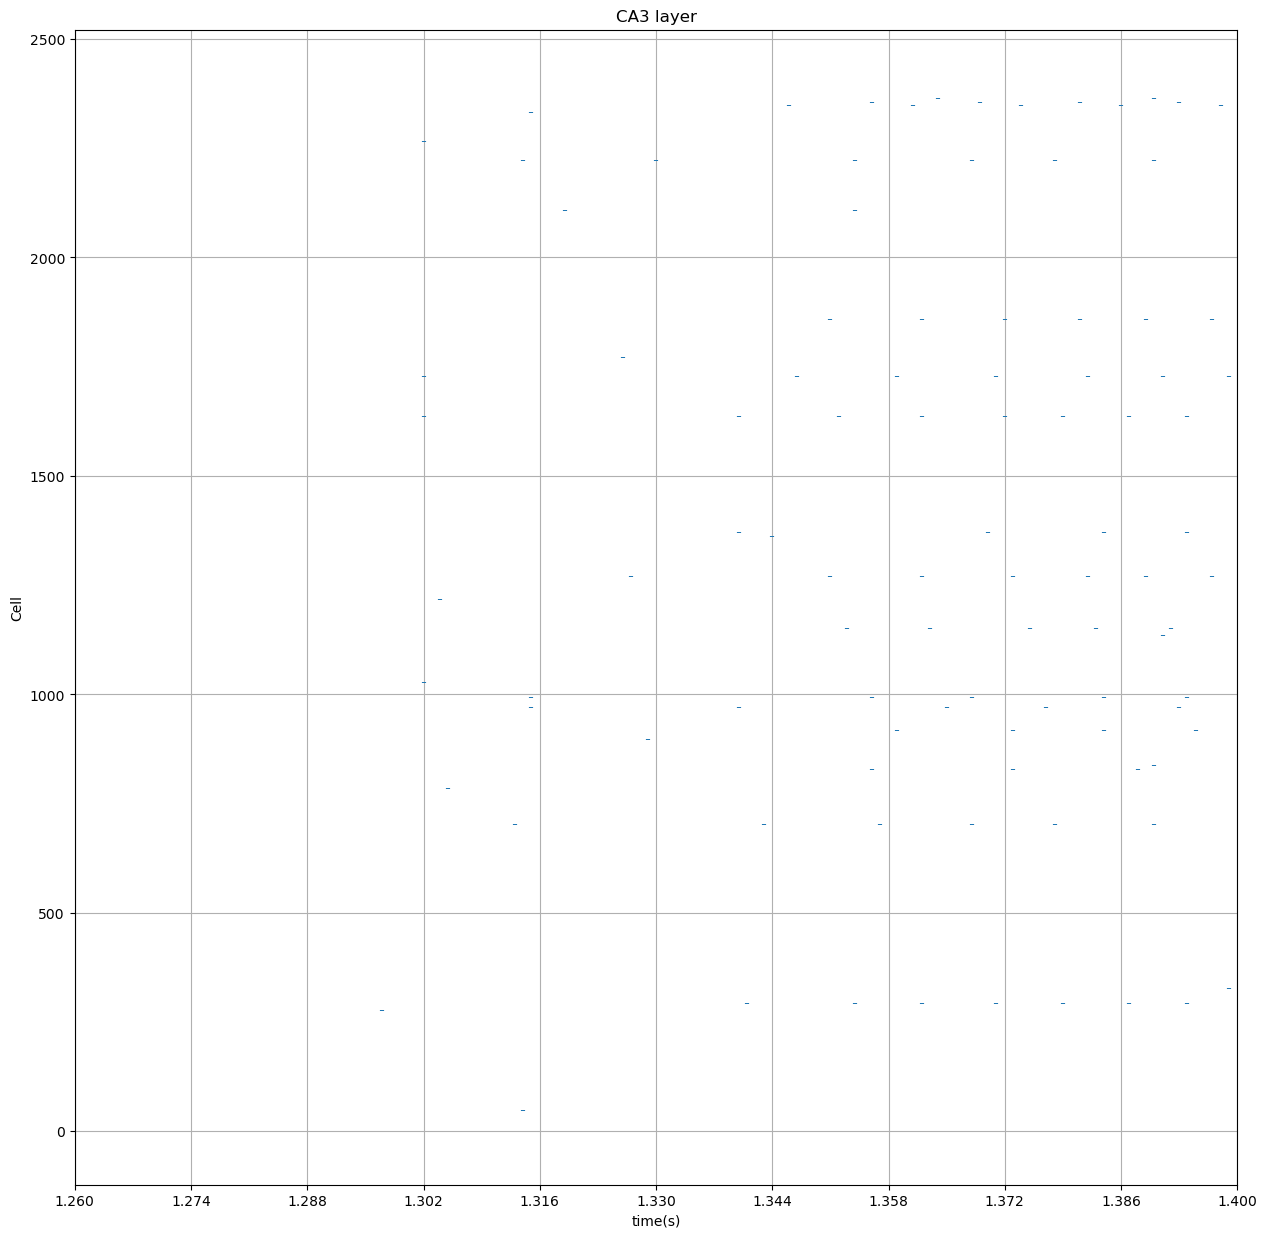

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


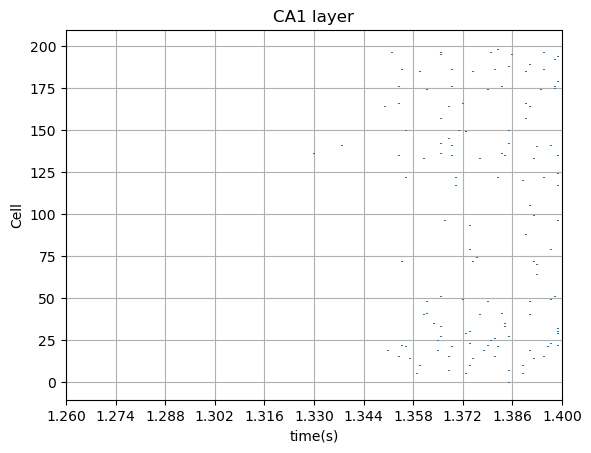

Ret1 :  {1218, 1635, 1028, 276, 2265, 1727}
Ret2 :  {896, 993, 971, 1772, 2221, 48, 785, 2332, 1270, 2108, 703}
Ret3 :  {1857, 1635, 292, 1605, 971, 2347, 2221, 1727, 1362, 1270, 1371, 2108, 1150, 703}
Rc :  {918, 292, 2347, 557, 2221, 2355, 828, 2364, 1727, 703, 1857, 837, 1605, 327, 971, 1371, 993, 1635, 1770, 1134, 1270, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 1503 [1921]
0 1507 [402]


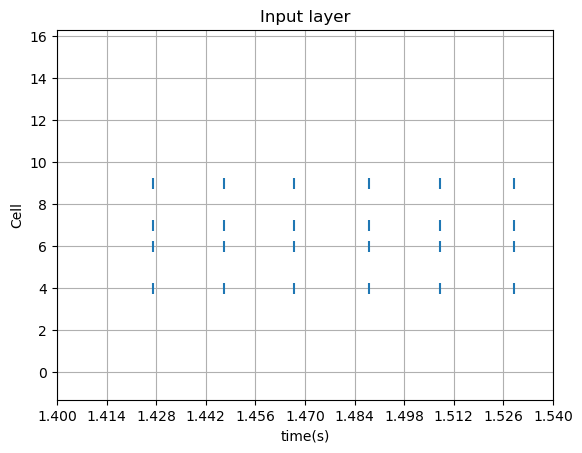

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


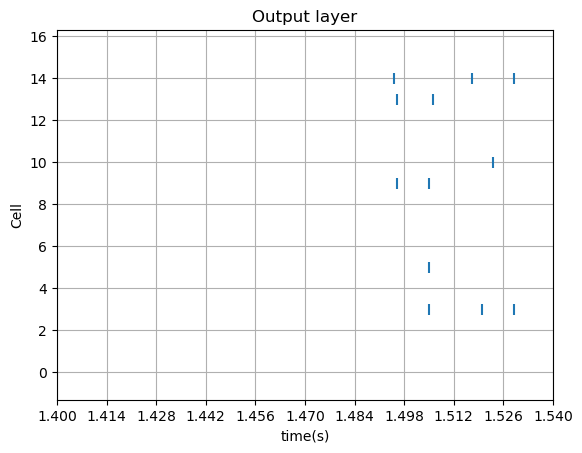

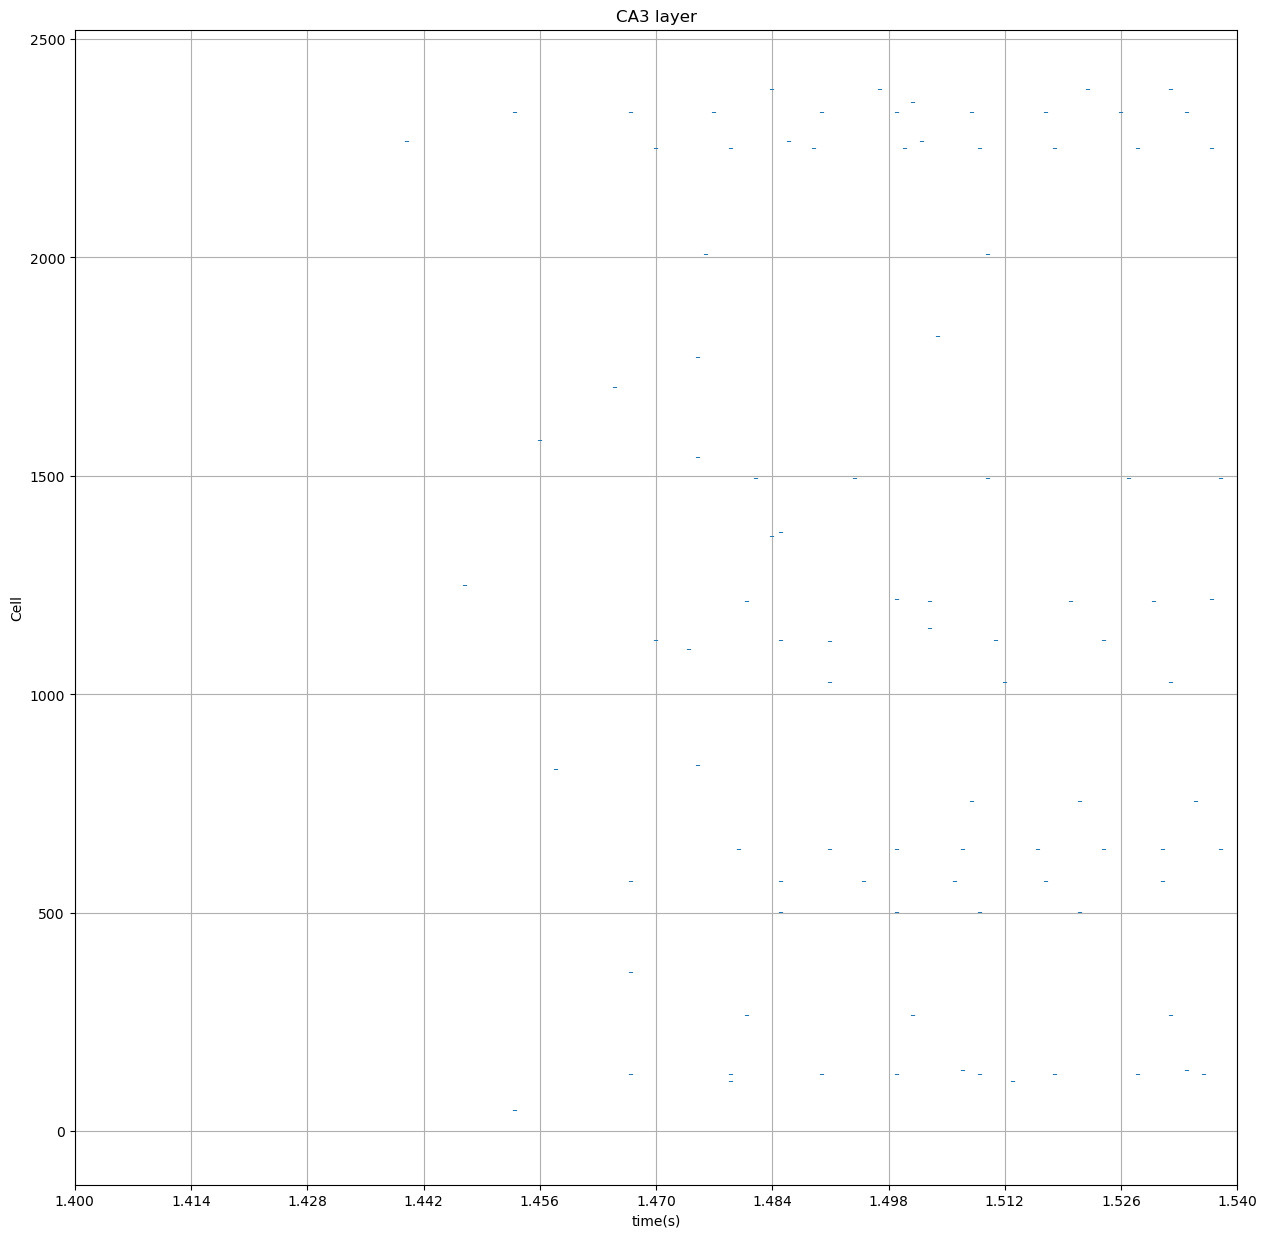

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


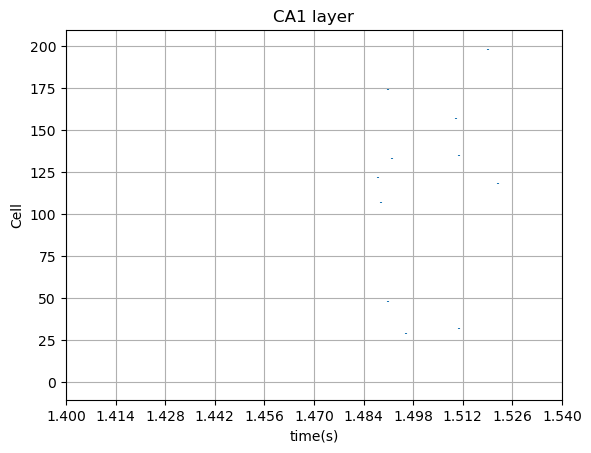

Ret1 :  {161, 2265, 1477}
Ret2 :  {1250, 131, 1637, 1702, 364, 1582, 48, 2332, 571, 828}
Ret3 :  {131, 1028, 645, 1542, 265, 2332, 557, 827, 571, 1212, 837, 2249, 1103, 2385, 1362, 1494, 2007, 2265, 1371, 1122, 1124, 1637, 1772, 114, 501, 1271}
Rc :  {131, 1028, 645, 265, 140, 1819, 2332, 2355, 827, 571, 1212, 1218, 2249, 2385, 1494, 2007, 2265, 1124, 1637, 114, 754, 501, 1271, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 1618 [2051]


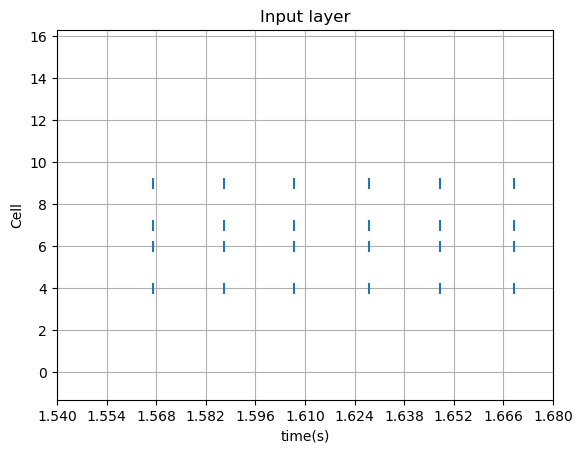

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


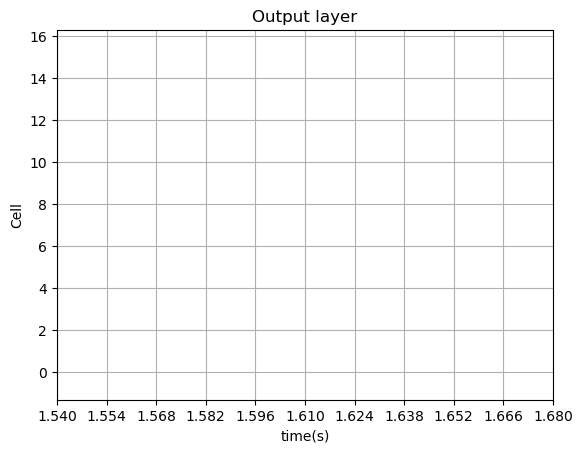

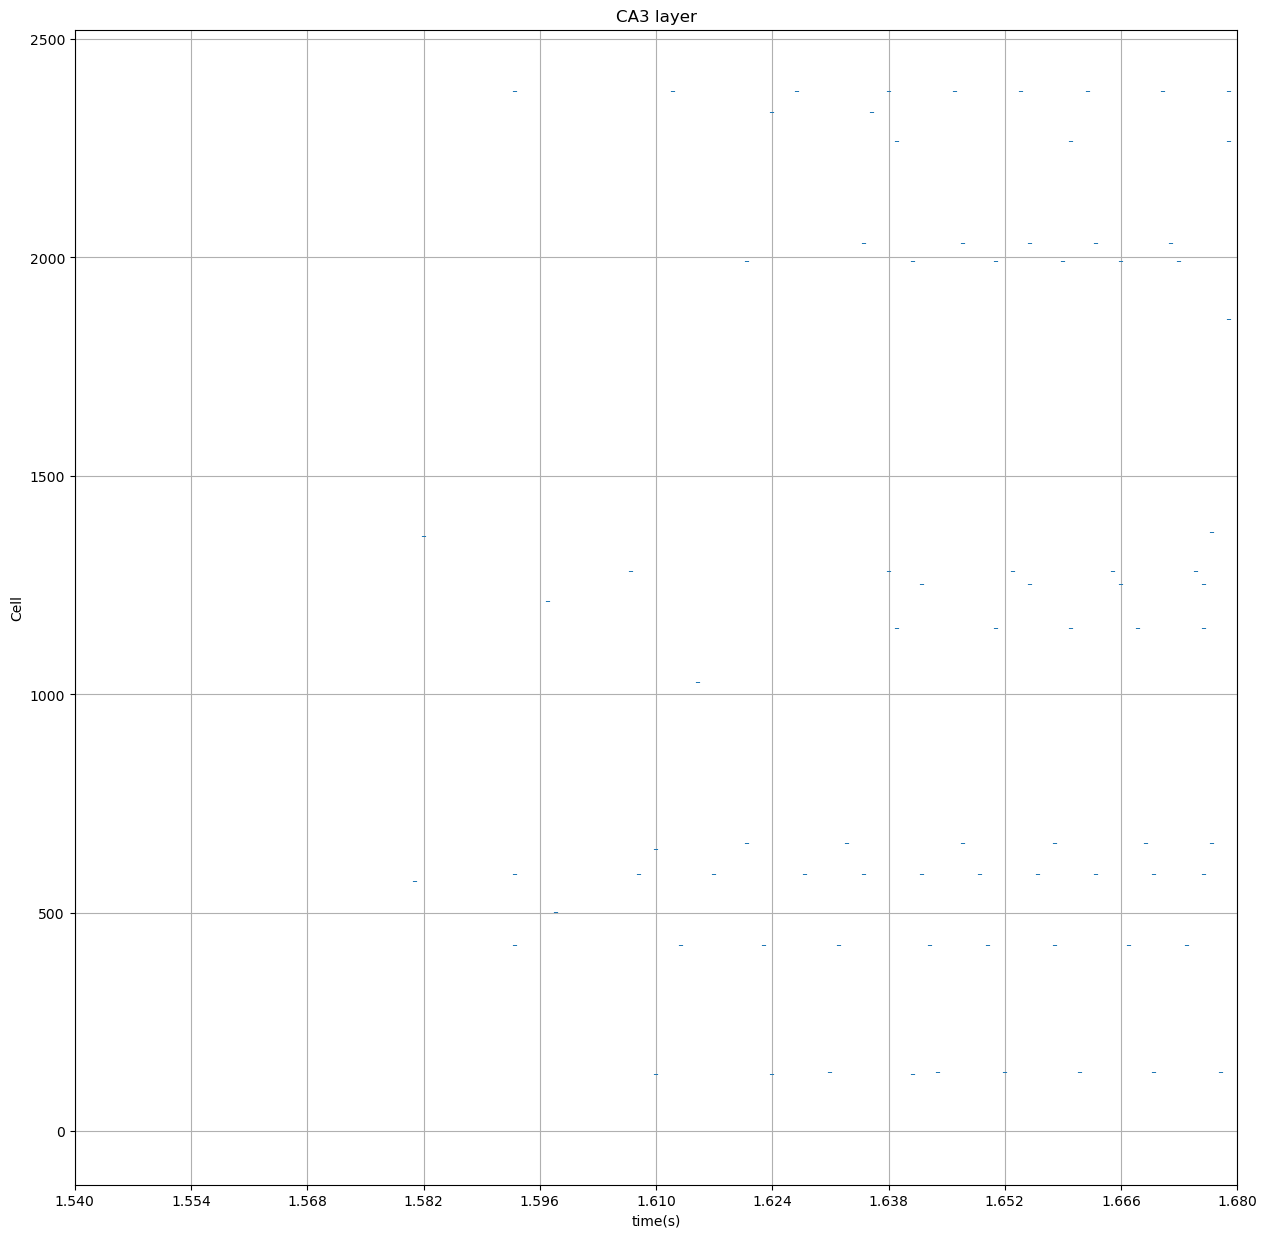

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


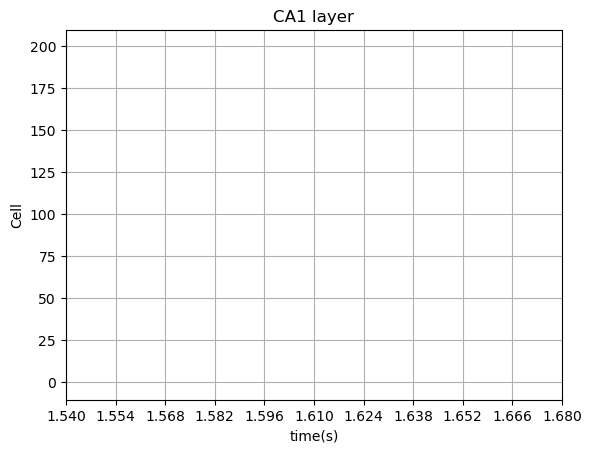

Ret1 :  {1362, 571, 1374}
Ret2 :  {1281, 1637, 425, 588, 2380, 501, 1212, 1374}
Ret3 :  {131, 1028, 645, 134, 1637, 1991, 425, 588, 2380, 1969, 658, 1882, 2332, 1374}
Rc :  {1281, 1374, 131, 1251, 1857, 134, 1991, 425, 2266, 588, 2380, 2031, 1969, 658, 1882, 1371, 2332, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 1708 [2051]
0 1709 [885]
0 1729 [1080]
0 1730 [1094]


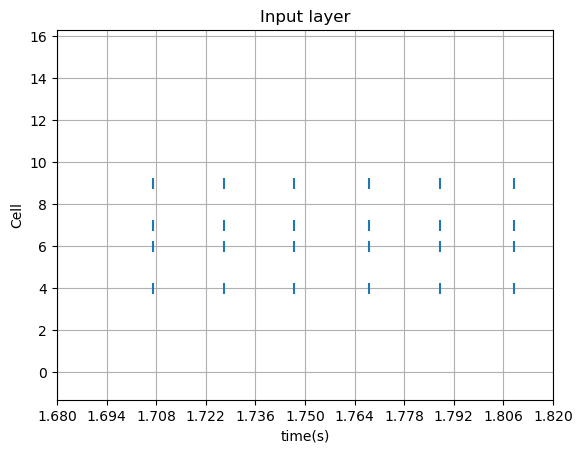

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


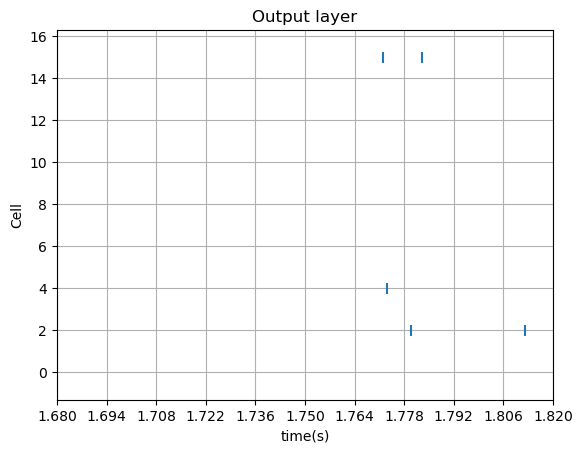

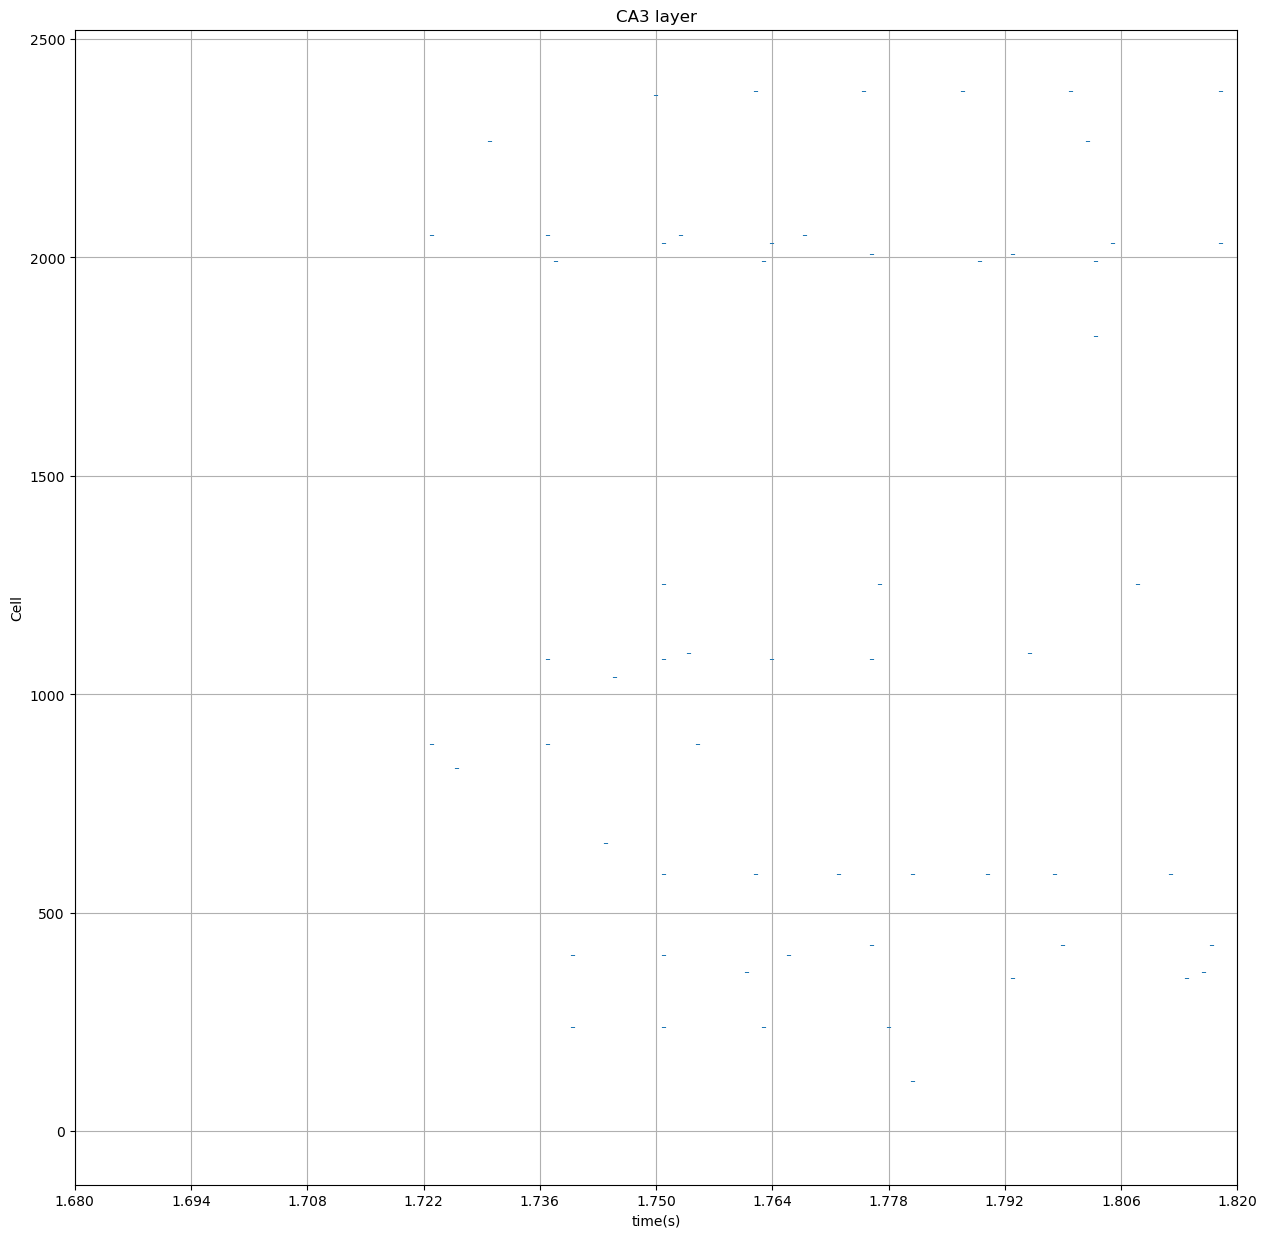

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


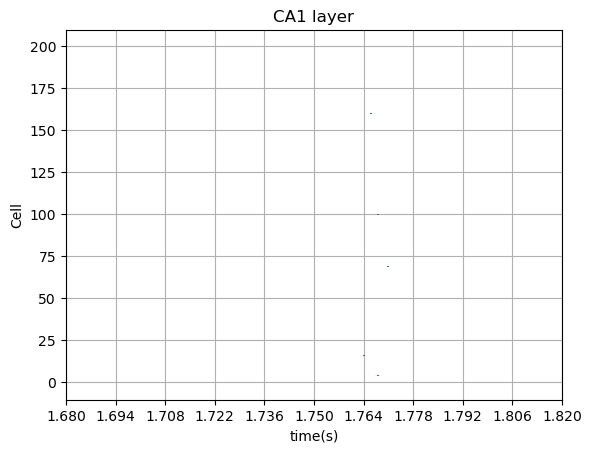

Ret1 :  {2051, 885}
Ret2 :  {2051, 1991, 237, 1039, 402, 658, 885, 1080, 2266, 830}
Ret3 :  {1921, 2370, 1251, 2051, 1094, 1991, 1930, 364, 237, 588, 2031, 2380, 402, 885, 1080, 1882, 1374}
Rc :  {1921, 1819, 425, 1969, 1080, 1094, 1991, 588, 2380, 2007, 2266, 1882, 349, 1374, 1251, 364, 237, 2031, 114}
intersection with 5 :  {1921, 2051, 1094, 1930, 237, 402, 885, 1080}
---------------------------------------------------------------------------------
0 1875 [2051]
0 1930 [344]
0 1950 [1930]


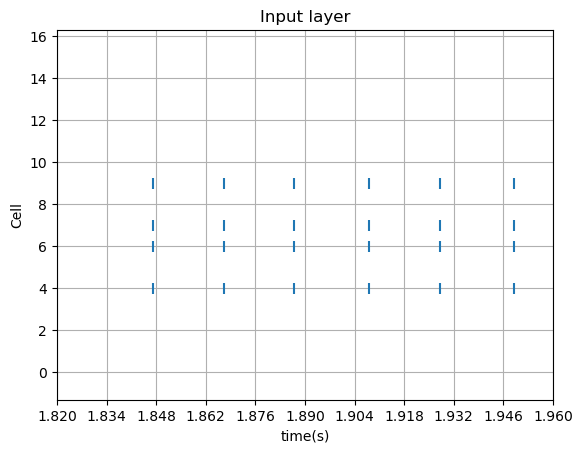

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


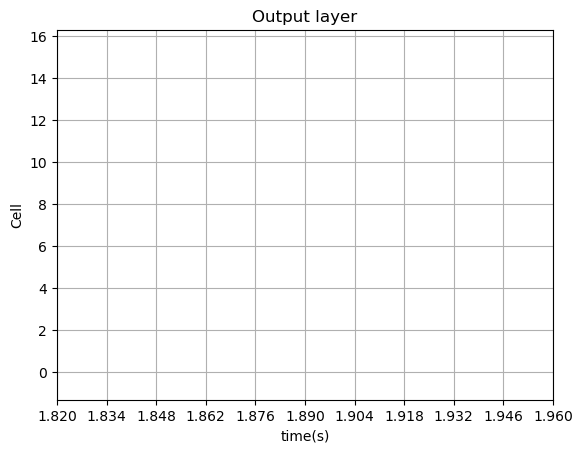

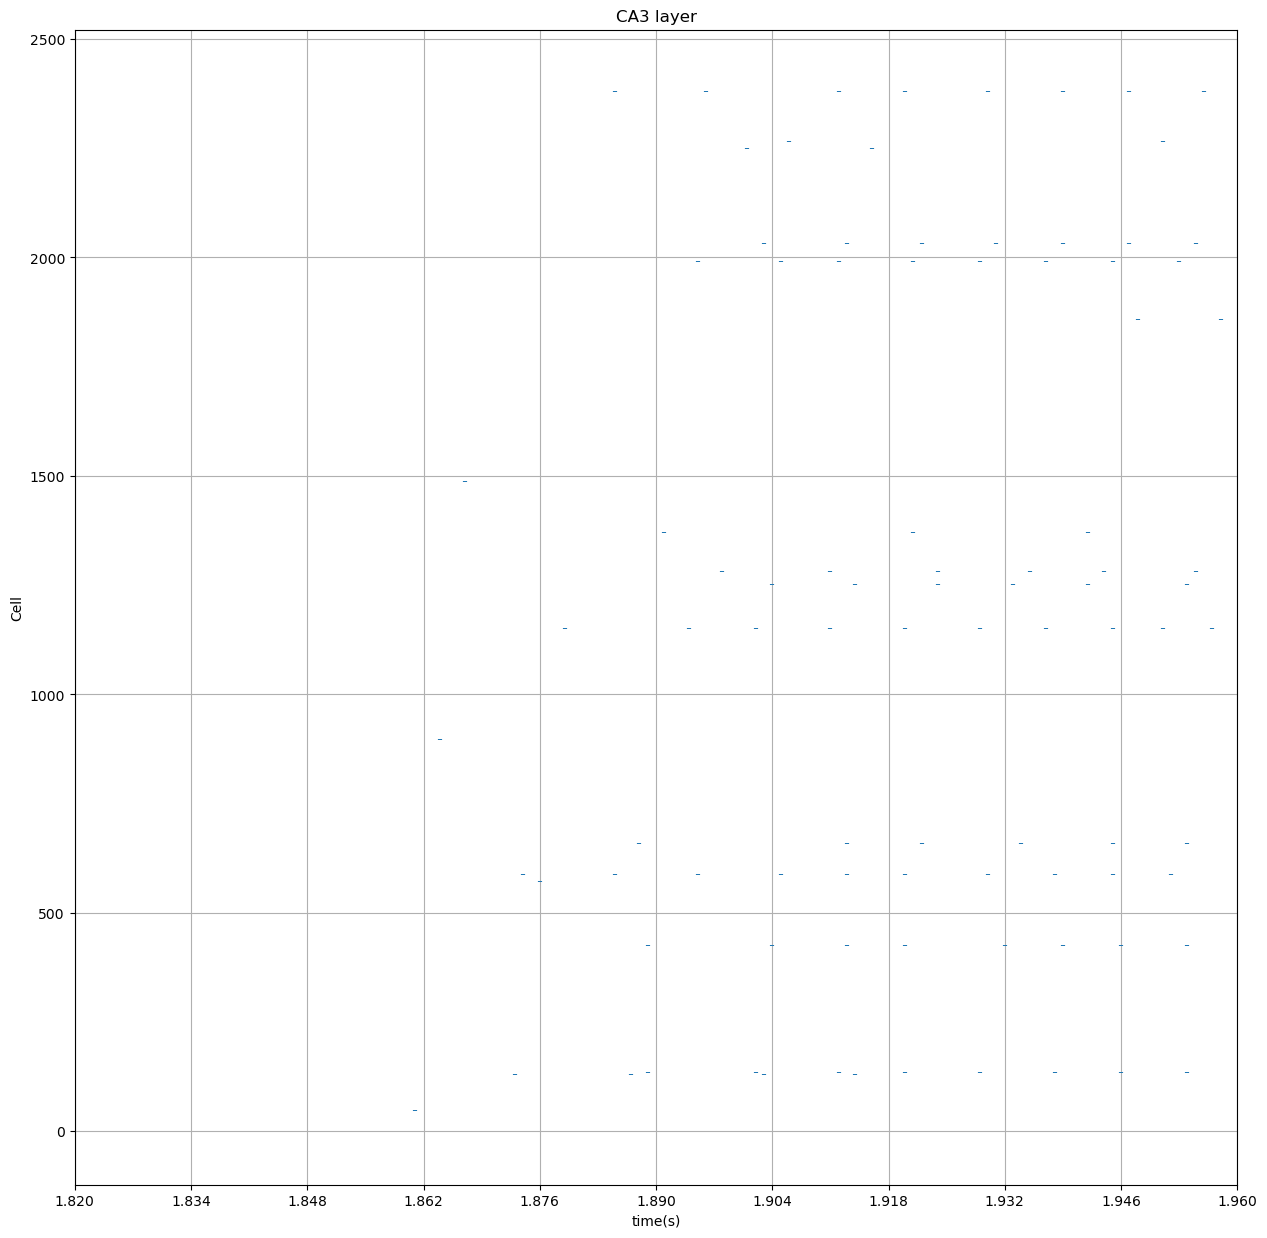

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


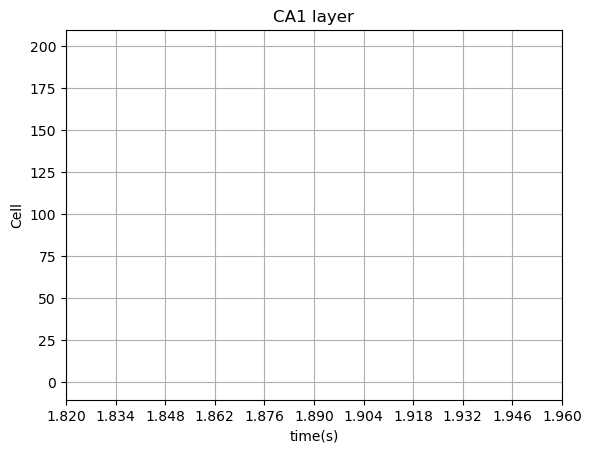

Ret1 :  {48, 1882, 896}
Ret2 :  {1374, 131, 1637, 134, 425, 588, 557, 2380, 1487, 1969, 658, 571, 1150}
Ret3 :  {1281, 1374, 131, 1251, 1637, 134, 1991, 425, 2249, 2266, 588, 2380, 2031, 1969, 658, 1882, 1371, 1150}
Rc :  {1281, 1374, 1251, 1857, 134, 1991, 425, 2249, 2266, 588, 2380, 2031, 1969, 658, 1882, 1371, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 1988 [1930]
0 1995 [1080]
0 1998 [885]
0 2042 [402]
0 2067 [1094]
0 2071 [1080]


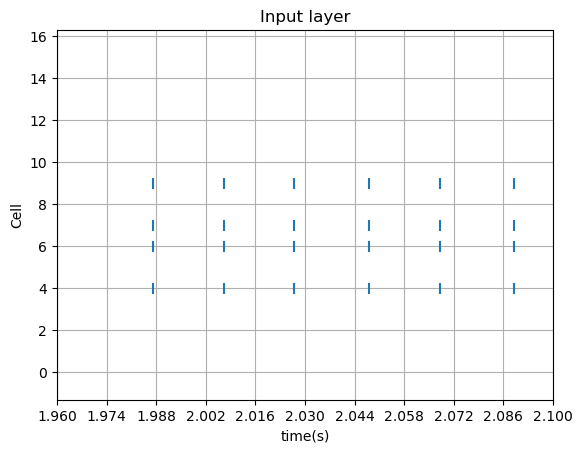

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


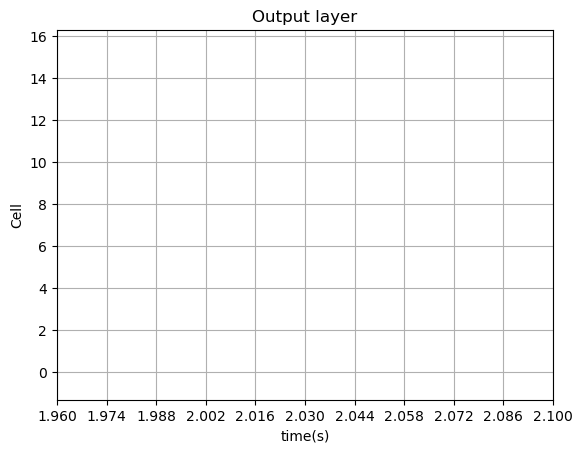

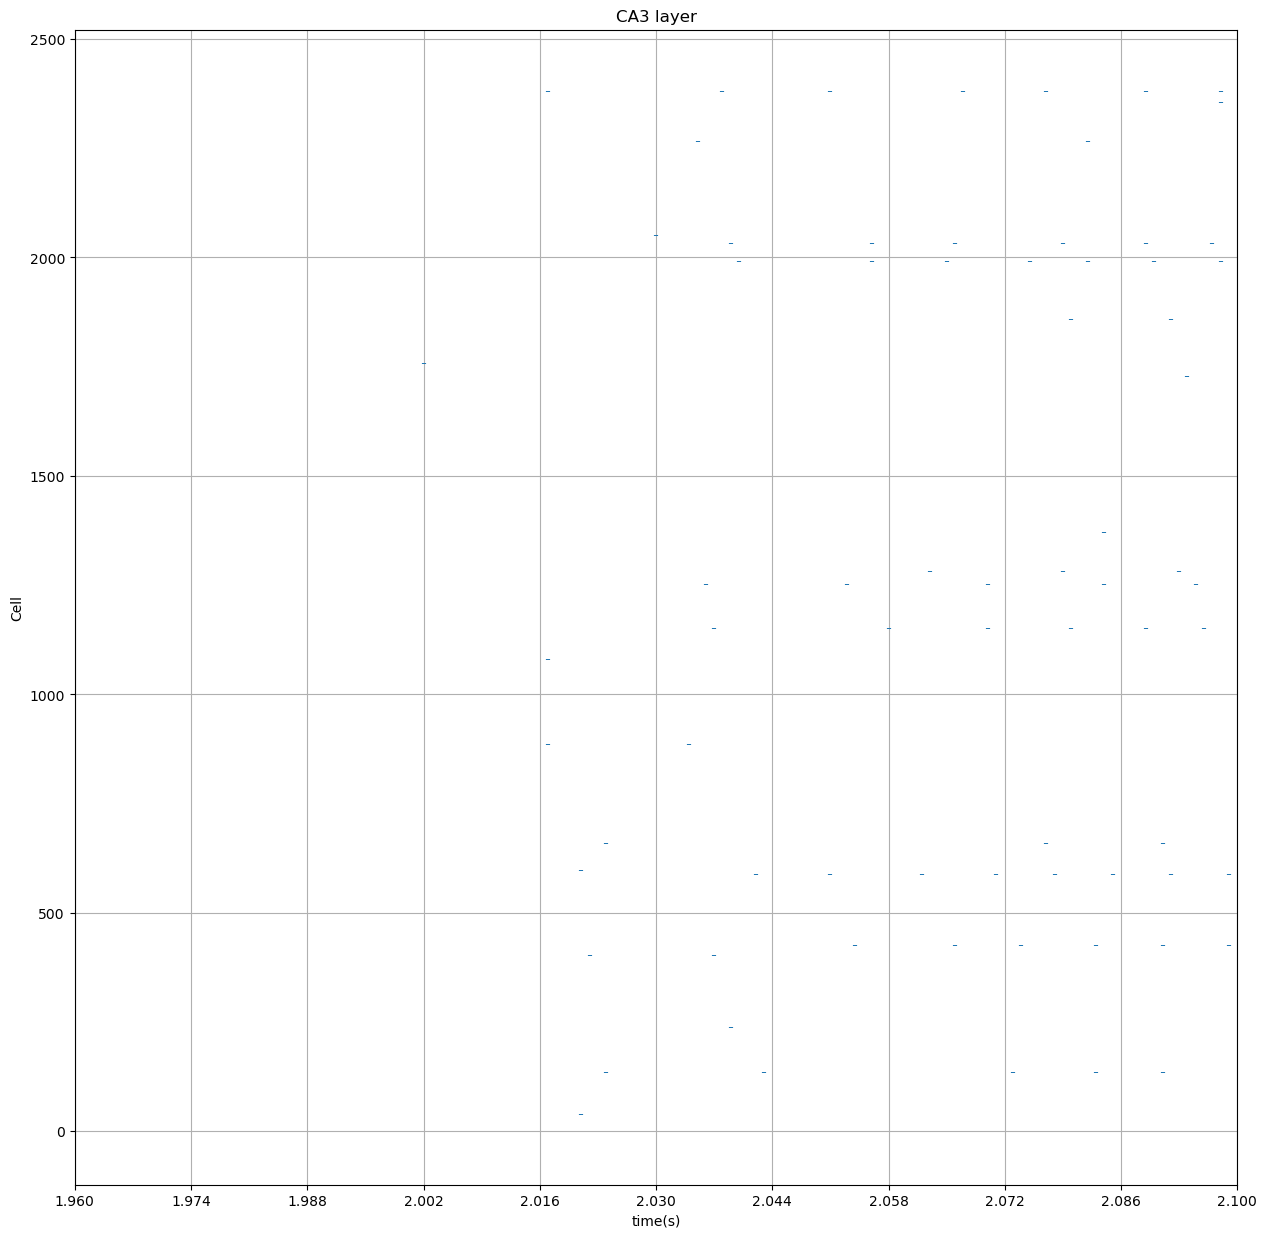

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


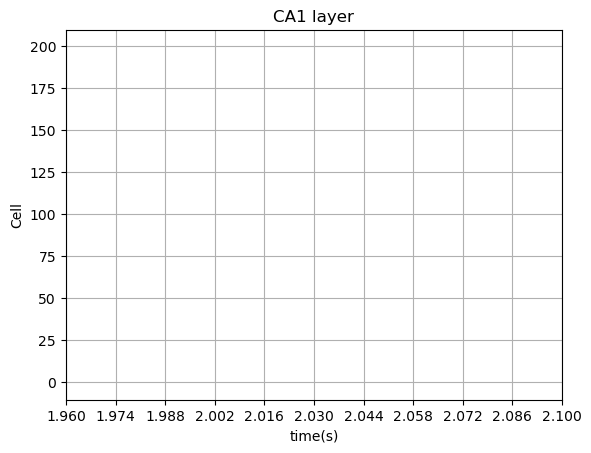

Ret1 :  {1930, 1757}
Ret2 :  {134, 39, 2380, 1969, 402, 658, 597, 885, 1080, 1374}
Ret3 :  {1374, 1921, 1251, 2051, 134, 1991, 425, 2266, 588, 237, 2380, 2031, 1969, 402, 885, 1882, 1150}
Rc :  {1281, 134, 658, 425, 557, 1969, 2355, 1727, 1857, 1991, 588, 2380, 2266, 1882, 1371, 1374, 1251, 2031, 1150}
intersection with 5 :  {1921, 2051, 1930, 237, 402, 885, 1080}
---------------------------------------------------------------------------------
0 2224 [402]


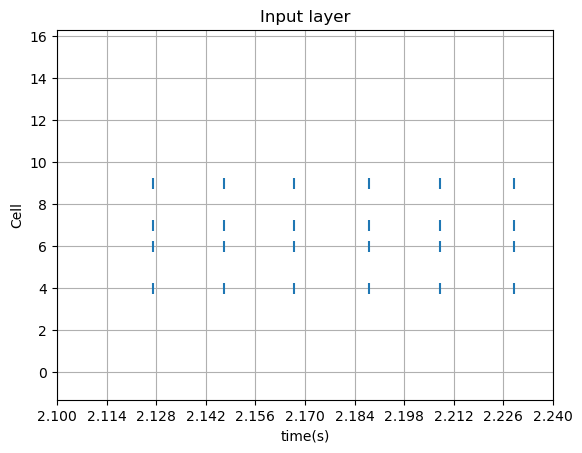

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


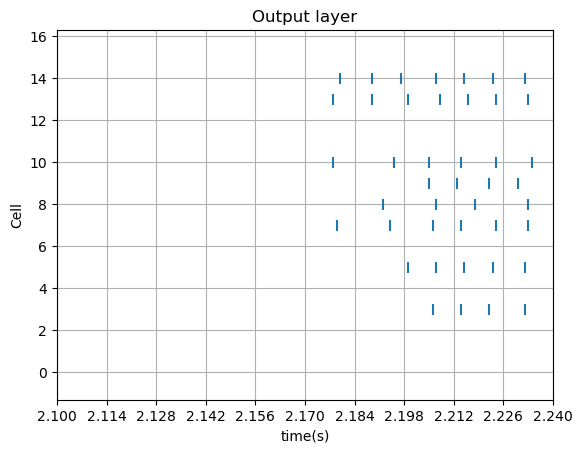

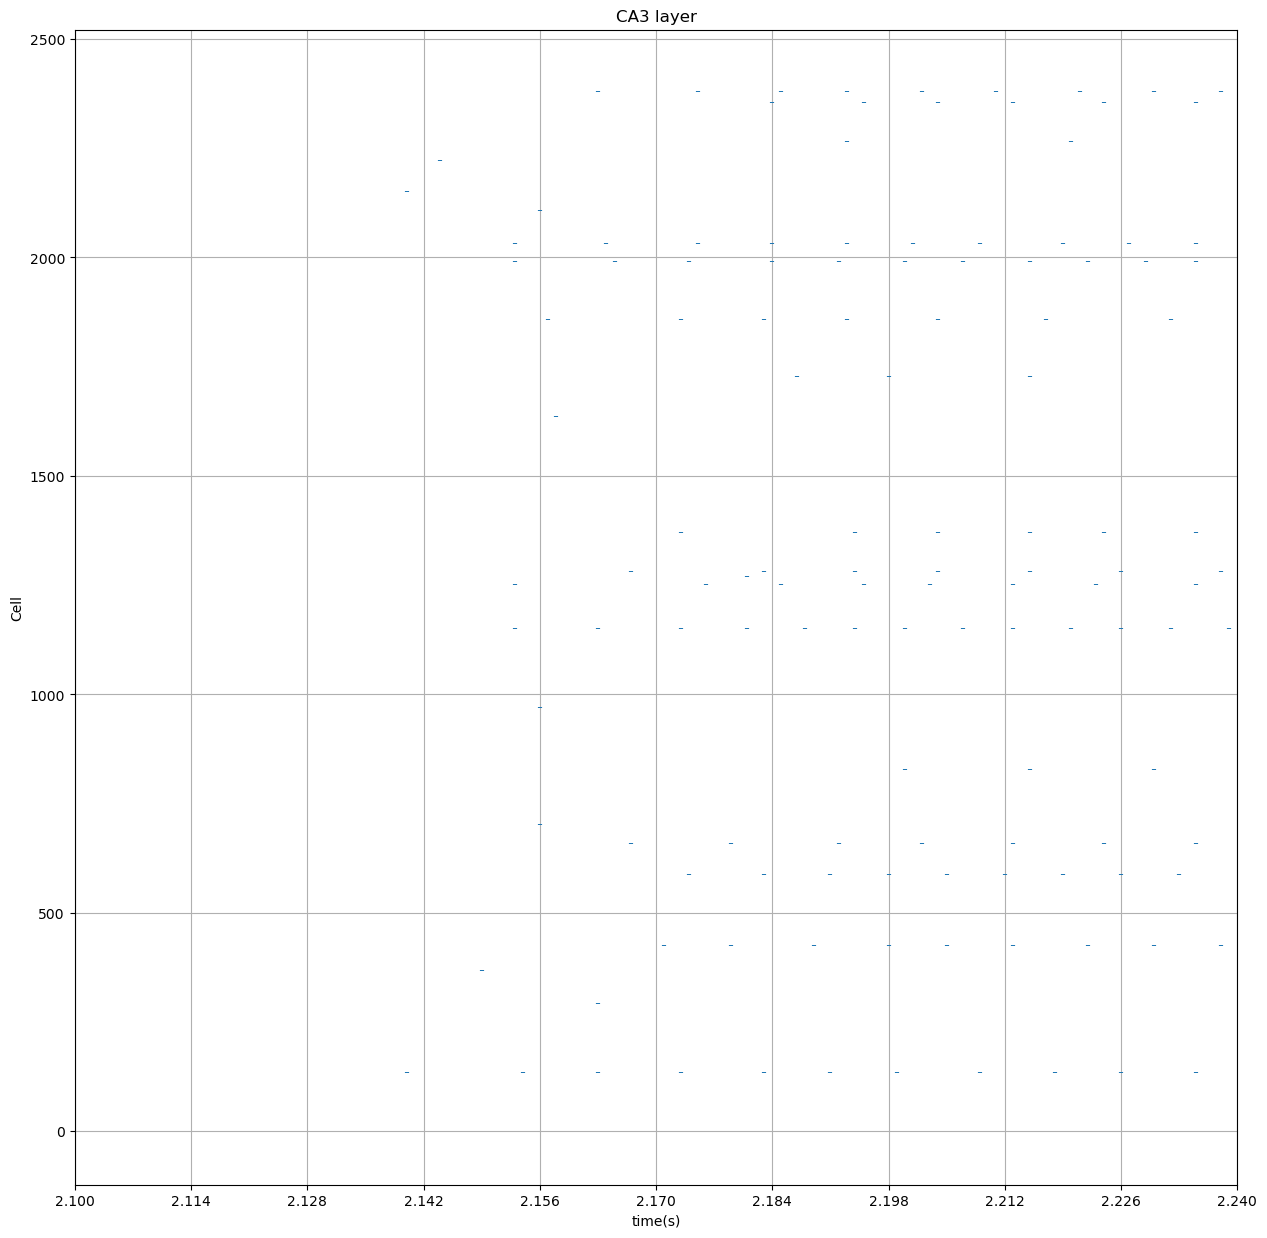

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


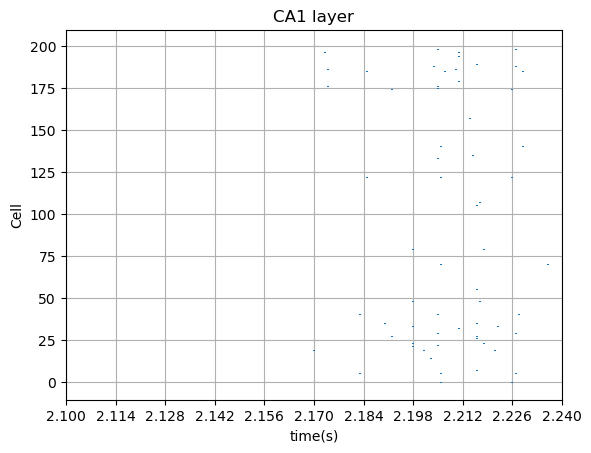

Ret1 :  {2221, 134, 2151}
Ret2 :  {1281, 1374, 1251, 292, 1635, 134, 1857, 1991, 971, 2380, 2031, 369, 658, 1969, 2108, 1150, 703}
Ret3 :  {1281, 134, 658, 425, 557, 1969, 2355, 1727, 1857, 1991, 588, 2380, 2266, 1882, 1371, 1374, 1251, 2031, 1270, 1150}
Rc :  {1281, 134, 658, 425, 557, 1969, 2355, 828, 1727, 1857, 1991, 588, 2380, 2266, 1882, 1371, 1374, 1251, 2031, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 2330 [1080]
0 2339 [344]


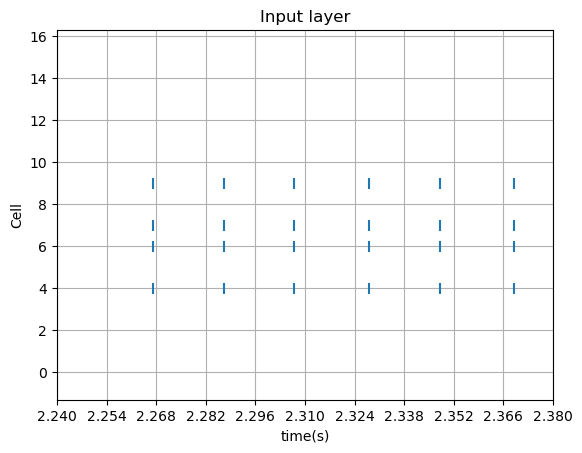

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


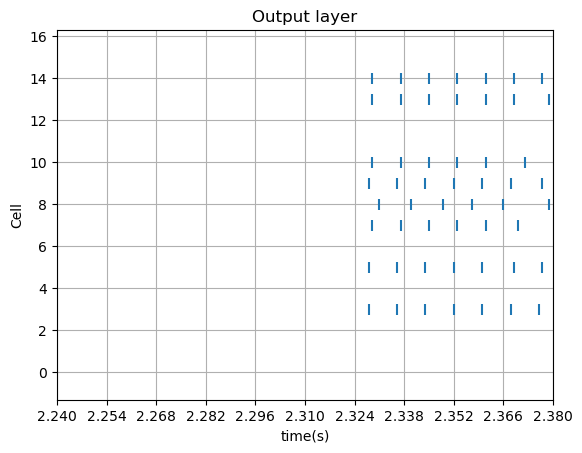

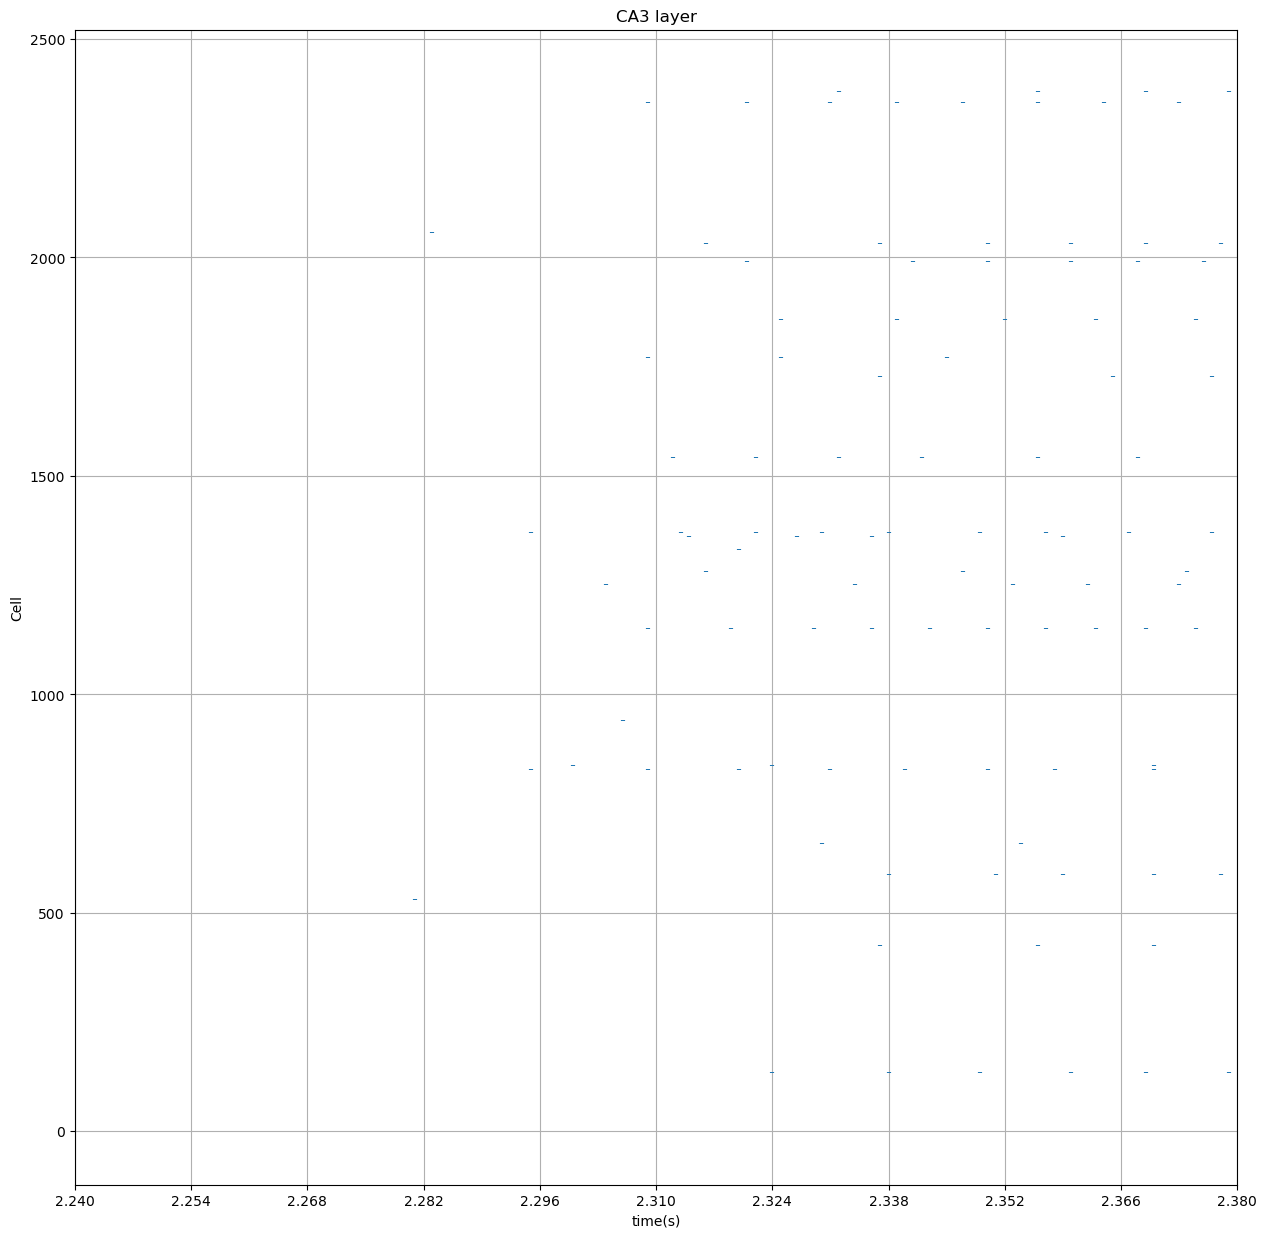

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


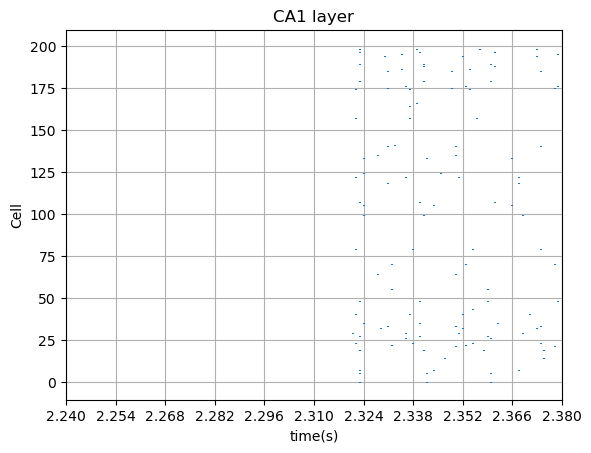

Ret1 :  {2058, 531, 557}
Ret2 :  {1251, 837, 1772, 557, 941, 2355, 1371, 828, 1150}
Ret3 :  {1281, 134, 1542, 658, 557, 1969, 1331, 2355, 828, 1857, 837, 1991, 2380, 1362, 1882, 1371, 1251, 1770, 1772, 2031, 1150}
Rc :  {1281, 134, 1542, 658, 425, 557, 1969, 2355, 828, 1727, 1857, 837, 1991, 588, 2380, 1362, 1882, 1371, 1374, 1251, 1770, 1772, 2031, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 2431 [1921]
0 2444 [1921]
0 2450 [885]


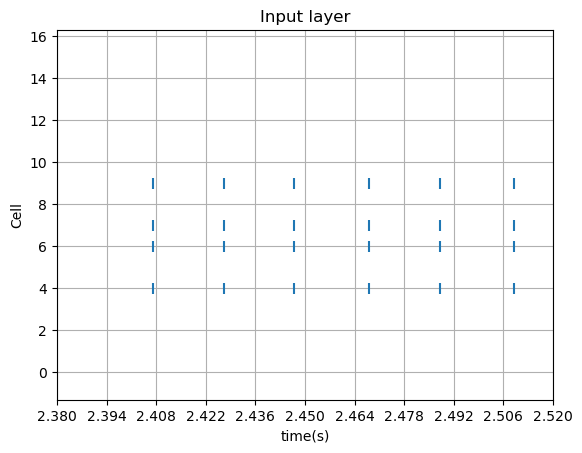

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


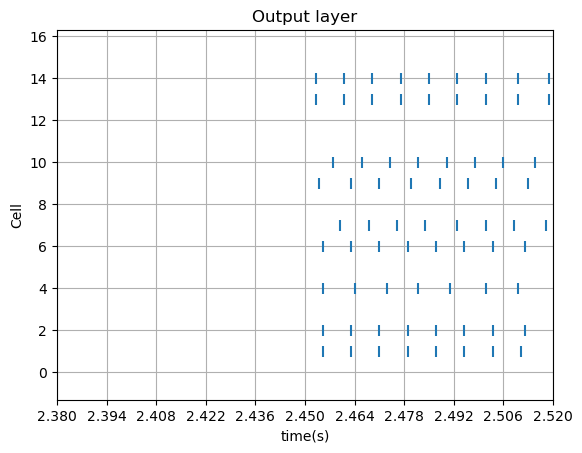

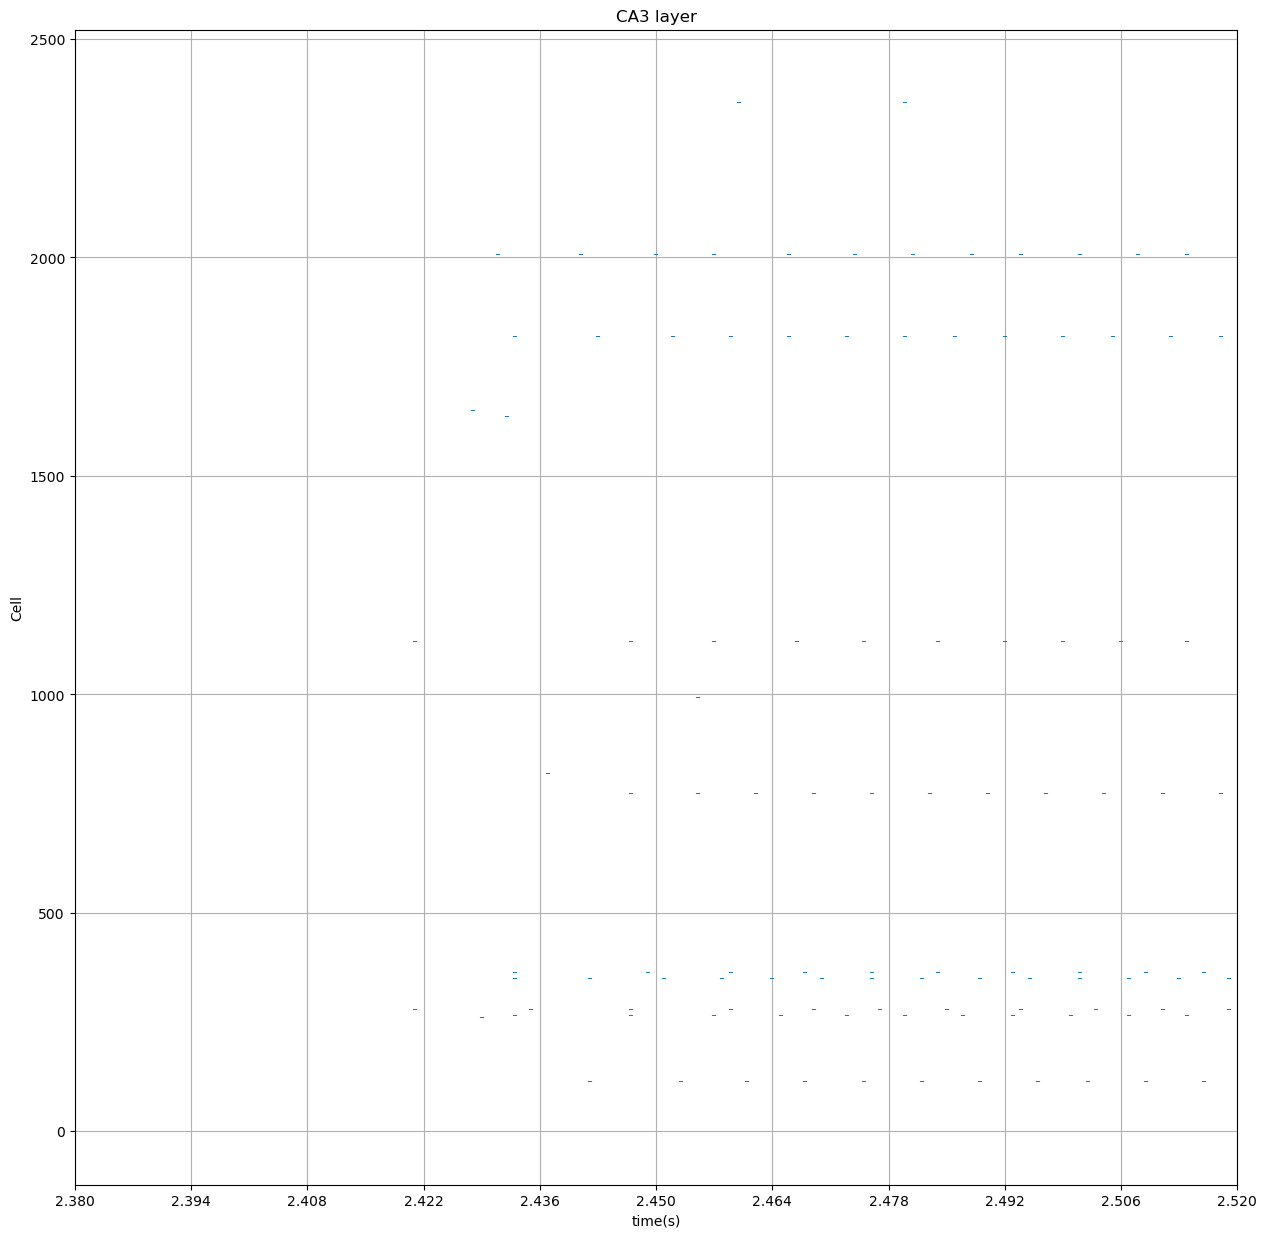

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


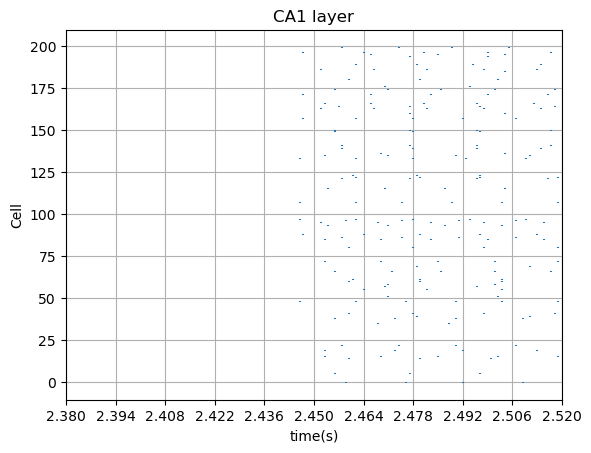

Ret1 :  {1122, 278}
Ret2 :  {1122, 1635, 261, 773, 265, 364, 1649, 114, 818, 278, 2007, 1819, 349}
Ret3 :  {993, 1122, 773, 265, 364, 114, 2355, 278, 2007, 1819, 349}
Rc :  {1122, 773, 265, 364, 114, 2355, 278, 2007, 1819, 349}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 2567 [885]
0 2646 [885]


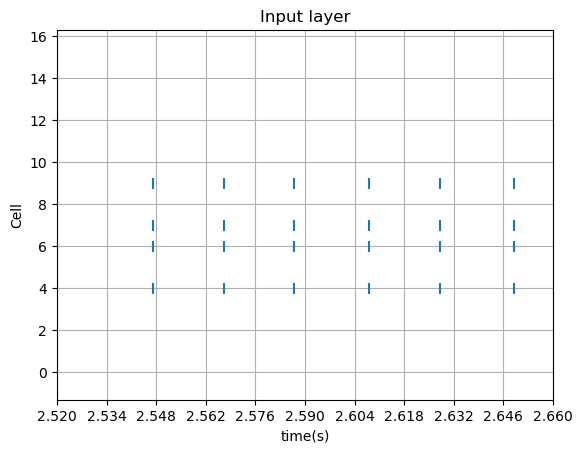

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


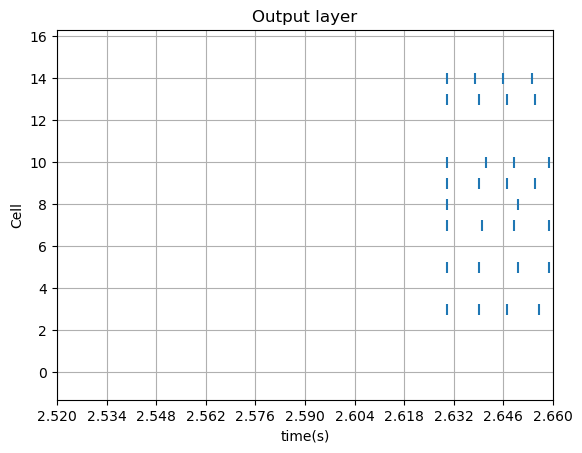

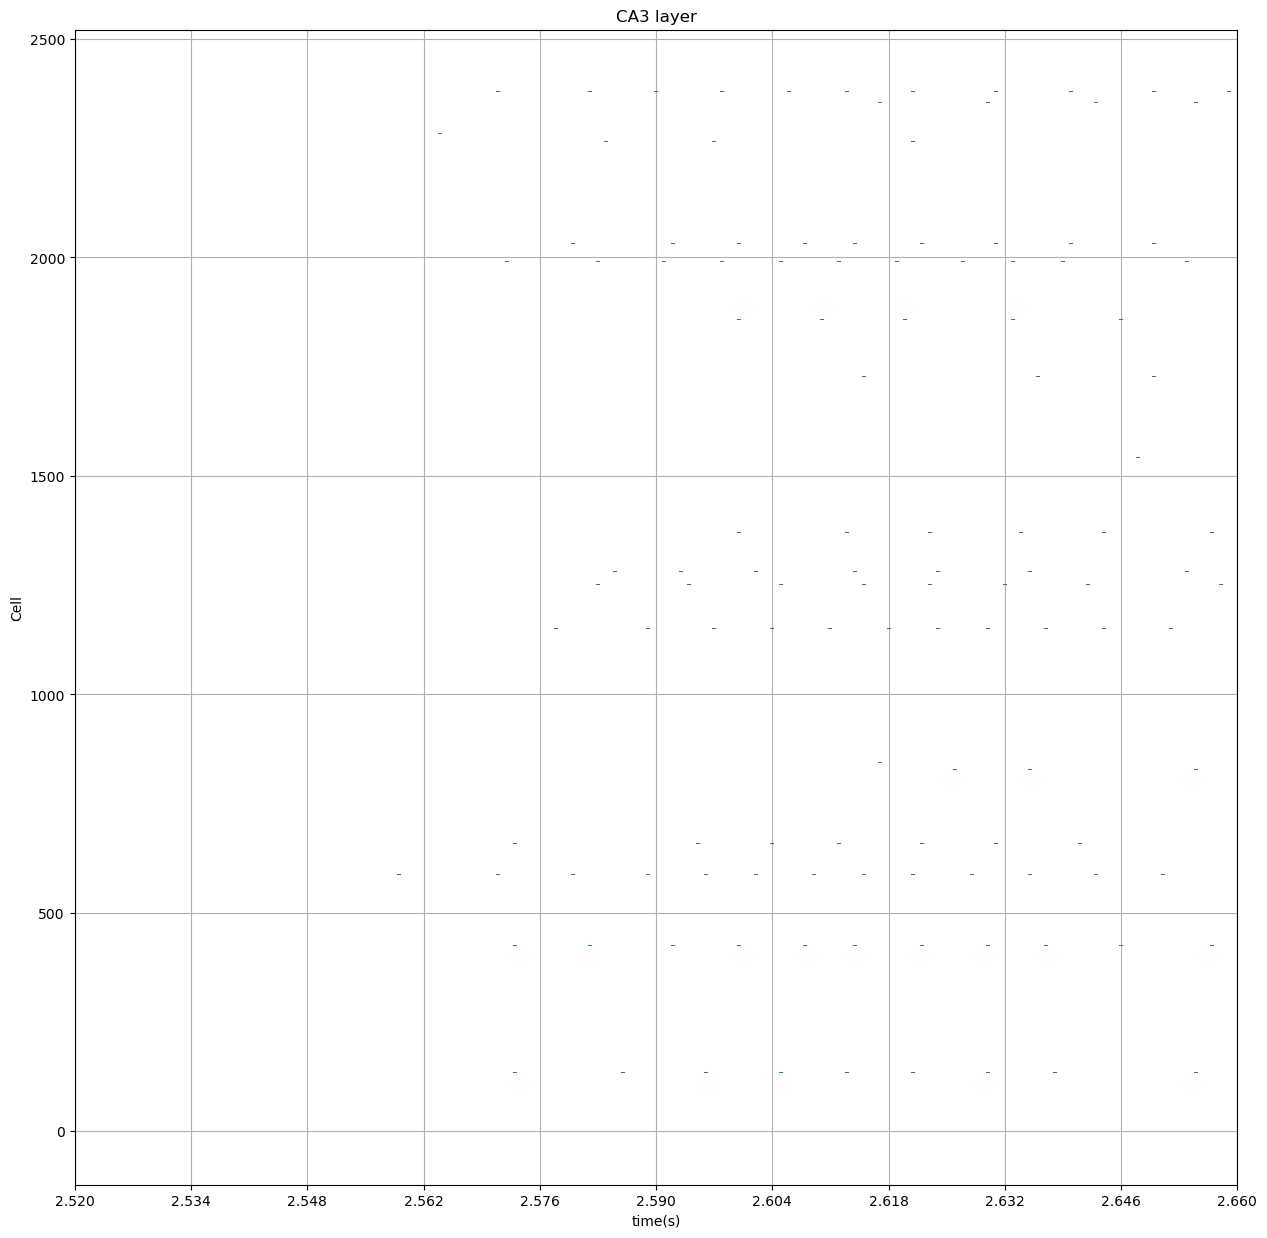

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


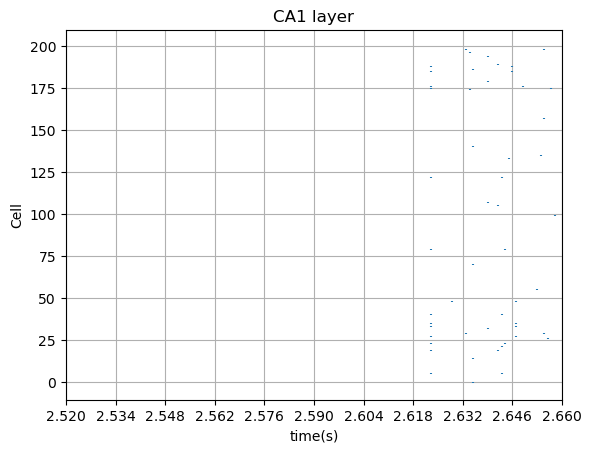

Ret1 :  {1969, 588, 1374, 2284}
Ret2 :  {1281, 1374, 1251, 134, 1991, 425, 2266, 588, 2380, 2031, 1969, 658, 1882, 1150}
Ret3 :  {1281, 1374, 1251, 1857, 134, 1991, 425, 2266, 588, 557, 2380, 2031, 1969, 658, 1882, 1371, 1150}
Rc :  {1281, 134, 1542, 658, 425, 557, 1969, 2355, 828, 1727, 1857, 1991, 588, 844, 2380, 1882, 1371, 2266, 1374, 1251, 2031, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 2689 [885]
0 2777 [1080]


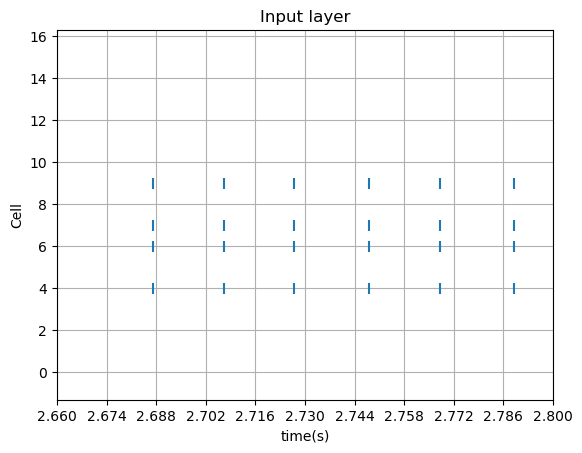

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


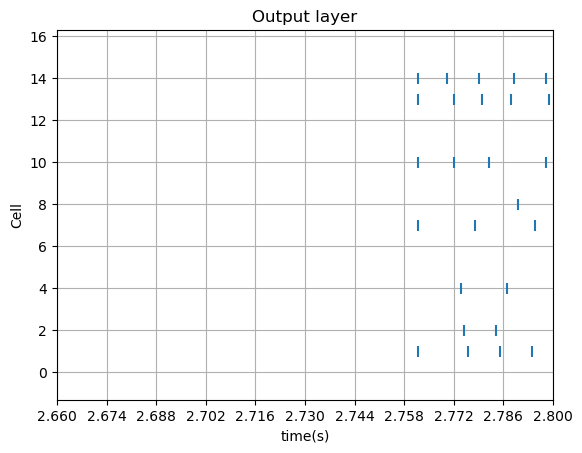

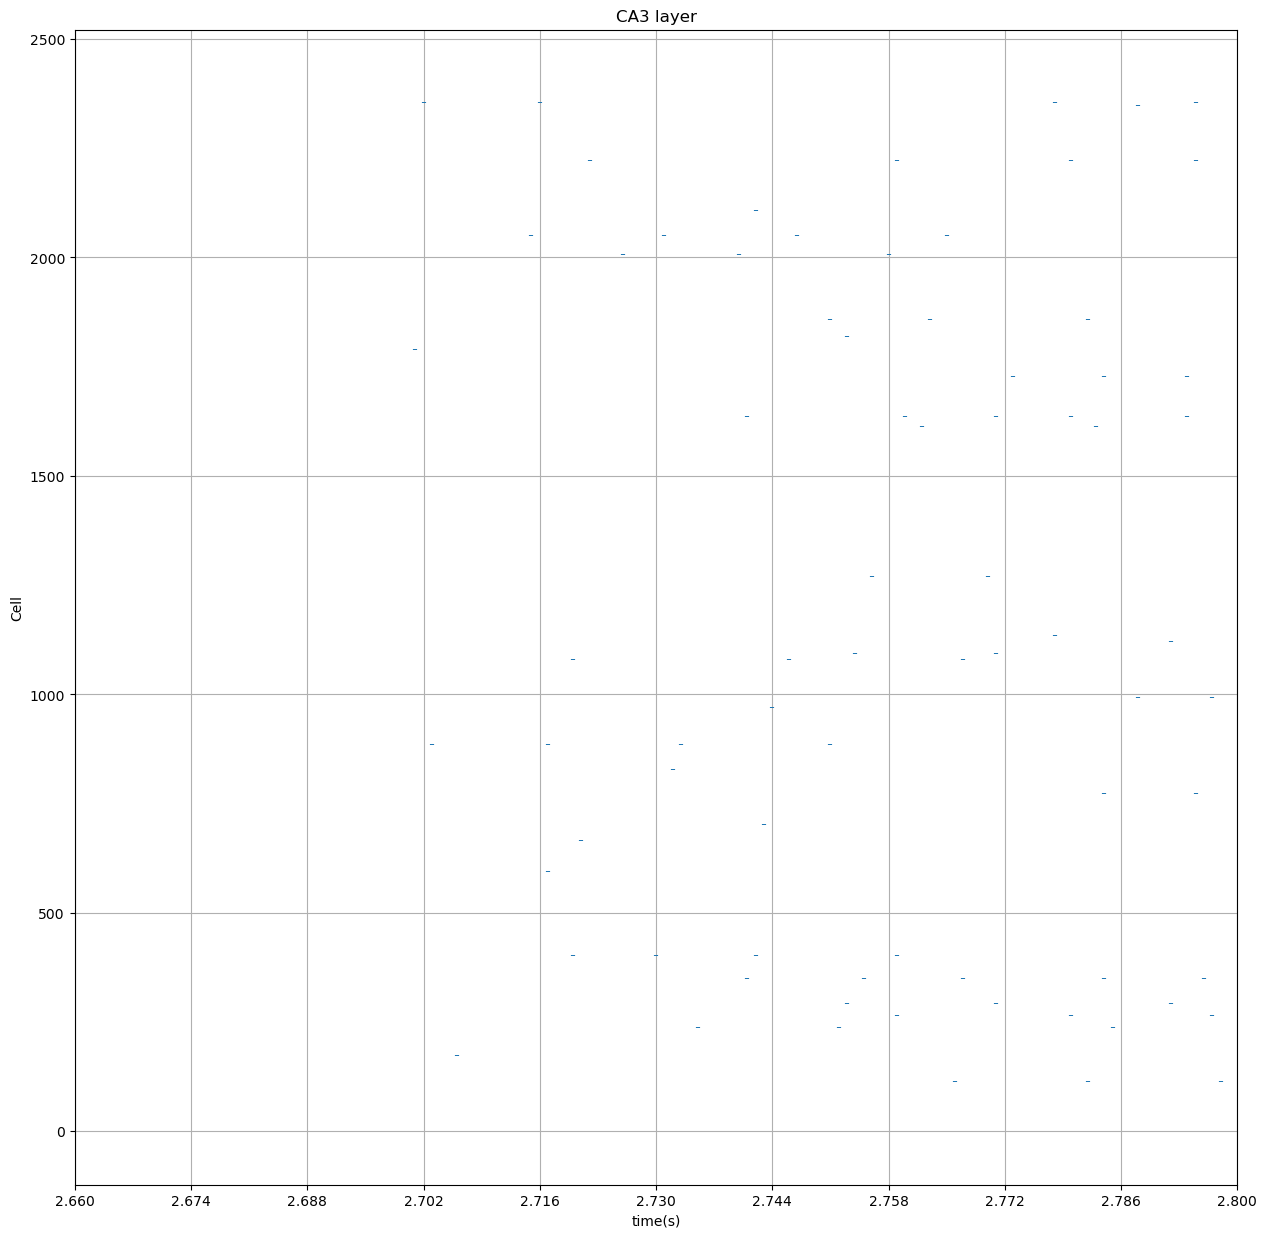

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


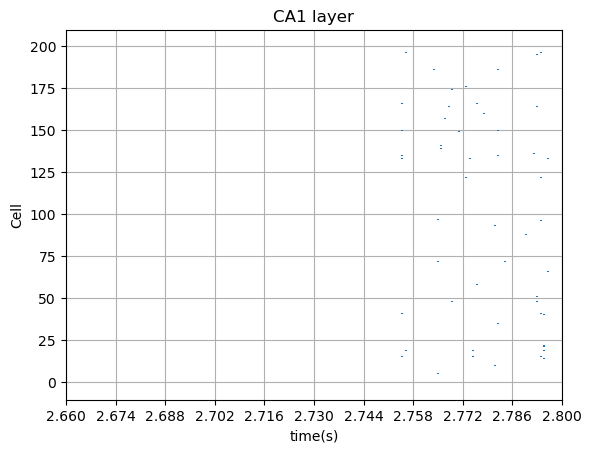

Ret1 :  {2355, 885, 1790}
Ret2 :  {2051, 557, 173, 2221, 594, 402, 2355, 885, 2007, 1080, 665}
Ret3 :  {1857, 1635, 292, 2051, 1094, 971, 237, 2108, 402, 885, 2007, 1080, 1819, 828, 349, 703}
Rc :  {2051, 773, 265, 1930, 402, 292, 2347, 2221, 2355, 1080, 1727, 1857, 1605, 1094, 1614, 2007, 349, 993, 1122, 1635, 237, 1134, 114, 1270}
intersection with 5 :  {2051, 1094, 1930, 237, 402, 885, 1080}
---------------------------------------------------------------------------------
0 2882 [1921]
0 2926 [402]


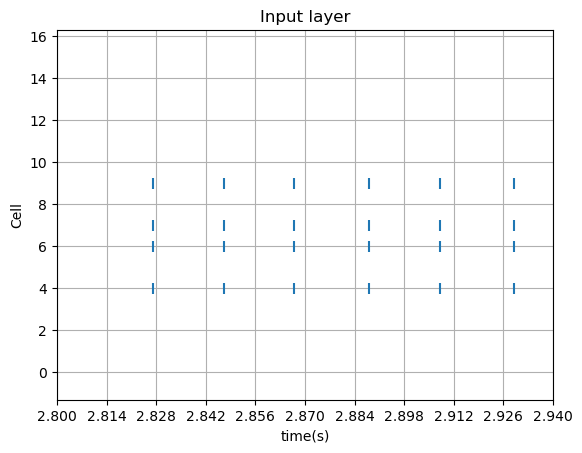

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


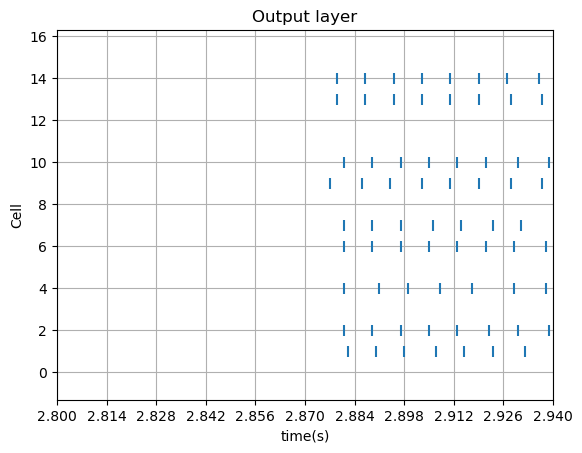

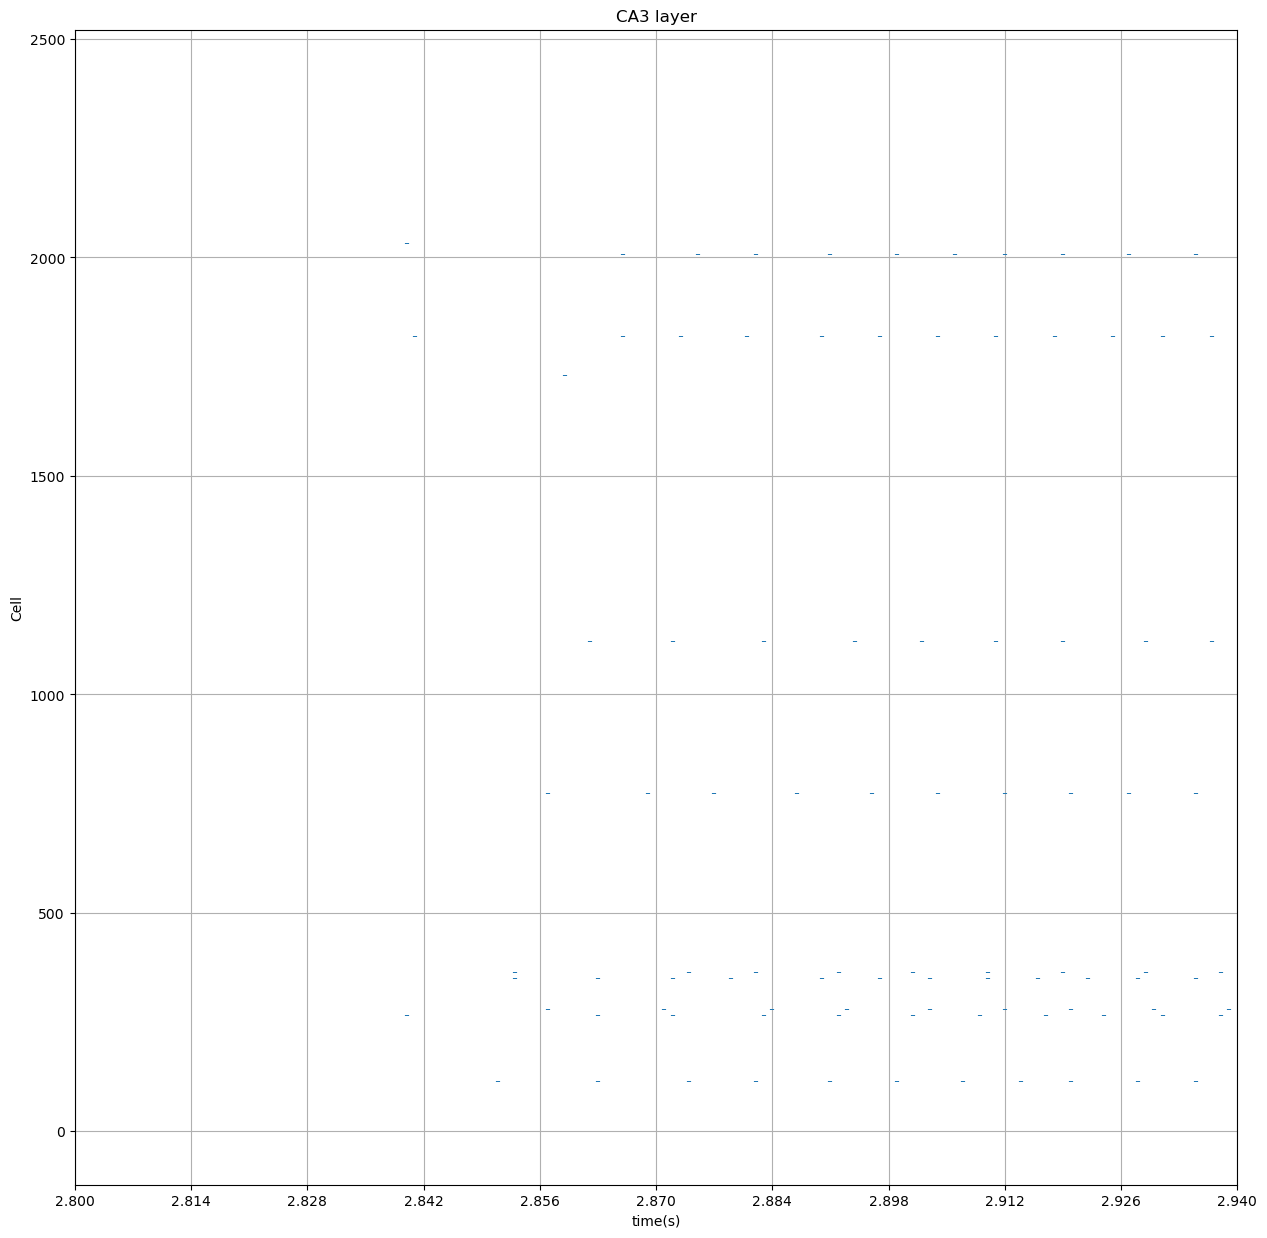

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


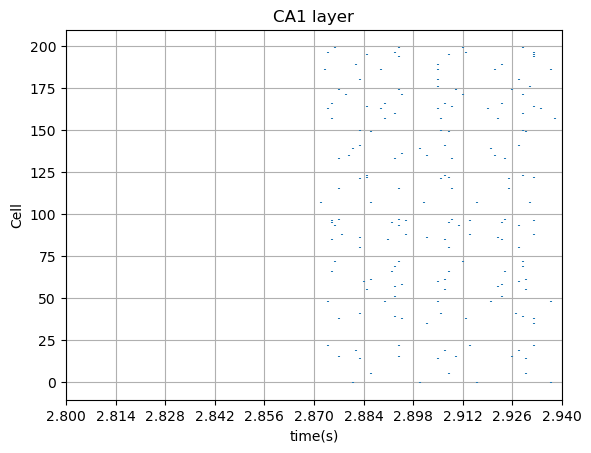

Ret1 :  {265, 1819, 2031}
Ret2 :  {1122, 1730, 773, 265, 364, 114, 278, 2007, 1819, 349}
Ret3 :  {1122, 773, 265, 364, 114, 278, 2007, 1819, 349}
Rc :  {1122, 773, 265, 364, 114, 278, 2007, 1819, 349}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 3018 [1930]
0 3019 [1921]
0 3026 [1921]
0 3034 [1921]


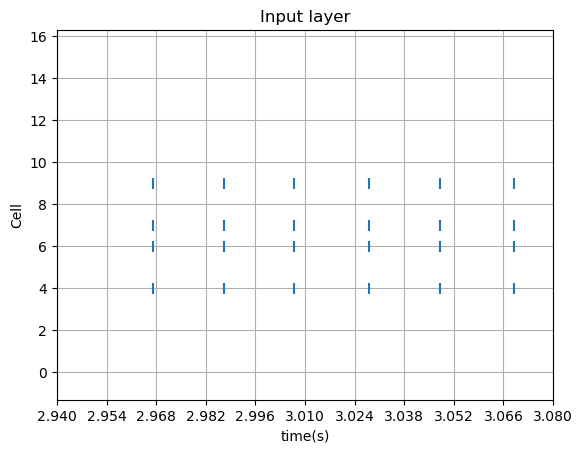

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


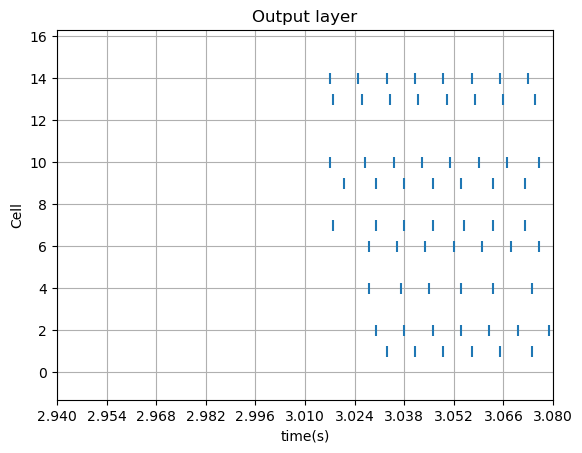

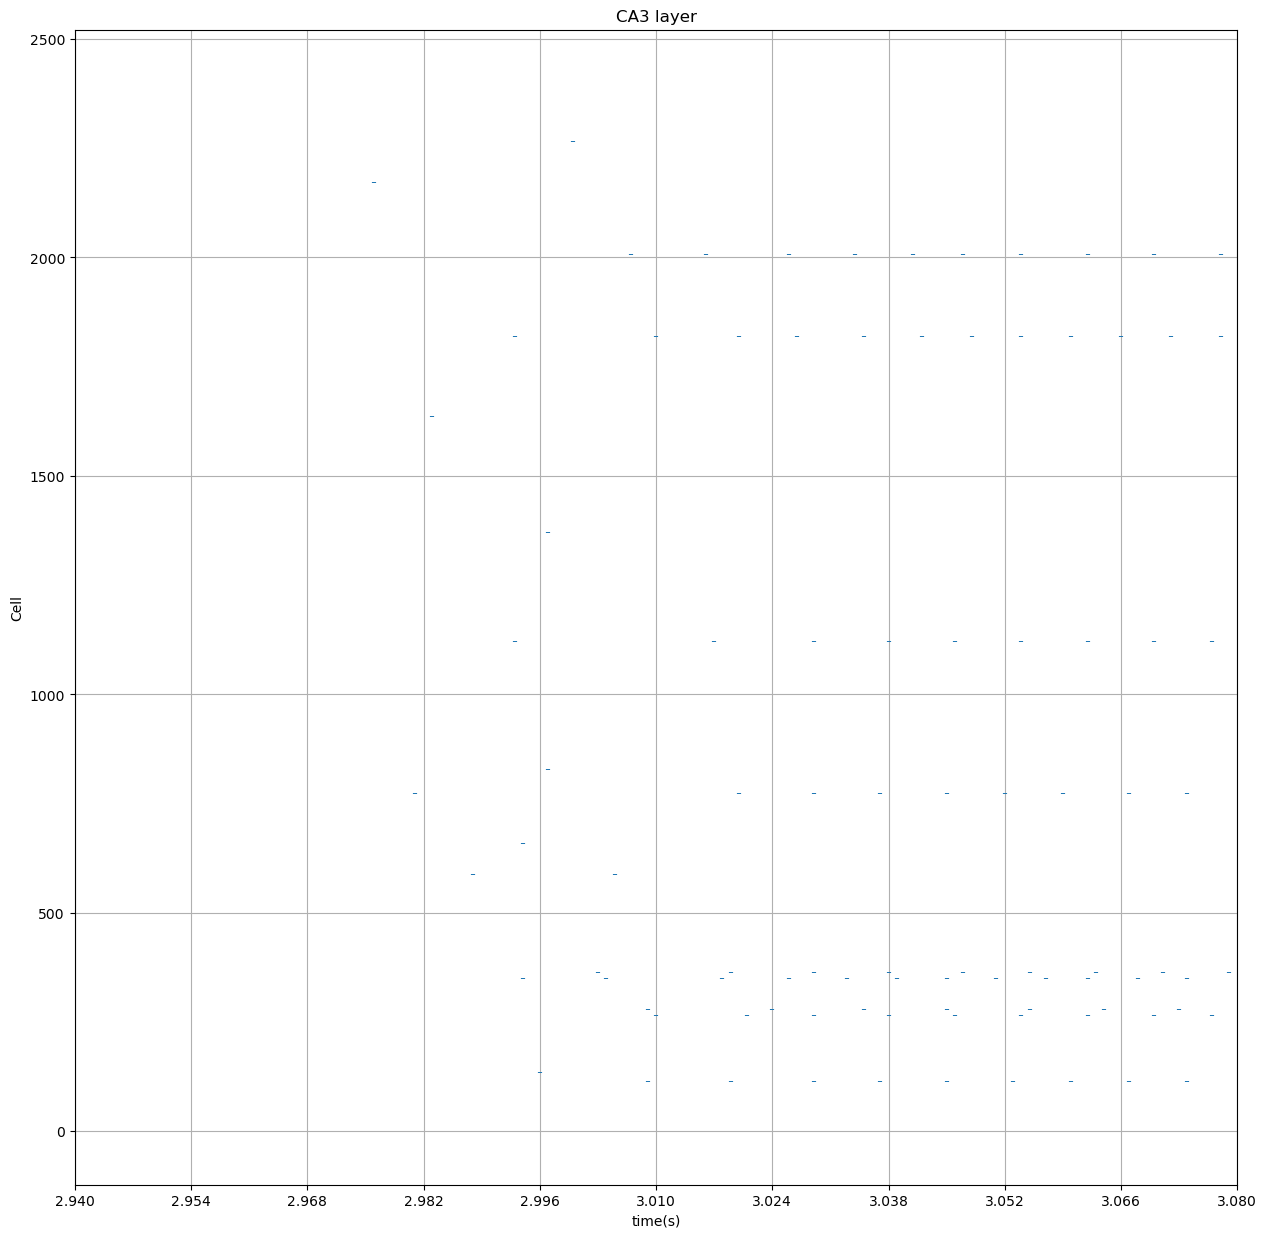

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


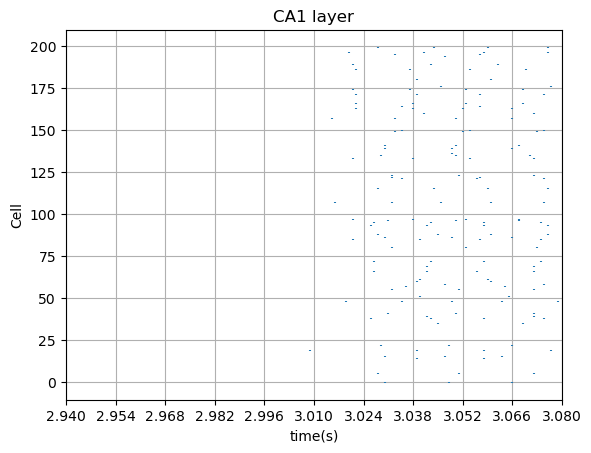

Ret1 :  {1635, 773, 557, 1969, 2171}
Ret2 :  {1819, 1122, 134, 364, 588, 2033, 114, 658, 278, 2007, 2266, 1371, 828, 349, 1374}
Ret3 :  {1122, 773, 265, 364, 114, 278, 2007, 1819, 349}
Rc :  {1122, 773, 265, 364, 114, 278, 2007, 1819, 349}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 3122 [885]
0 3170 [1094]


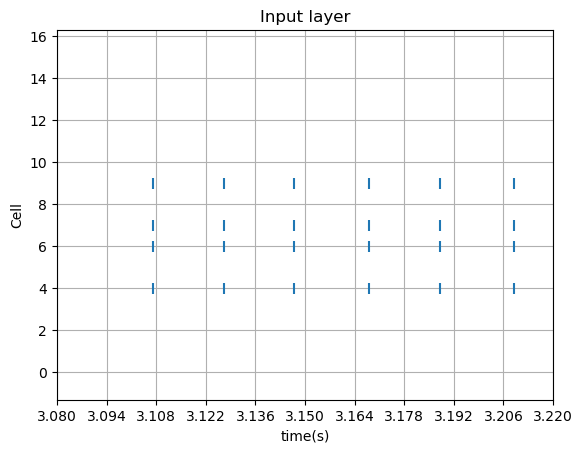

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


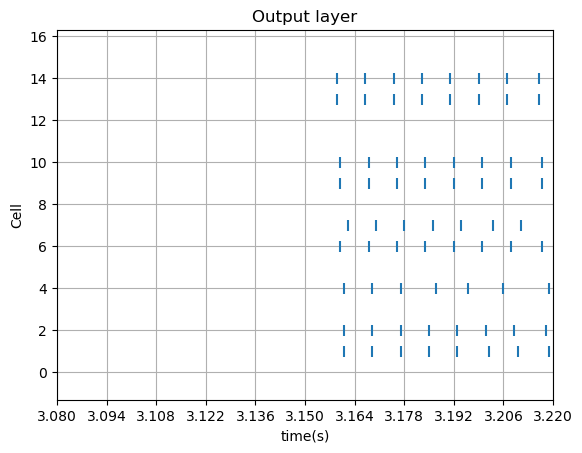

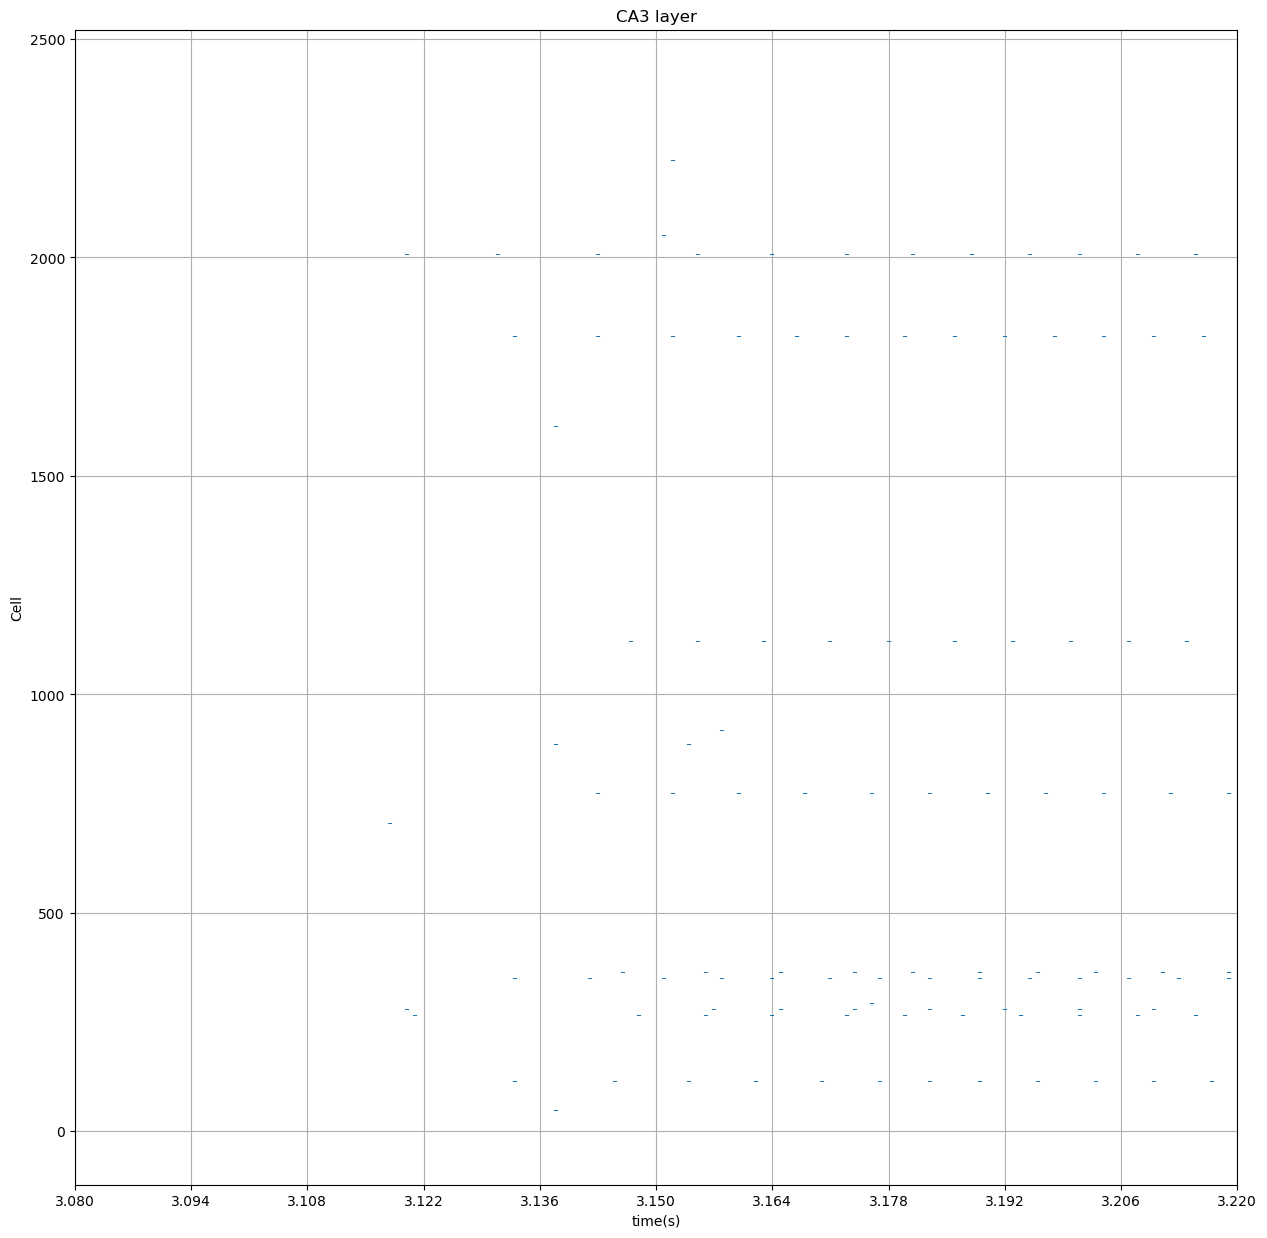

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


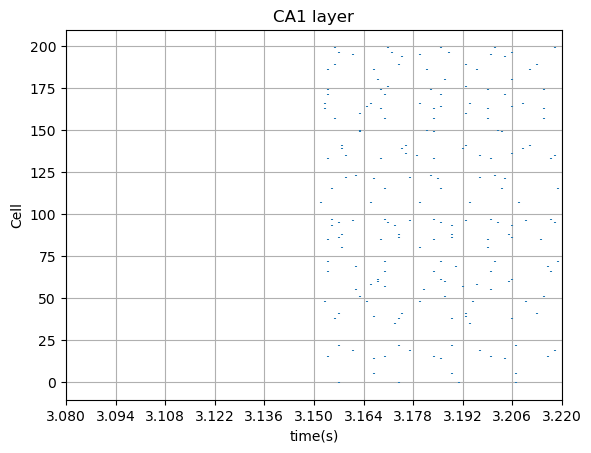

Ret1 :  {265, 705, 278, 2007}
Ret2 :  {1122, 773, 265, 364, 1614, 48, 114, 885, 2007, 1819, 349}
Ret3 :  {1122, 2051, 773, 265, 364, 2221, 114, 2007, 885, 278, 918, 1819, 349}
Rc :  {1122, 292, 773, 265, 364, 114, 278, 2007, 1819, 349}
intersection with 5 :  {2051, 885}
---------------------------------------------------------------------------------
0 3263 [237]
0 3305 [885]
0 3319 [1930]


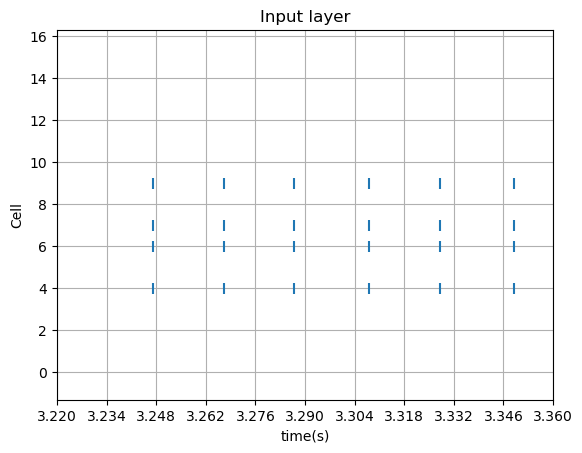

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


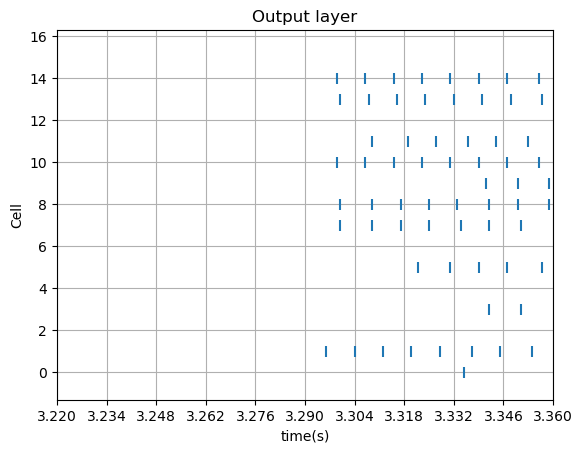

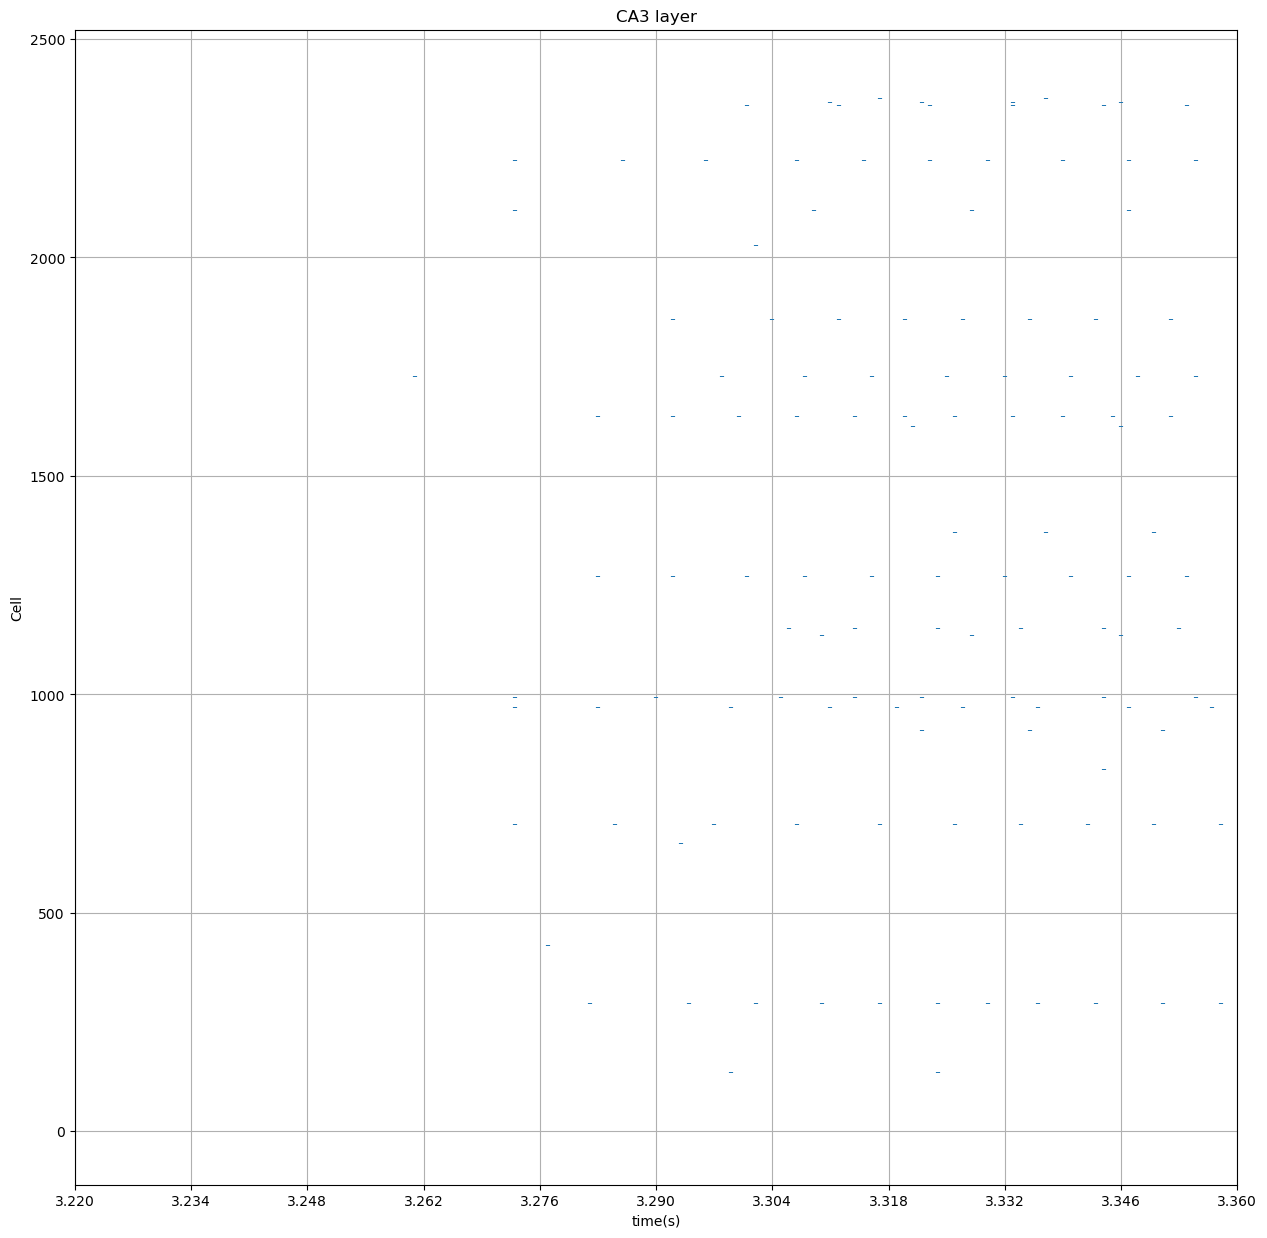

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


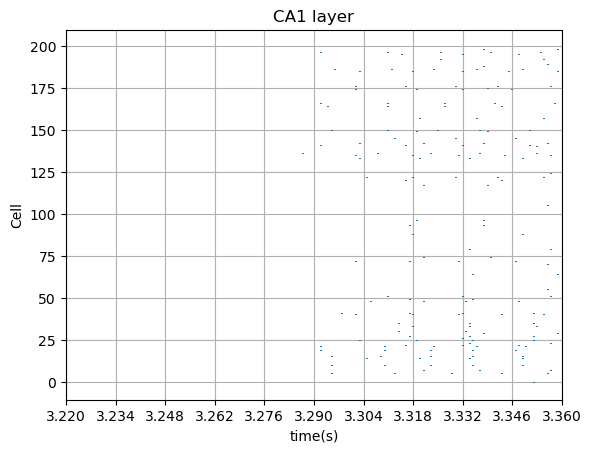

Ret1 :  {1727}
Ret2 :  {993, 1635, 292, 425, 971, 2221, 1969, 1270, 2108, 703}
Ret3 :  {993, 1857, 1635, 292, 1605, 134, 971, 2027, 2221, 1134, 2347, 1727, 658, 2355, 1270, 2108, 1150, 703}
Rc :  {134, 918, 292, 2347, 557, 2221, 2355, 2108, 828, 2364, 1727, 703, 1857, 1605, 971, 1614, 1371, 993, 1635, 1134, 1270, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 3380 [1094]
0 3405 [2051]
0 3414 [237]
0 3424 [237]
0 3426 [1094]
0 3436 [1080]
0 3483 [1930]


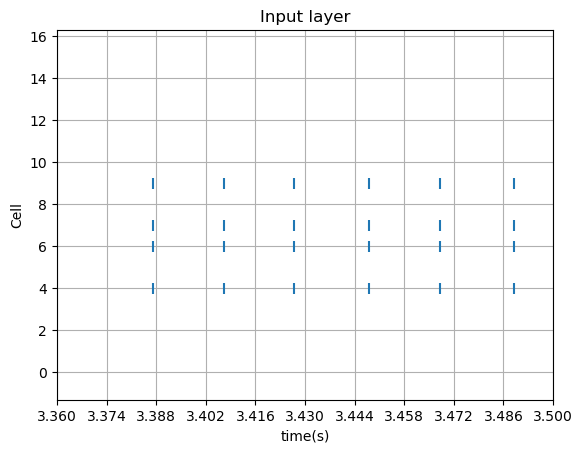

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


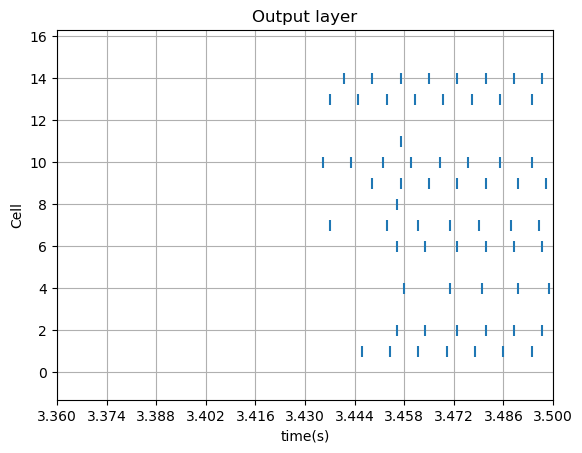

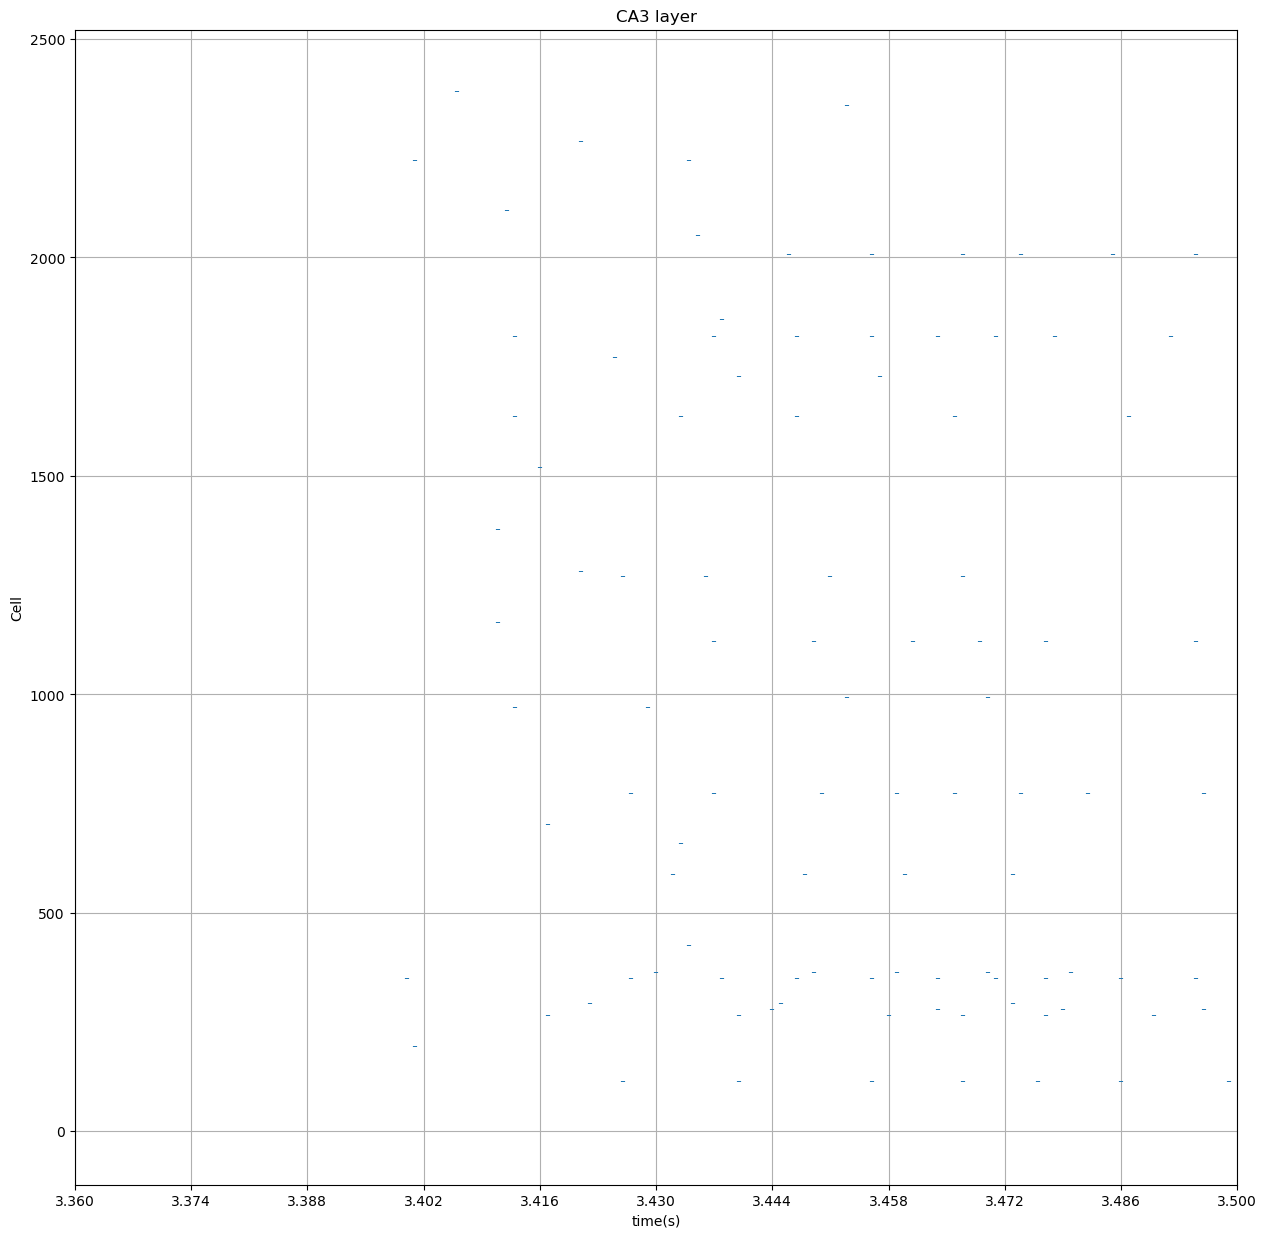

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


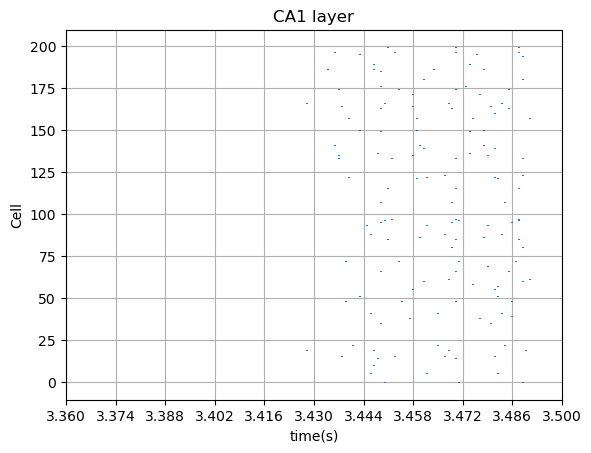

Ret1 :  {195, 349, 2221}
Ret2 :  {1281, 773, 265, 1164, 1819, 292, 2108, 703, 971, 2380, 2266, 349, 1374, 1377, 1635, 1772, 1519, 114, 1270}
Ret3 :  {2051, 773, 265, 658, 278, 1819, 292, 425, 2347, 2221, 1969, 1727, 1857, 1605, 588, 2007, 1882, 349, 1374, 993, 1122, 1635, 364, 114, 1270}
Rc :  {993, 1122, 1635, 292, 773, 1605, 265, 364, 588, 114, 2007, 278, 1270, 1882, 1819, 349, 1374, 1727}
intersection with 5 :  {2051}
---------------------------------------------------------------------------------
0 3612 [344]
0 3631 [2051]


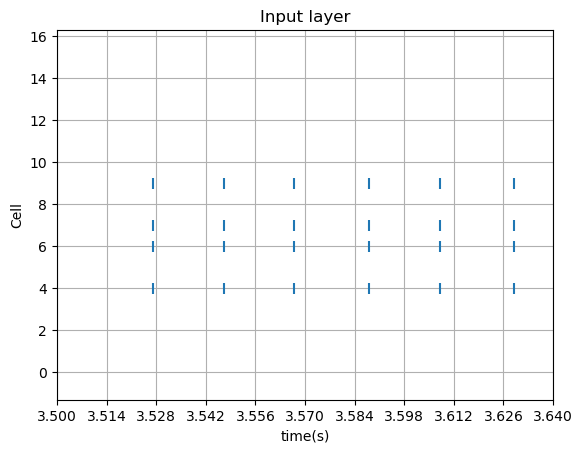

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


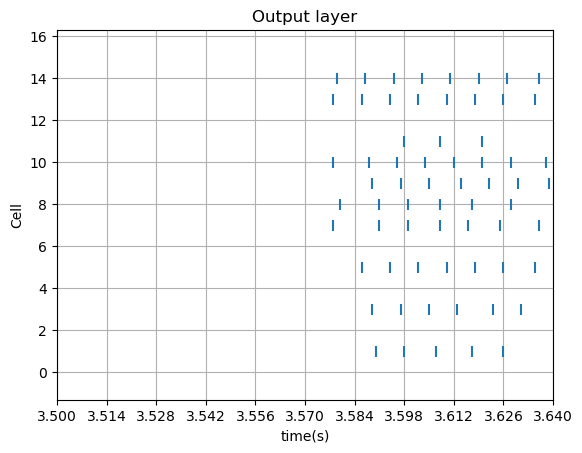

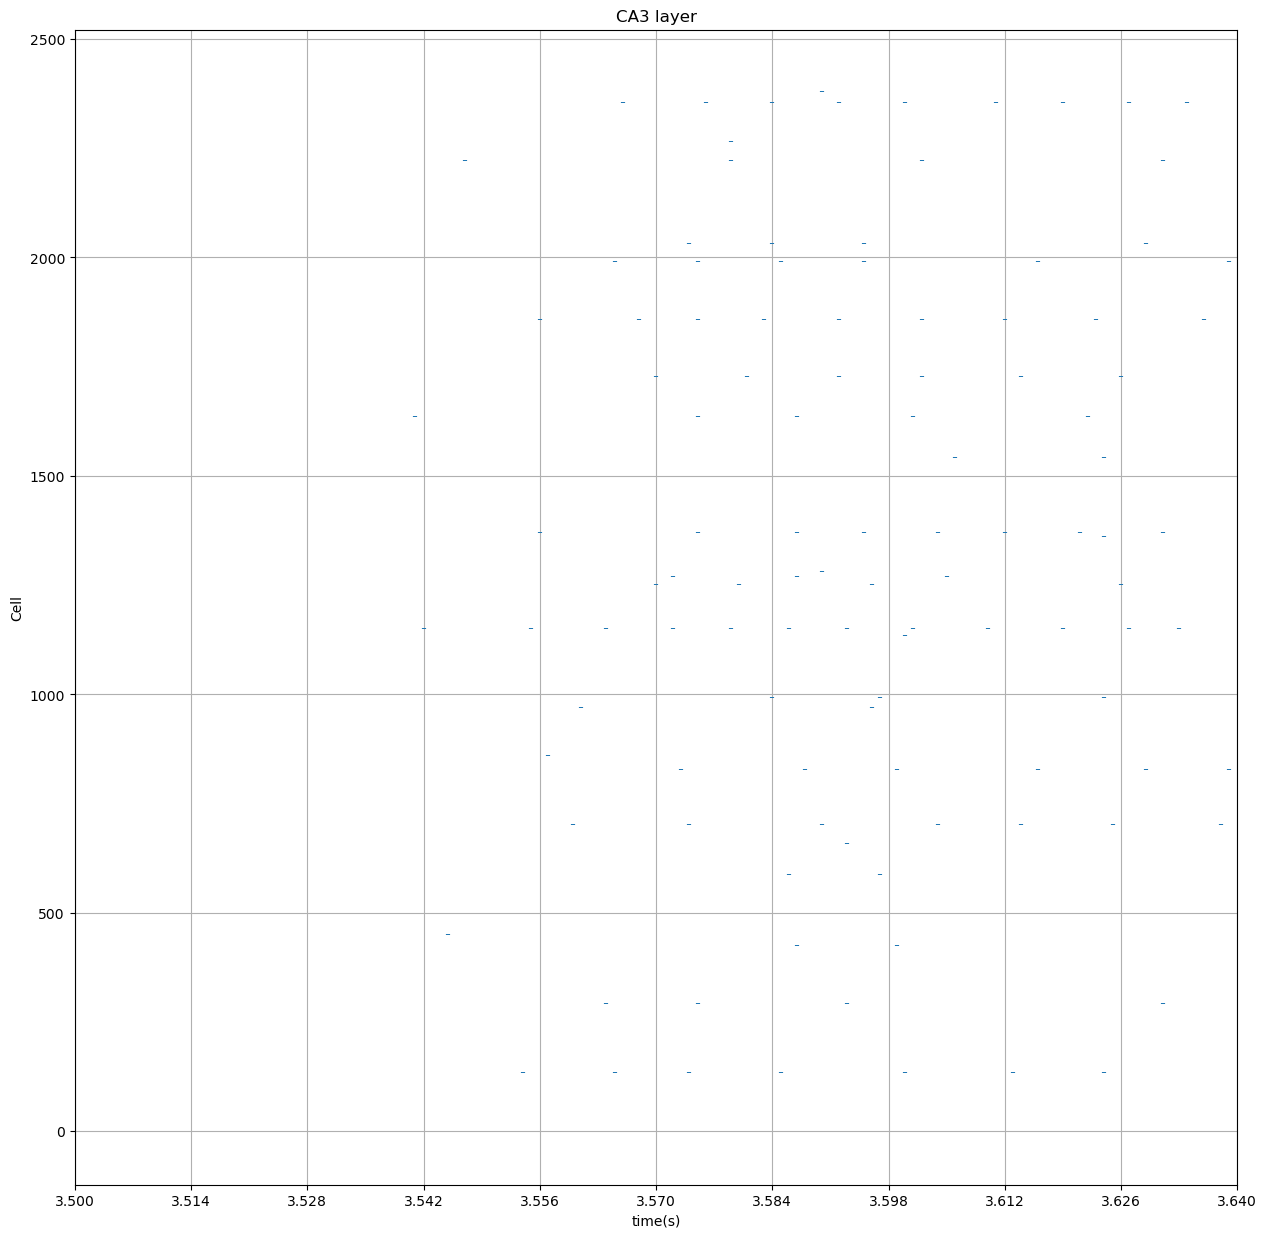

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


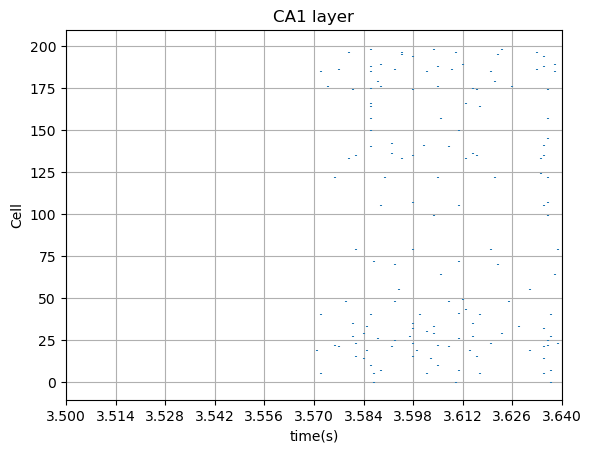

Ret1 :  {1635, 1150}
Ret2 :  {1857, 450, 292, 134, 1991, 971, 557, 2221, 2355, 1371, 861, 1150, 703}
Ret3 :  {1281, 134, 658, 292, 425, 557, 2221, 1969, 2355, 828, 1727, 703, 1857, 1605, 1991, 588, 2380, 2266, 1371, 1374, 993, 1251, 1635, 1770, 2031, 1270, 1150}
Rc :  {134, 1542, 292, 425, 557, 2221, 1969, 2355, 828, 1727, 703, 1857, 1991, 971, 588, 1362, 1882, 1371, 1374, 993, 1251, 1635, 1770, 1134, 2031, 1270, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 3665 [885]
0 3668 [1080]


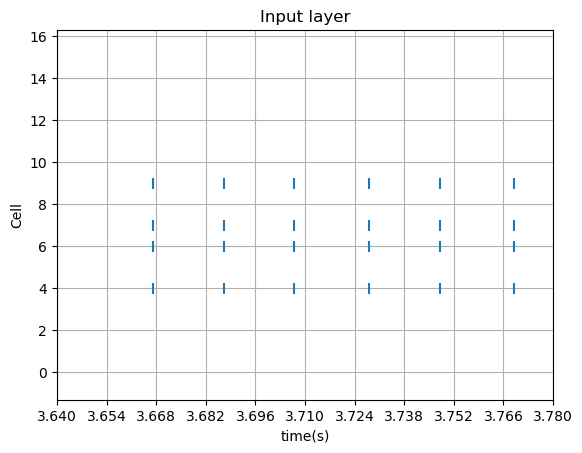

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


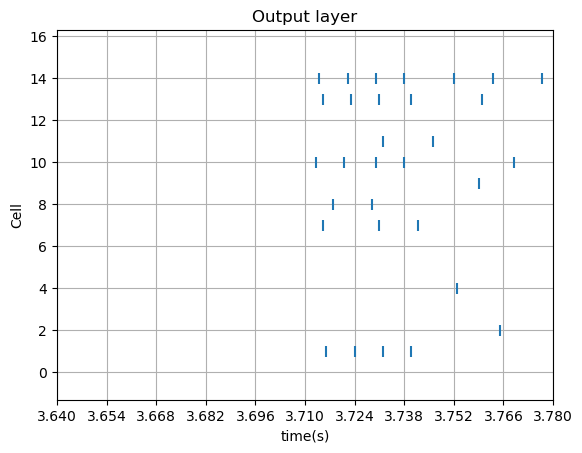

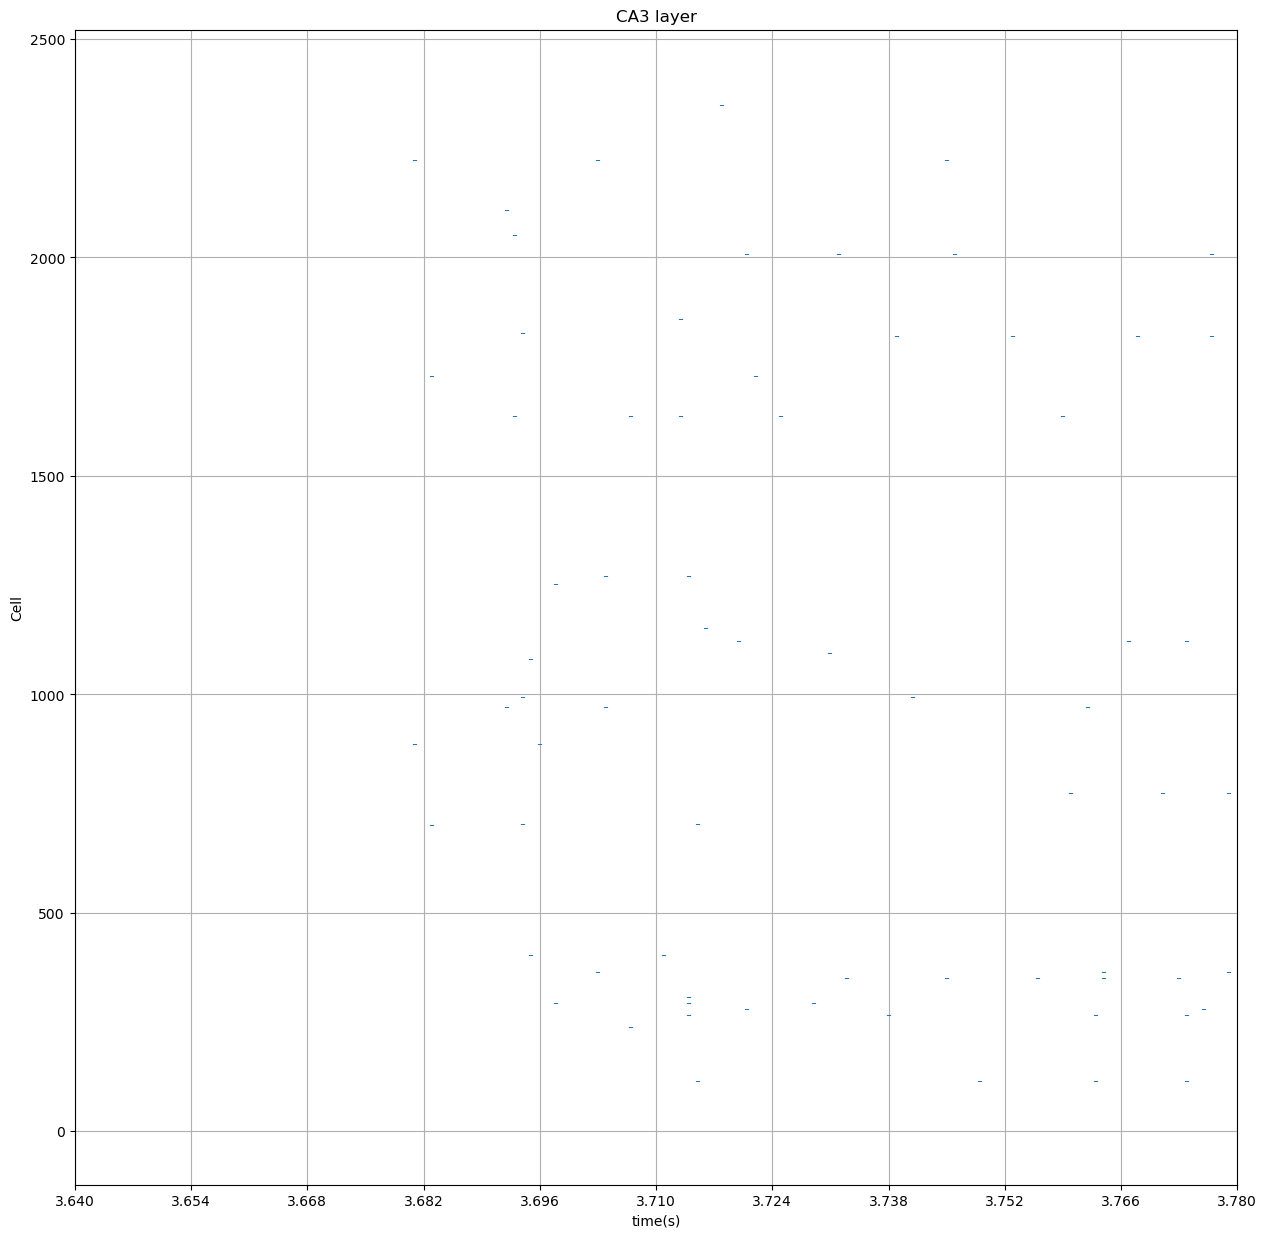

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


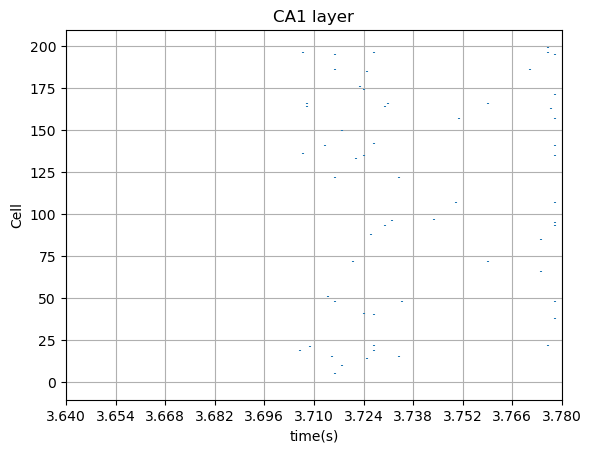

Ret1 :  {700, 885, 2221, 1727}
Ret2 :  {2051, 402, 1825, 292, 2221, 1080, 2108, 703, 971, 344, 1882, 993, 1251, 1635, 1637, 364, 237, 885, 1270}
Ret3 :  {1857, 1122, 1635, 292, 1605, 1094, 265, 2347, 1727, 114, 307, 402, 2007, 278, 1270, 349, 1150, 703}
Rc :  {993, 1122, 1635, 773, 265, 971, 364, 2221, 114, 278, 2007, 1819, 349}
intersection with 5 :  {2051, 1094, 237, 402, 885, 344, 1080}
---------------------------------------------------------------------------------
0 3863 [402]


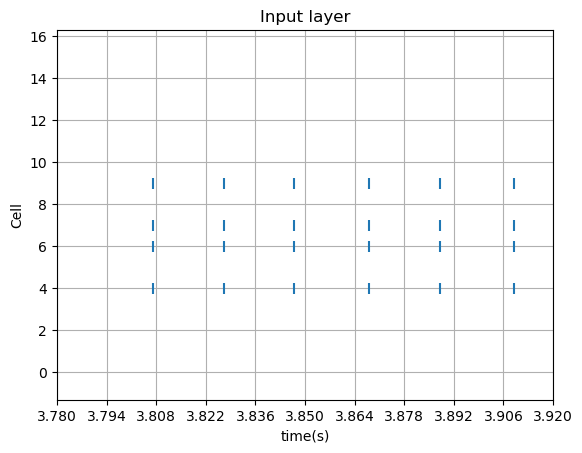

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


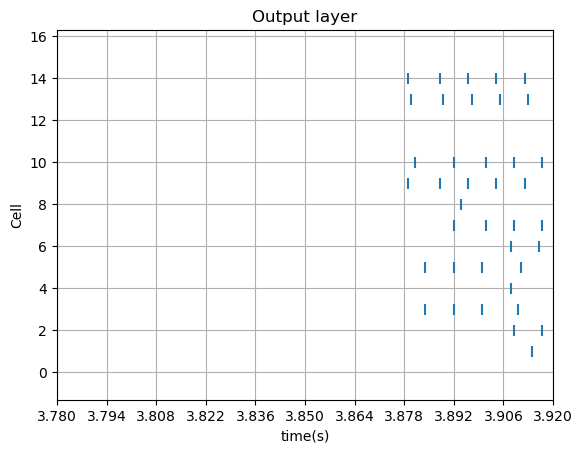

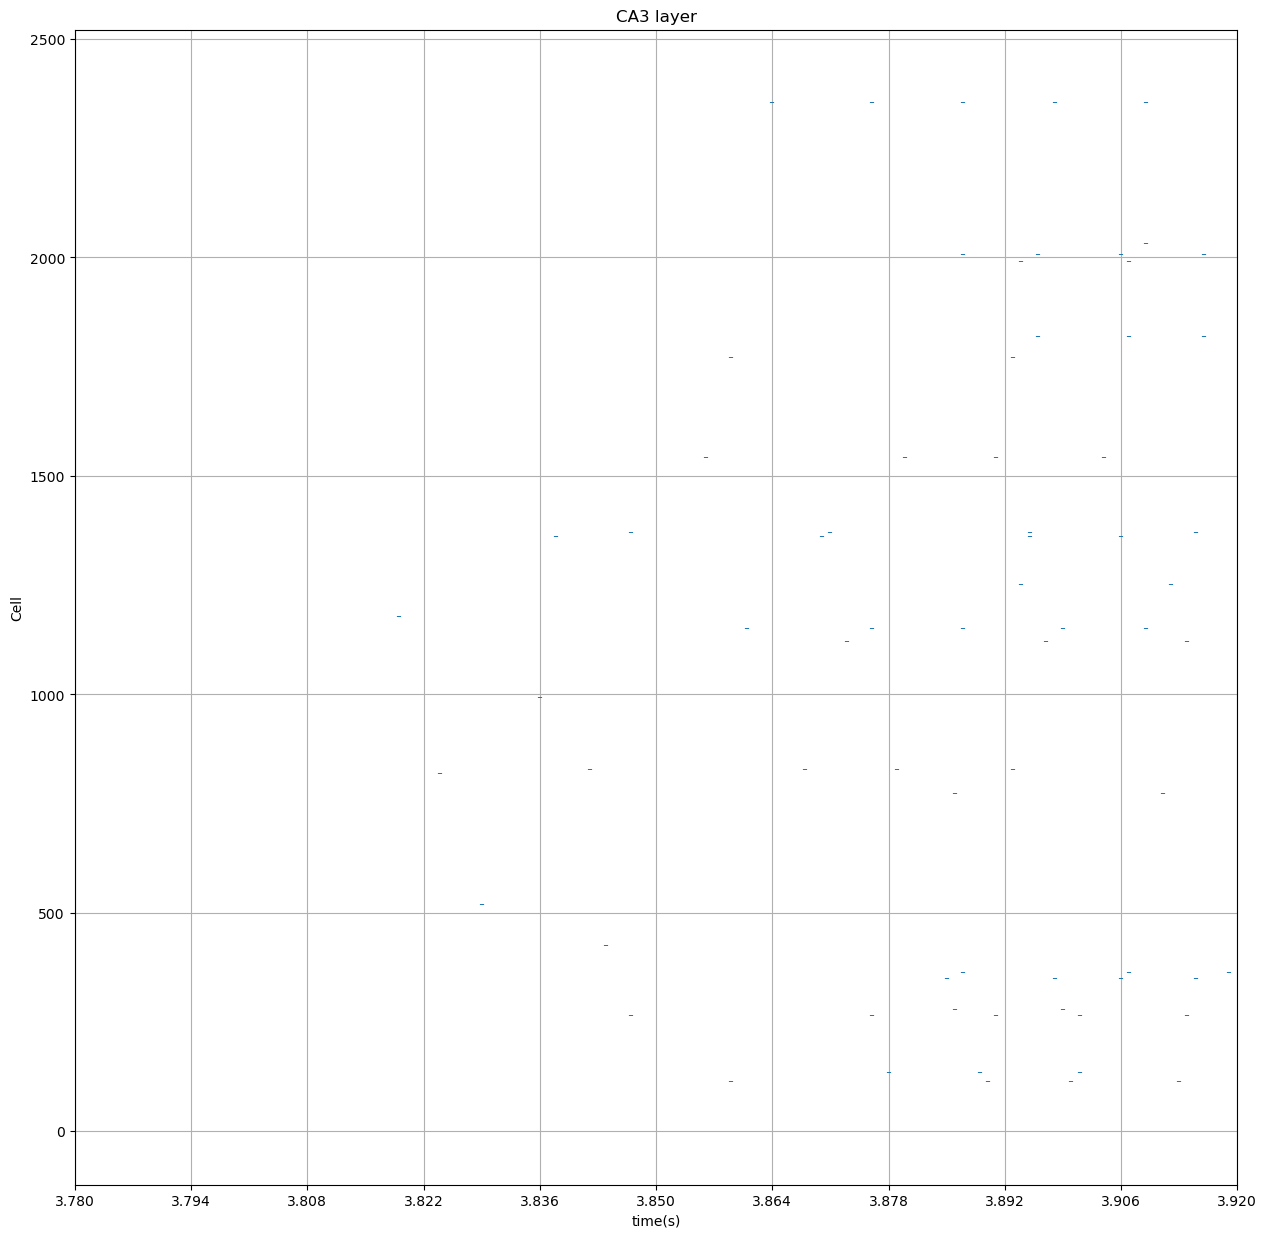

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


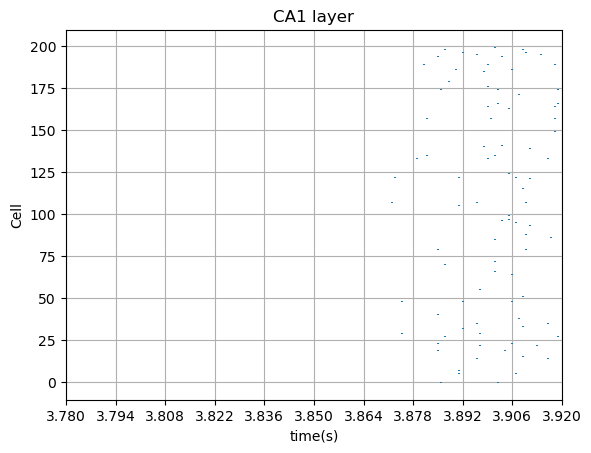

Ret1 :  {818, 1179}
Ret2 :  {993, 422, 519, 264, 265, 425, 1362, 1371, 828}
Ret3 :  {1122, 1542, 1770, 1772, 557, 114, 1362, 2355, 1882, 1371, 828, 1150}
Rc :  {773, 134, 1542, 265, 278, 1819, 557, 1969, 2355, 828, 1991, 1362, 2007, 1371, 349, 1122, 1251, 1770, 364, 1772, 2031, 114, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
0 3963 [885]
0 4001 [402]


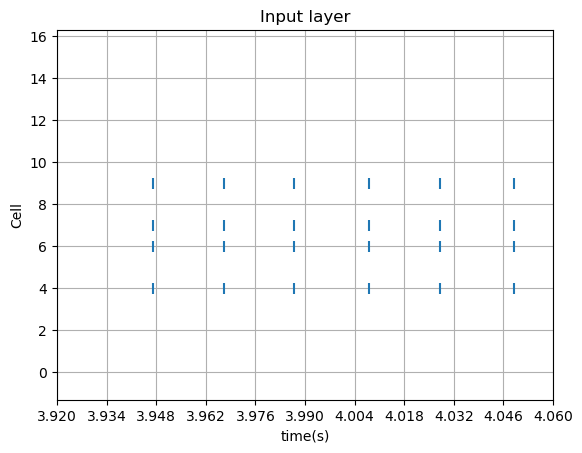

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


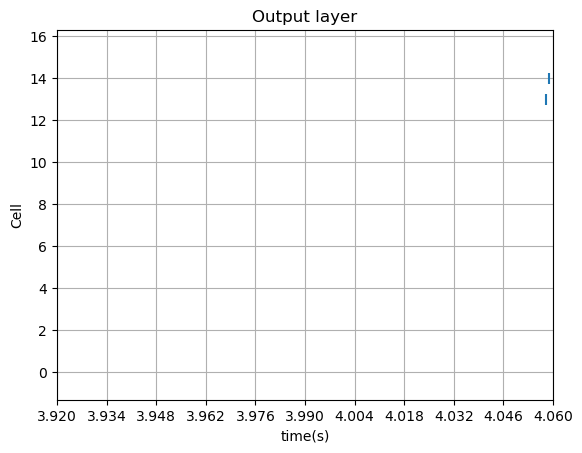

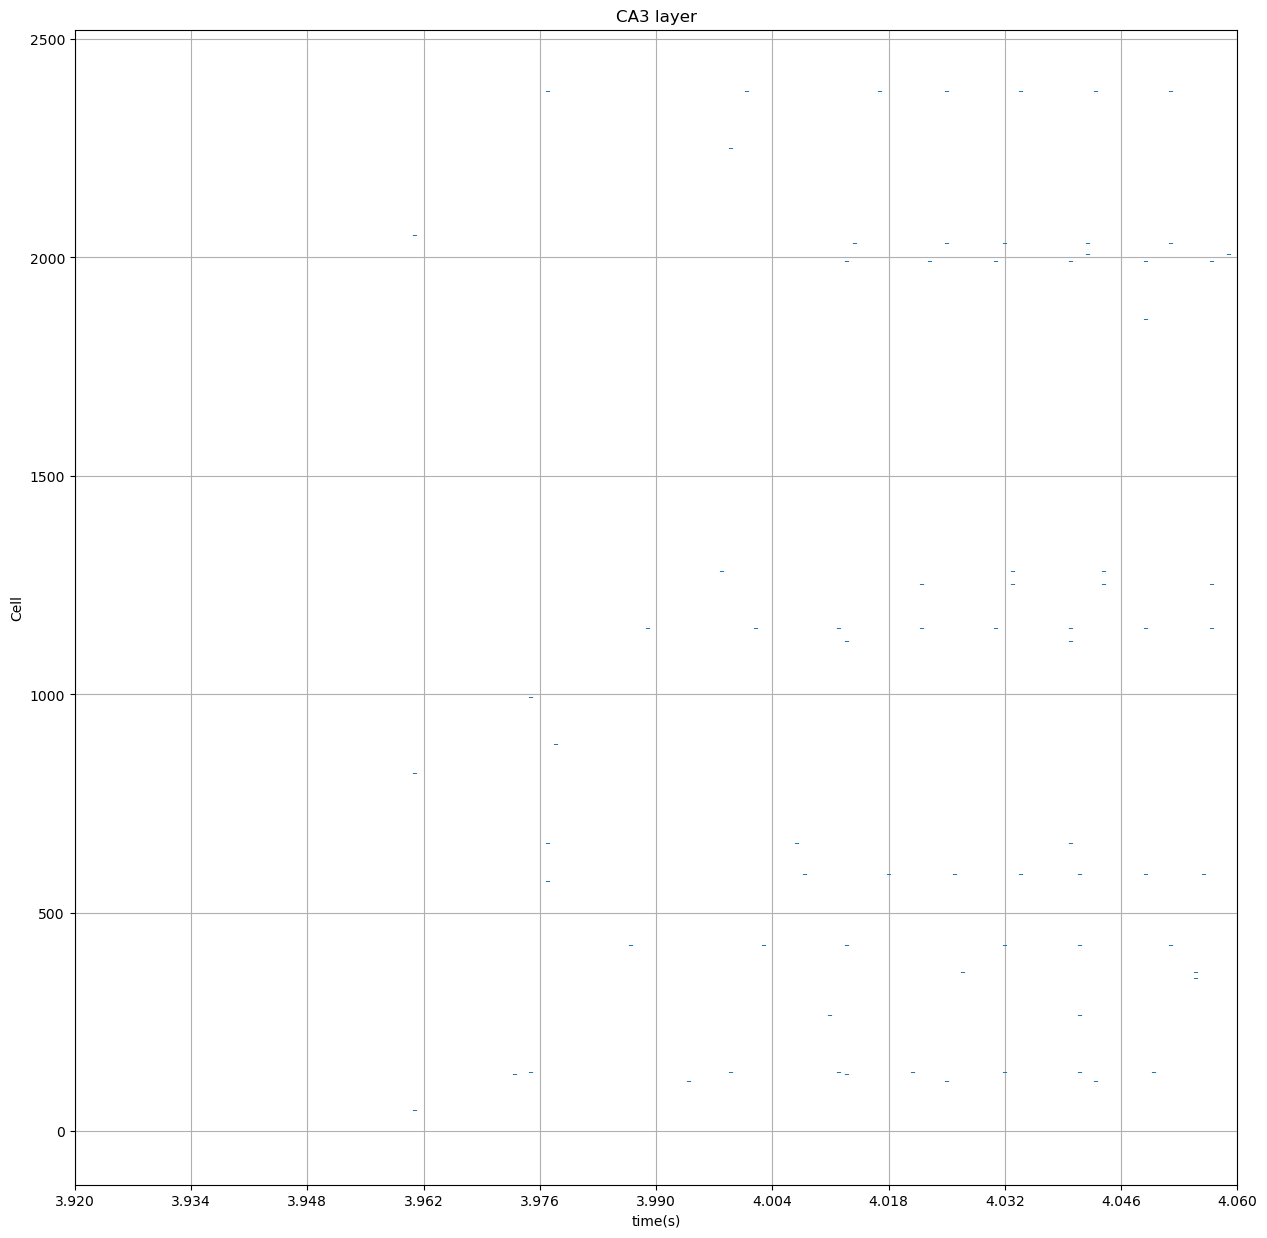

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


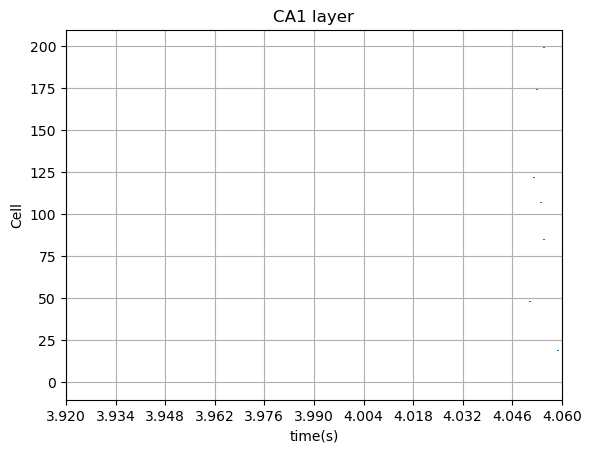

Ret1 :  {48, 1969, 818, 2051}
Ret2 :  {993, 1374, 131, 1637, 134, 425, 2380, 658, 885, 571, 1150}
Ret3 :  {1281, 1122, 131, 1374, 134, 1991, 425, 265, 2249, 588, 2380, 2031, 1969, 114, 658, 1882, 1150}
Rc :  {1281, 134, 265, 658, 425, 1969, 1857, 1991, 588, 2380, 2007, 1882, 349, 1374, 1122, 1251, 364, 2031, 114, 1150}
intersection with 5 :  {2051, 885}
---------------------------------------------------------------------------------
0 4145 [237]


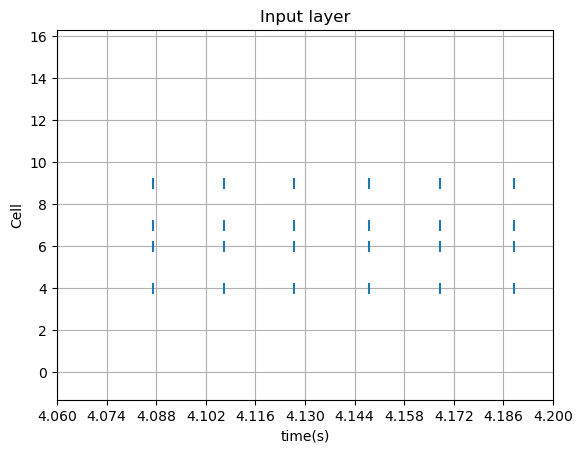

0 :  [ 2  4 15]
1 :  [ 3  5  7  8  9 10 13 14]
2 :  [ 0  5  7 14]
3 :  [ 1  3  4  5  7 11 13 15]
4 :  [ 0  1  4  6  7  8  9 10 11 13 14 15]
5 :  [3]
6 :  [ 1  2  4  6  7  9 10 13 14]
7 :  [0 8]
8 :  [ 1  7  8 10 11 13 14]
9 :  [ 0 10 12]


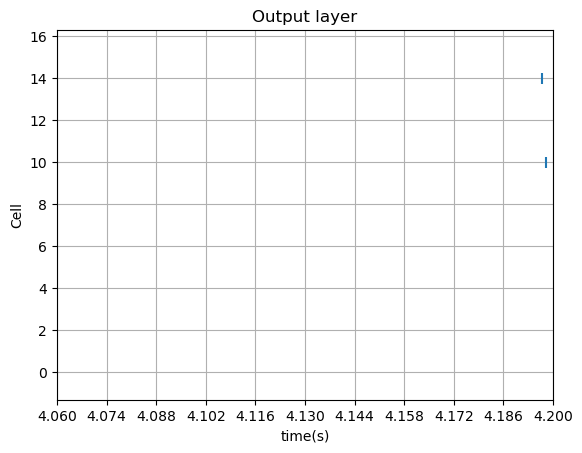

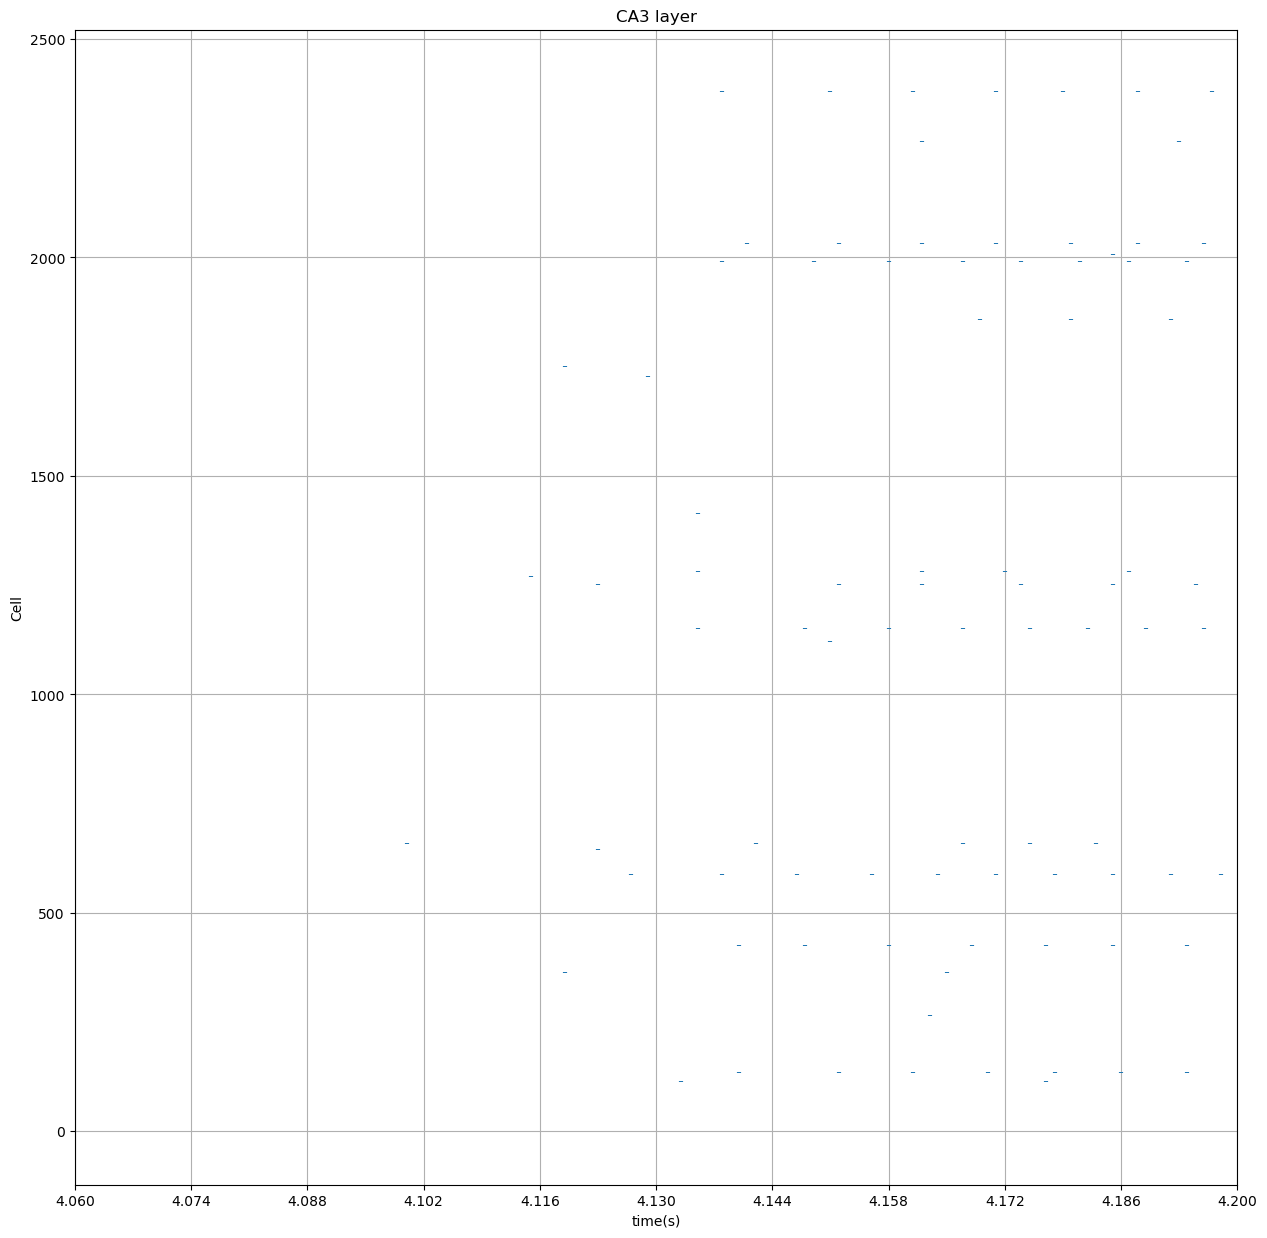

0 :  [1921, 2051, 1930, 402, 1080, 1094, 344, 237, 885]
1 :  [1857, 837, 1542, 1362, 1371, 1770, 557, 1772, 2355, 828, 1150]
2 :  [524, 918, 2347, 818, 63, 1857, 993, 1134, 1270]
3 :  [131, 1028, 645, 2249, 1494, 2265, 2332, 1637, 48, 571, 1212]
4 :  [1281, 134, 658, 425, 1969, 1991, 2380, 588, 1882, 1374, 2266, 1251, 2031, 1150]
5 :  [1290, 2332, 571, 827, 2385, 1124, 131, 645, 140, 2249, 1494, 236, 754, 501, 1270, 1271]
6 :  [773, 265, 278, 1819, 349, 1122, 364, 114, 2007]
7 :  [706, 1735, 904, 1681, 593, 83, 2387, 410, 2079, 549, 2347, 49, 2364, 444, 701]
8 :  [1857, 1605, 971, 1614, 918, 993, 1635, 292, 2221, 2108, 1727, 1270, 703]
9 :  [1218, 1862, 266, 1673, 1864, 1737, 1995, 1869, 2391, 158, 416, 49, 1212]
Actually firing CA3 at encoding :  set()


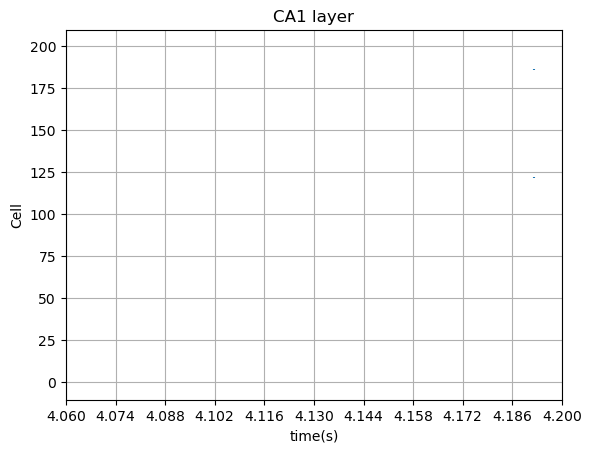

Ret1 :  {658}
Ret2 :  {1251, 1731, 645, 364, 588, 1969, 1270, 1751, 1882, 1374, 1727}
Ret3 :  {1281, 1122, 1251, 1374, 1413, 134, 1991, 425, 588, 2380, 2031, 1969, 114, 658, 1882, 1150}
Rc :  {1281, 134, 265, 658, 425, 1969, 1857, 1991, 588, 2380, 2007, 2266, 1882, 1374, 1251, 364, 2031, 114, 1150}
intersection with 5 :  set()
---------------------------------------------------------------------------------
Success :  14
Fail :  0
If_fail :  16
Output bias (mean, std) :  1.4 3.104834939252004


In [24]:
# Retrieval
for Trial in range(1):    
    # initiation
    En_win = 120
    Re_win = 120
    
    # 현 trial에서 cue의 개수
    Num_tar = 10
    Num_cue = 1
    Repeat = 10
    
    Phase_num = Num_cue*Repeat
    
    only_DG = False
    only_CA3 = True

    Target = Target_Data
    Cue = np.zeros(16)
    Cue[[4,6,7,9]] = 1

    selective_inhibition = True
    already_learned = True
    Direct_pp = True
    
    if already_learned:
        with open(path+'//module//Learned weights-A10.pkl', 'rb') as file:
            q_ppCA3 = pickle.load(file)   
            q_Rc = pickle.load(file)
            q_CA33i = pickle.load(file)
            q_Sc = pickle.load(file)

        if not selective_inhibition:
            for n in range(params.N_CA3):
                for m in range(params.N_CA3i):
                    if q_CA33i[n,m] !=0:
                        q_CA33i[n,m] = 0.5
        learned_weights = [q_ppCA3, q_Rc, q_CA33i, q_Sc]
    else:
        learned_weights = [0,0,0,0]

    network, Fail, If_fail, Success, Winfin, Voltage, FT = Operate_model.run_model(
        En_win, Re_win, 
        only_DG, only_CA3, 
        Num_tar, Num_cue, Repeat, Target, Cue, 
        WTS, params, 
        already_learned, learned_weights, Direct_pp,
        Filt_idata, Filt_gdata, Af_py, Af_in)
    
with open('Spikes_retrieval.pkl', 'wb') as file:
    pickle.dump(network, file)
    pickle.dump(FT, file)
    pickle.dump(Voltage, file)